# Compare height of males and females at same age

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aging.organization.dataframes import get_age
from aging.organization.paths import get_experiment_grouped_files
from toolz import compose, valmap, curry, complement, groupby, keyfilter

In [2]:
def is_old_proc(file):
    return file.parent.name == "proc"


def has_key(key, file):
    with h5py.File(file, 'r') as h5f:
        return key in h5f


def load_height(file):
    with h5py.File(file, 'r') as h5f:
        height = h5f['scalars/height_ave_mm'][()]
    return np.nanmedian(height)

In [3]:
paths = get_experiment_grouped_files()

In [4]:
old_files = valmap(compose(list, curry(filter)(is_old_proc)), paths)
new_files = valmap(compose(list, curry(filter)(complement(is_old_proc))), paths)

## Ontogeny

In [5]:
females = new_files['ontogeny_females']
females = groupby(get_age, females)

males = new_files['ontogeny_males']
males = groupby(get_age, males)

In [6]:
omh = list(map(load_height, males[12]))
ofh = list(map(load_height, females[12]))

In [7]:
np.mean(omh)

30.505692

In [8]:
np.mean(ofh)

27.851292

<Axes: ylabel='Count'>

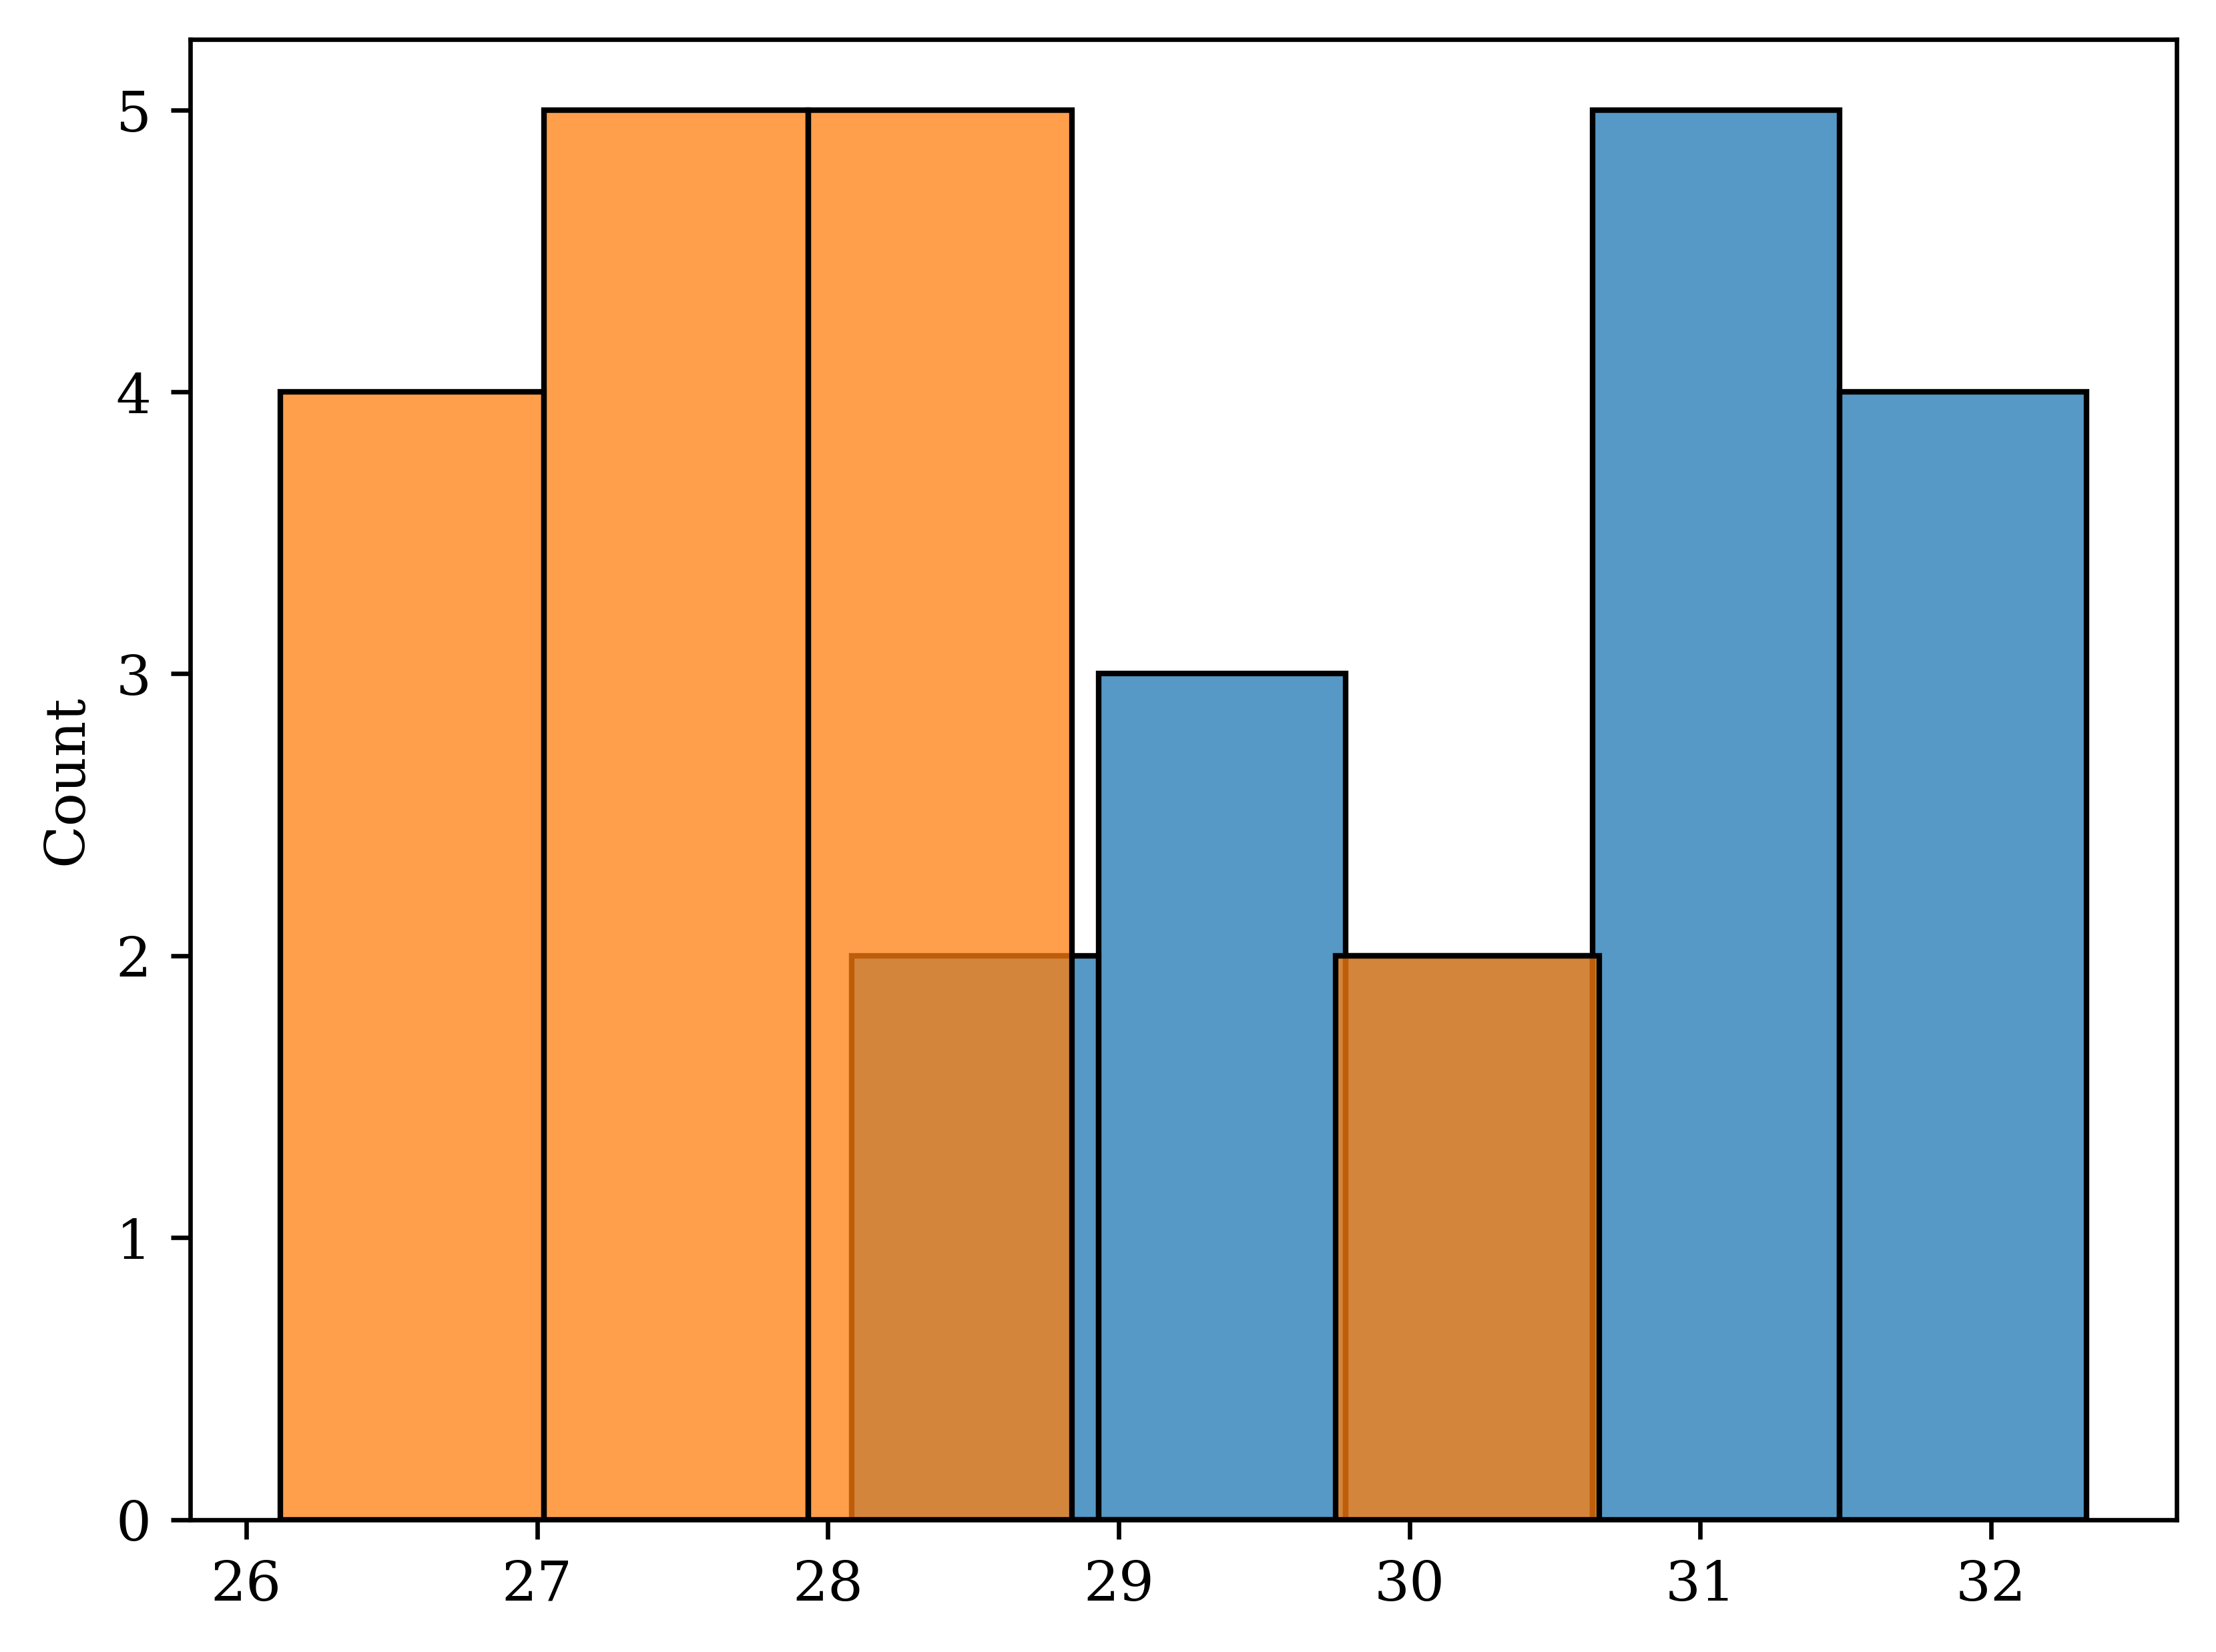

In [9]:
sns.histplot(omh)
sns.histplot(ofh)

## Longtogeny v2

In [10]:
females = new_files['longtogeny_v2_females']
females = groupby(lambda k: (get_age(k) * 7) // 7, females)

males = new_files['longtogeny_v2_males']
males = groupby(lambda k: (get_age(k) * 7) // 7, males)

In [11]:
lmh = list(map(load_height, males[12]))
lfh = list(map(load_height, females[12]))

In [12]:
np.mean(lmh)

32.836525

In [13]:
np.mean(lfh)

31.038258

<Axes: ylabel='Count'>

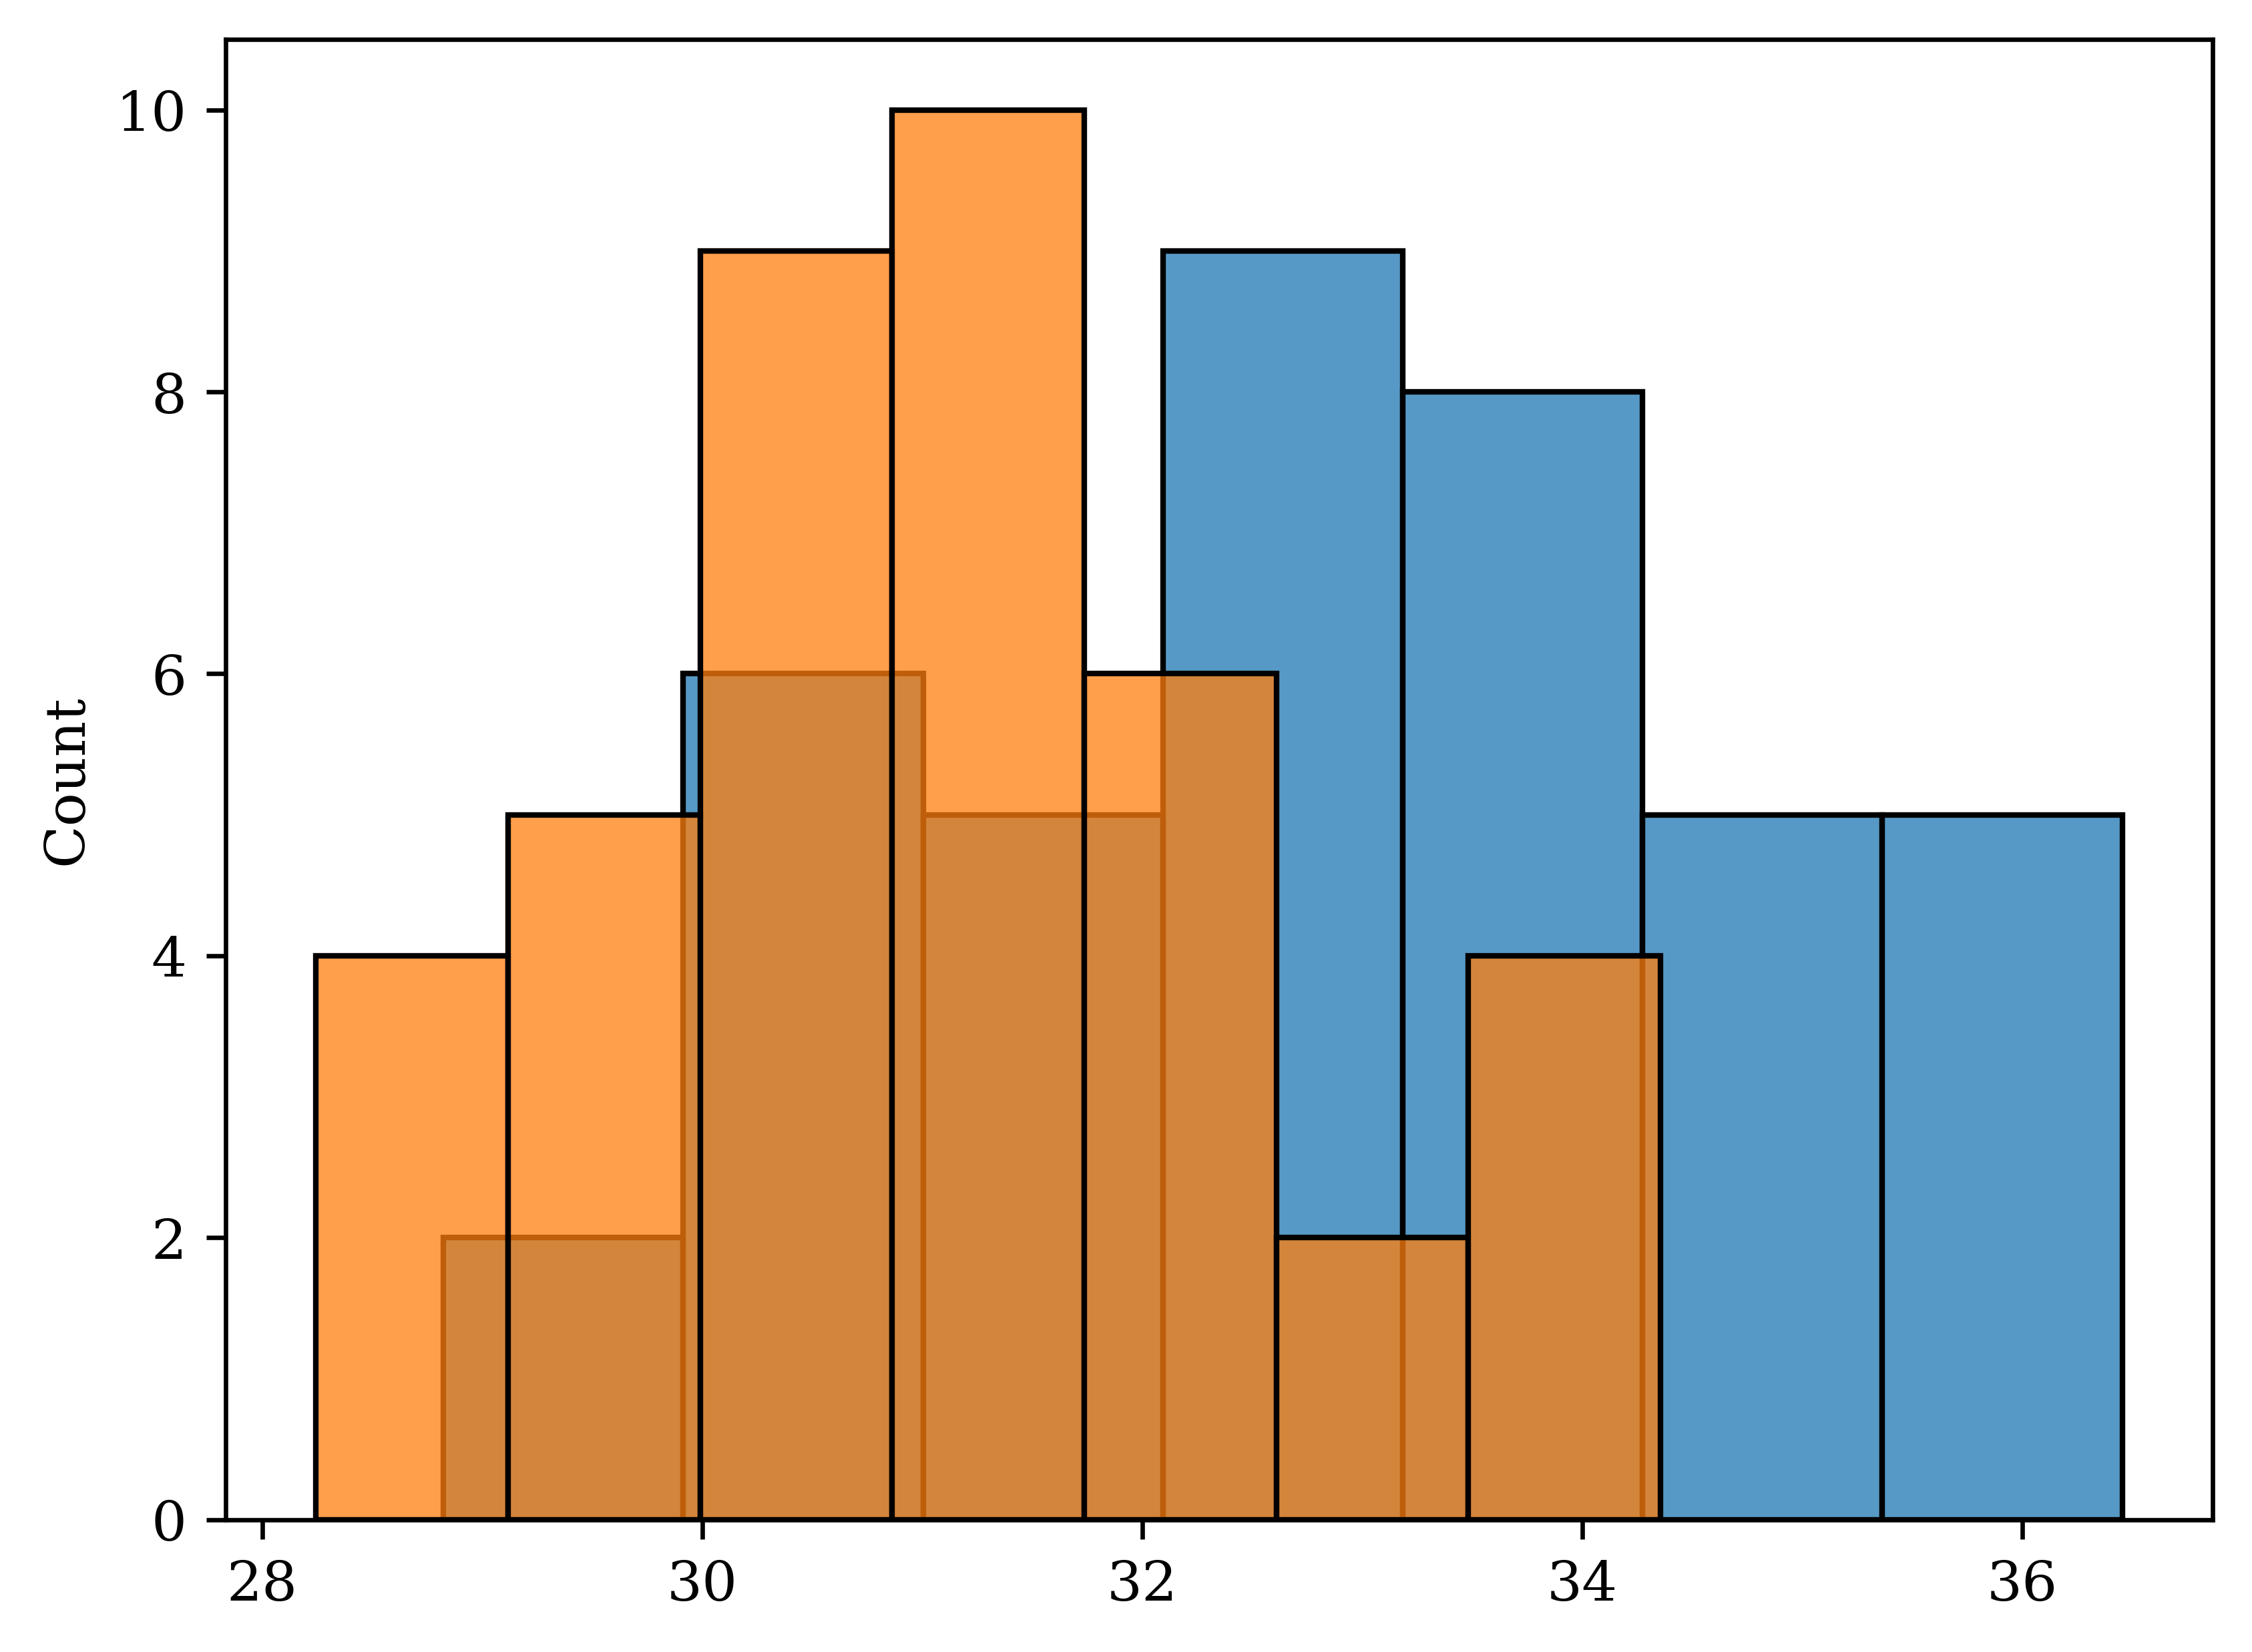

In [14]:
sns.histplot(lmh)
sns.histplot(lfh)

## Compare ont to long

<Axes: ylabel='Count'>

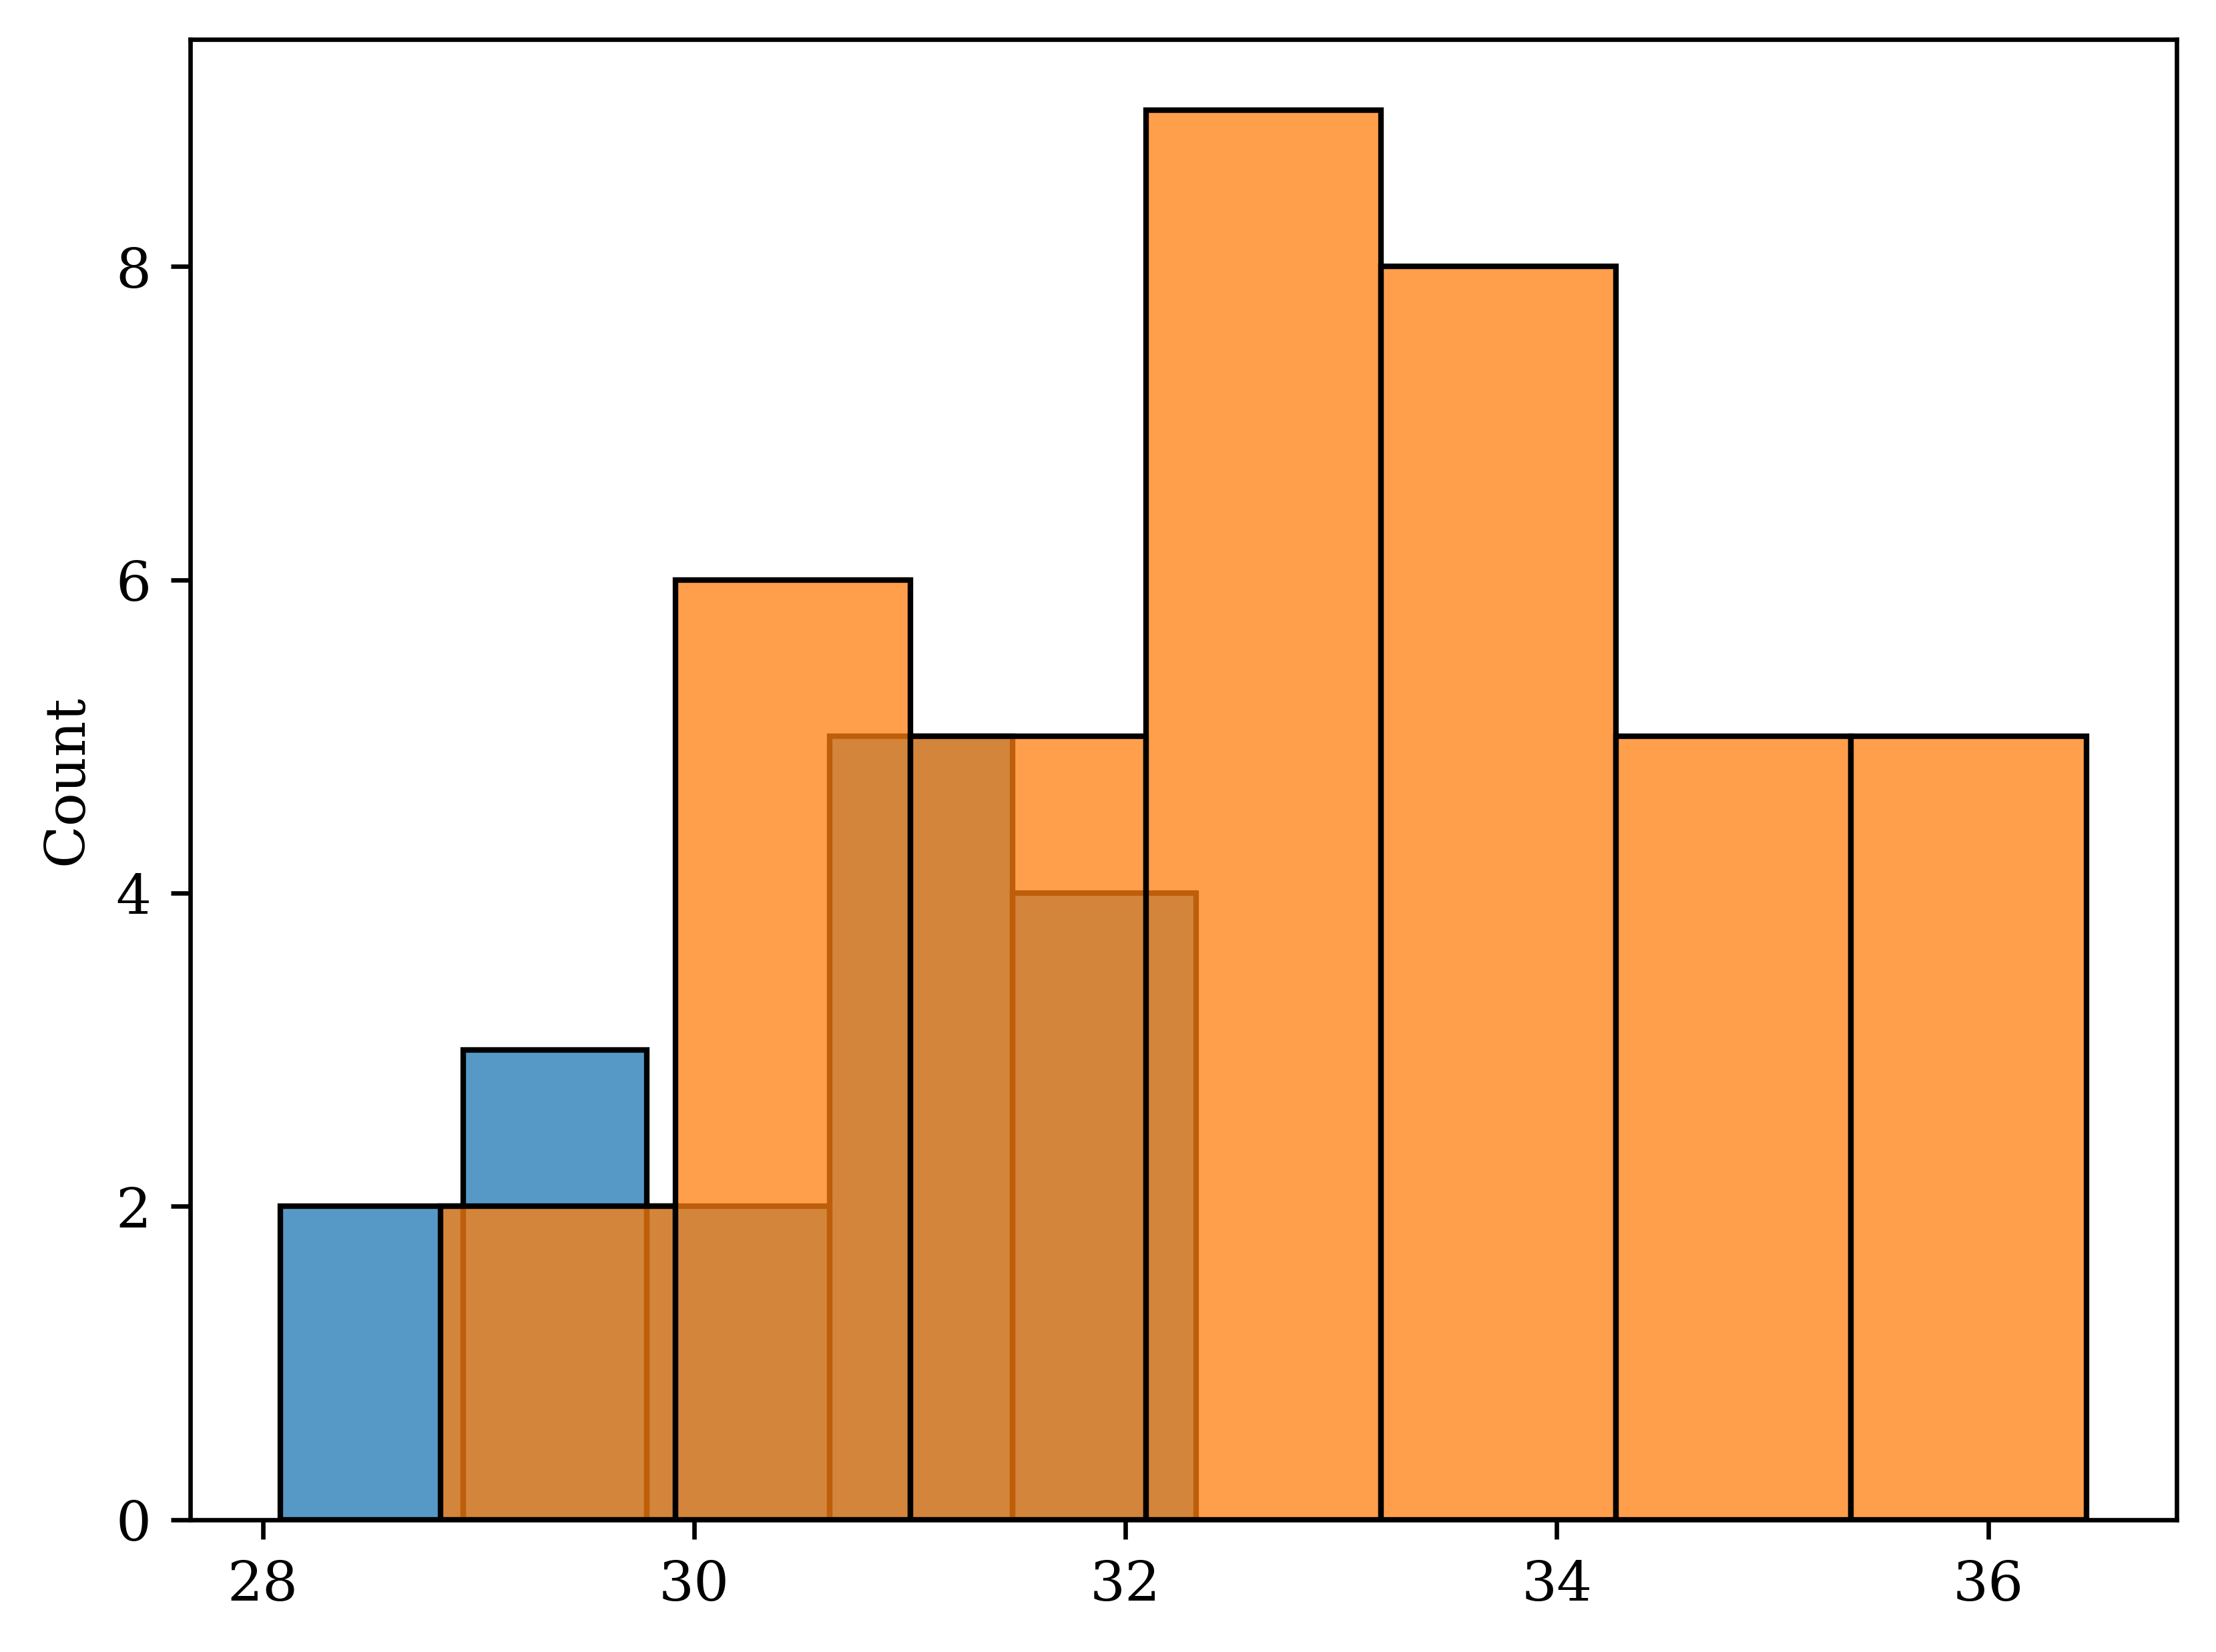

In [17]:
sns.histplot(omh)
sns.histplot(lmh)

<Axes: ylabel='Count'>

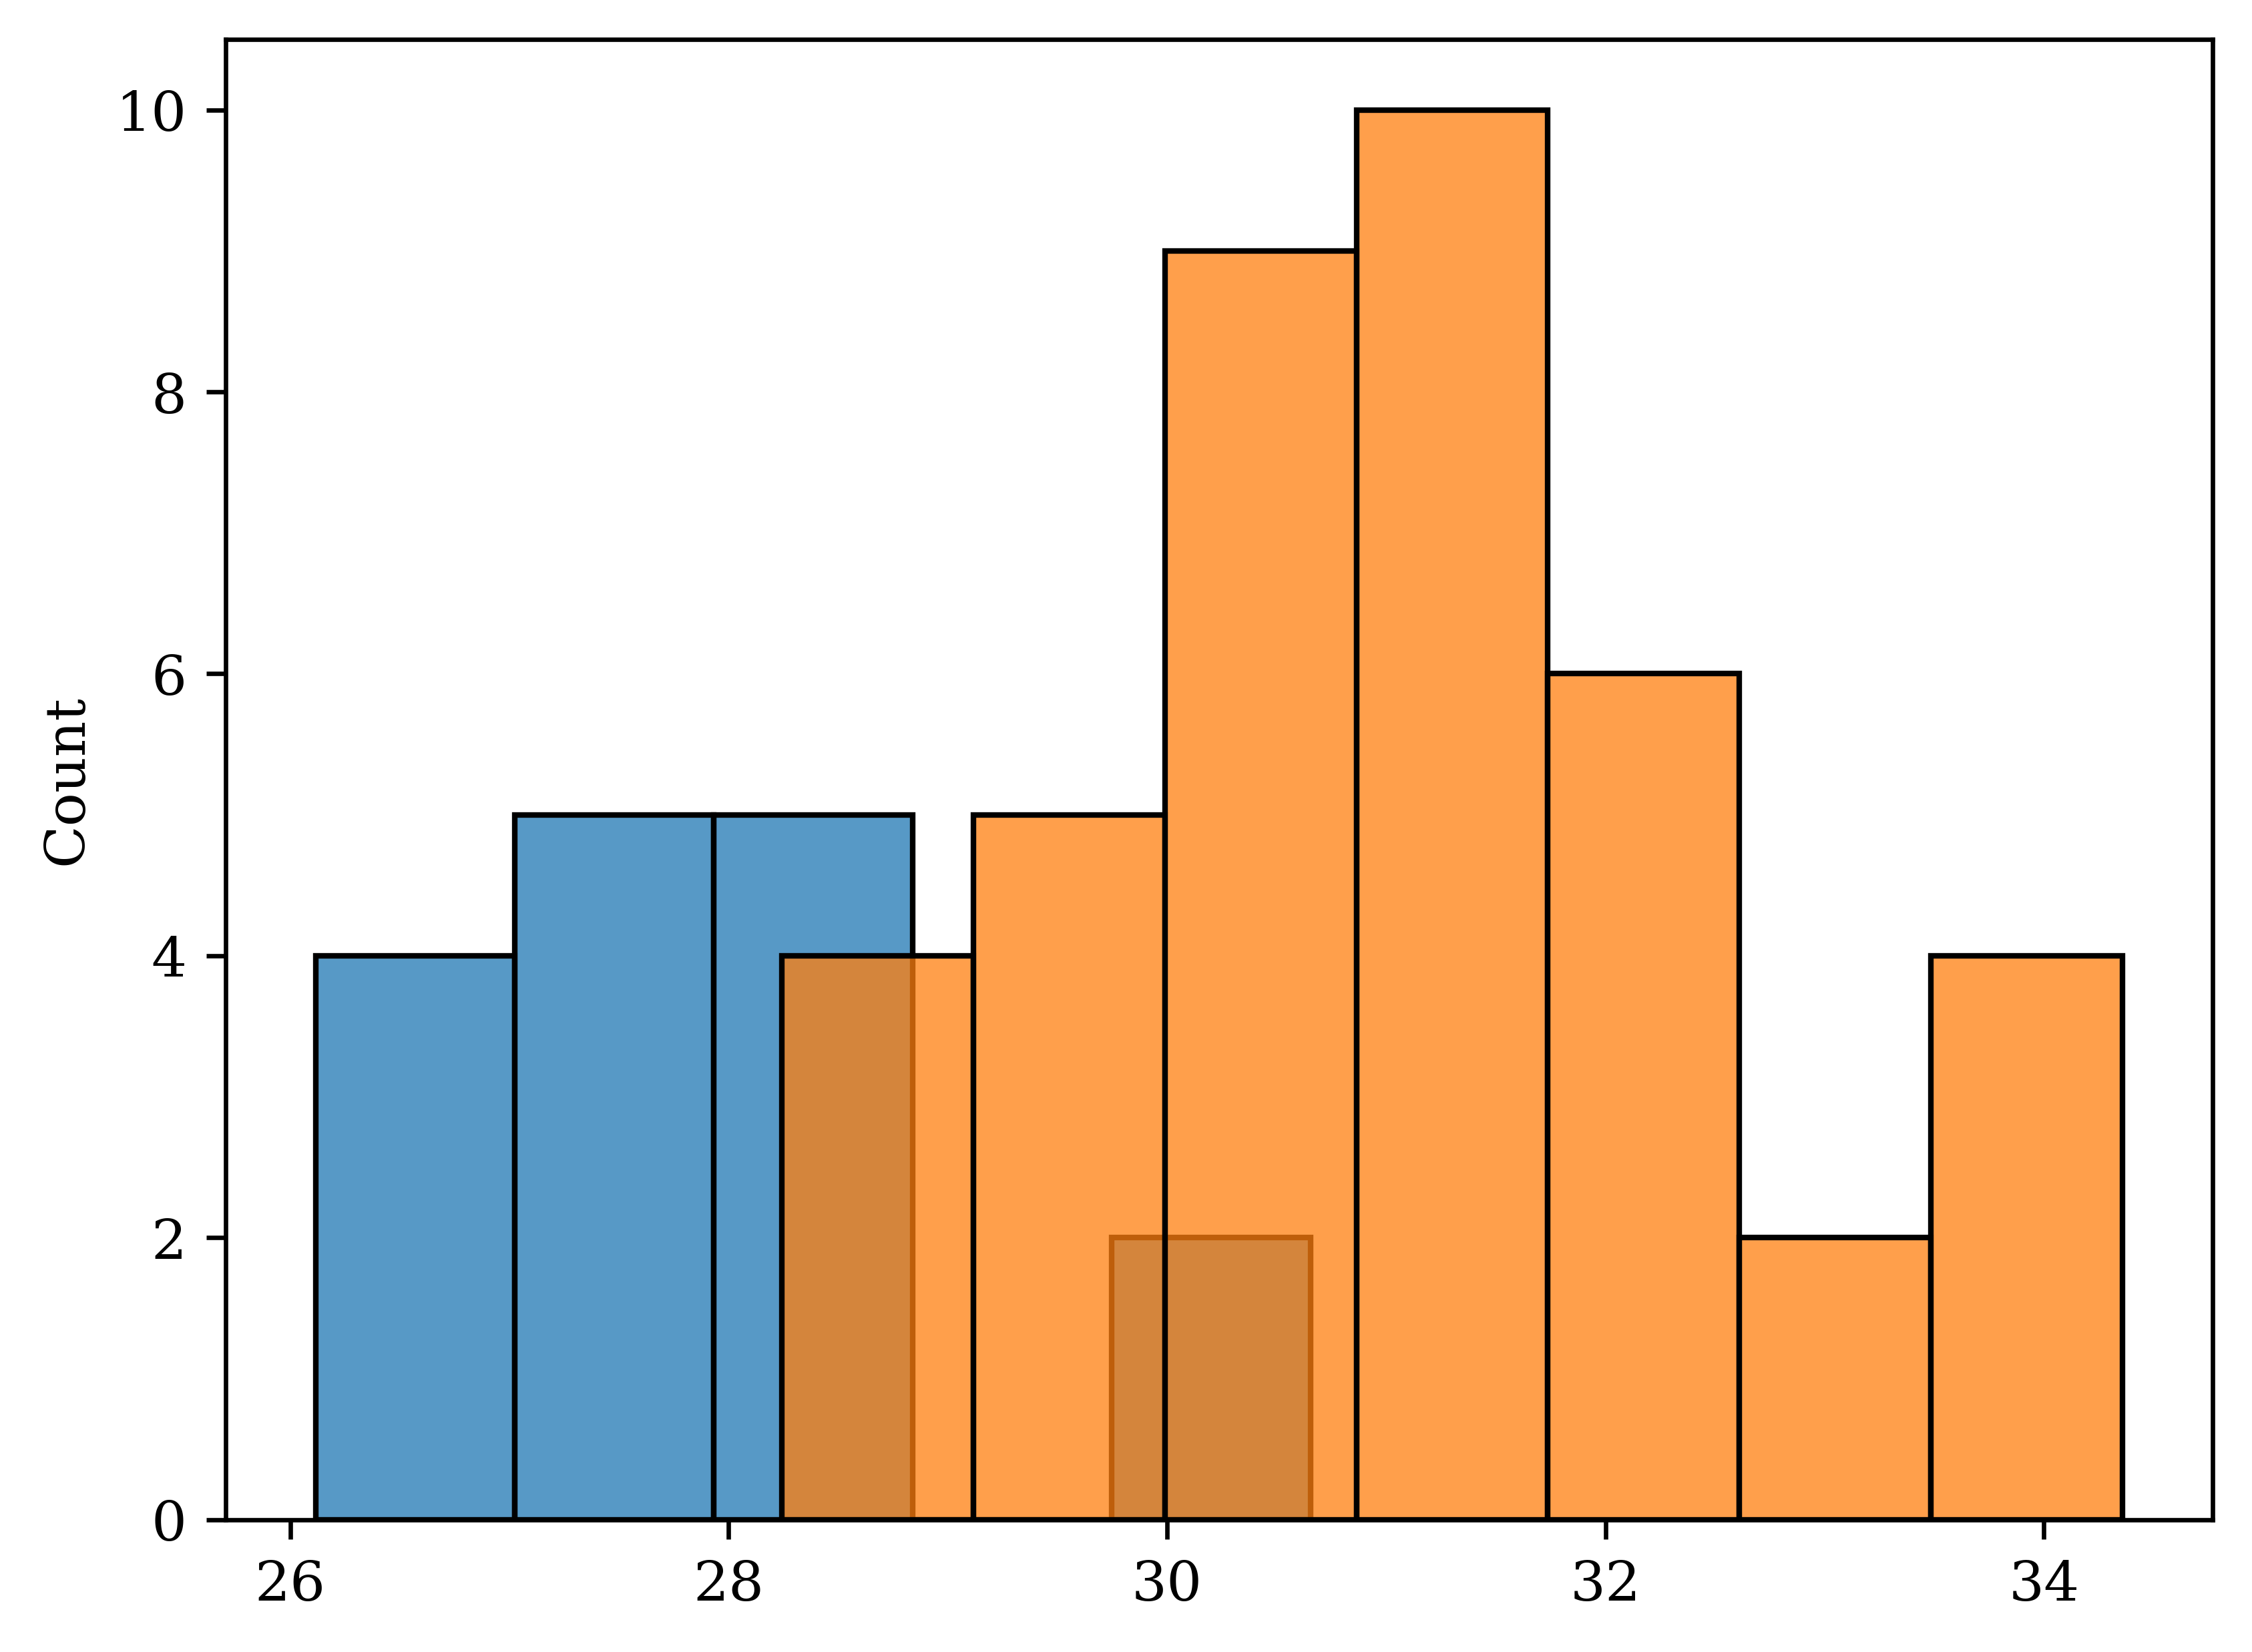

In [18]:
sns.histplot(ofh)
sns.histplot(lfh)

# Offset raw male and female depth data to see if average SNN height changes

In [5]:
import torch
from pathlib import Path
from aging.size_norm.data import Session, clean
from aging.size_norm.lightning import predict
from aging.size_norm.apply import rescale_data

In [6]:
def predict_and_return(model, frames, height_offset: int = 0, rescale=False, clean_noise=False):
    data = frames.copy()

    # optionally rescale animal to match 3-month old and clean frame
    if clean_noise:
        data = np.array([clean(frame, height_thresh=8, tail_ksize=9) for frame in data])
    if rescale:
        data = rescale_data(data)
    data = np.clip(np.where(data > 0, data.astype('float32') + height_offset, 0), 0, 150)

    data = Session(data)
    output = predict(data, model, batch_size=512, desc="Predicting")
    output[output < 1] = 0
    output = np.clip(np.round(output), 0, 255).astype(np.uint8)
    return output

In [7]:
model_path = '/n/groups/datta/win/longtogeny/size_norm/models/bottleneck_optimization_00/stage_06/8a4a38f8-6d43-4df4-988e-8d17402bb23c/model.pt'

In [15]:
females = groupby(get_age, new_files['ontogeny_females'])
males = groupby(get_age, new_files['ontogeny_males'])

In [16]:
animal = females[12][0]

with h5py.File(animal, 'r') as h5f:
    frames = h5f['frames'][:7_500]

In [17]:
model = torch.jit.load(model_path, map_location='cuda')

In [18]:
out = predict_and_return(model, frames, clean_noise=True)

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

In [19]:
offset_poses = {}
for i in np.linspace(-3, 3, 7):
    out_offset = predict_and_return(model, frames, height_offset=i, clean_noise=True)
    h = out_offset.astype('float32') - out.astype('float32')
    medians = np.mean(h, 0)
    offset_poses[i] = medians

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

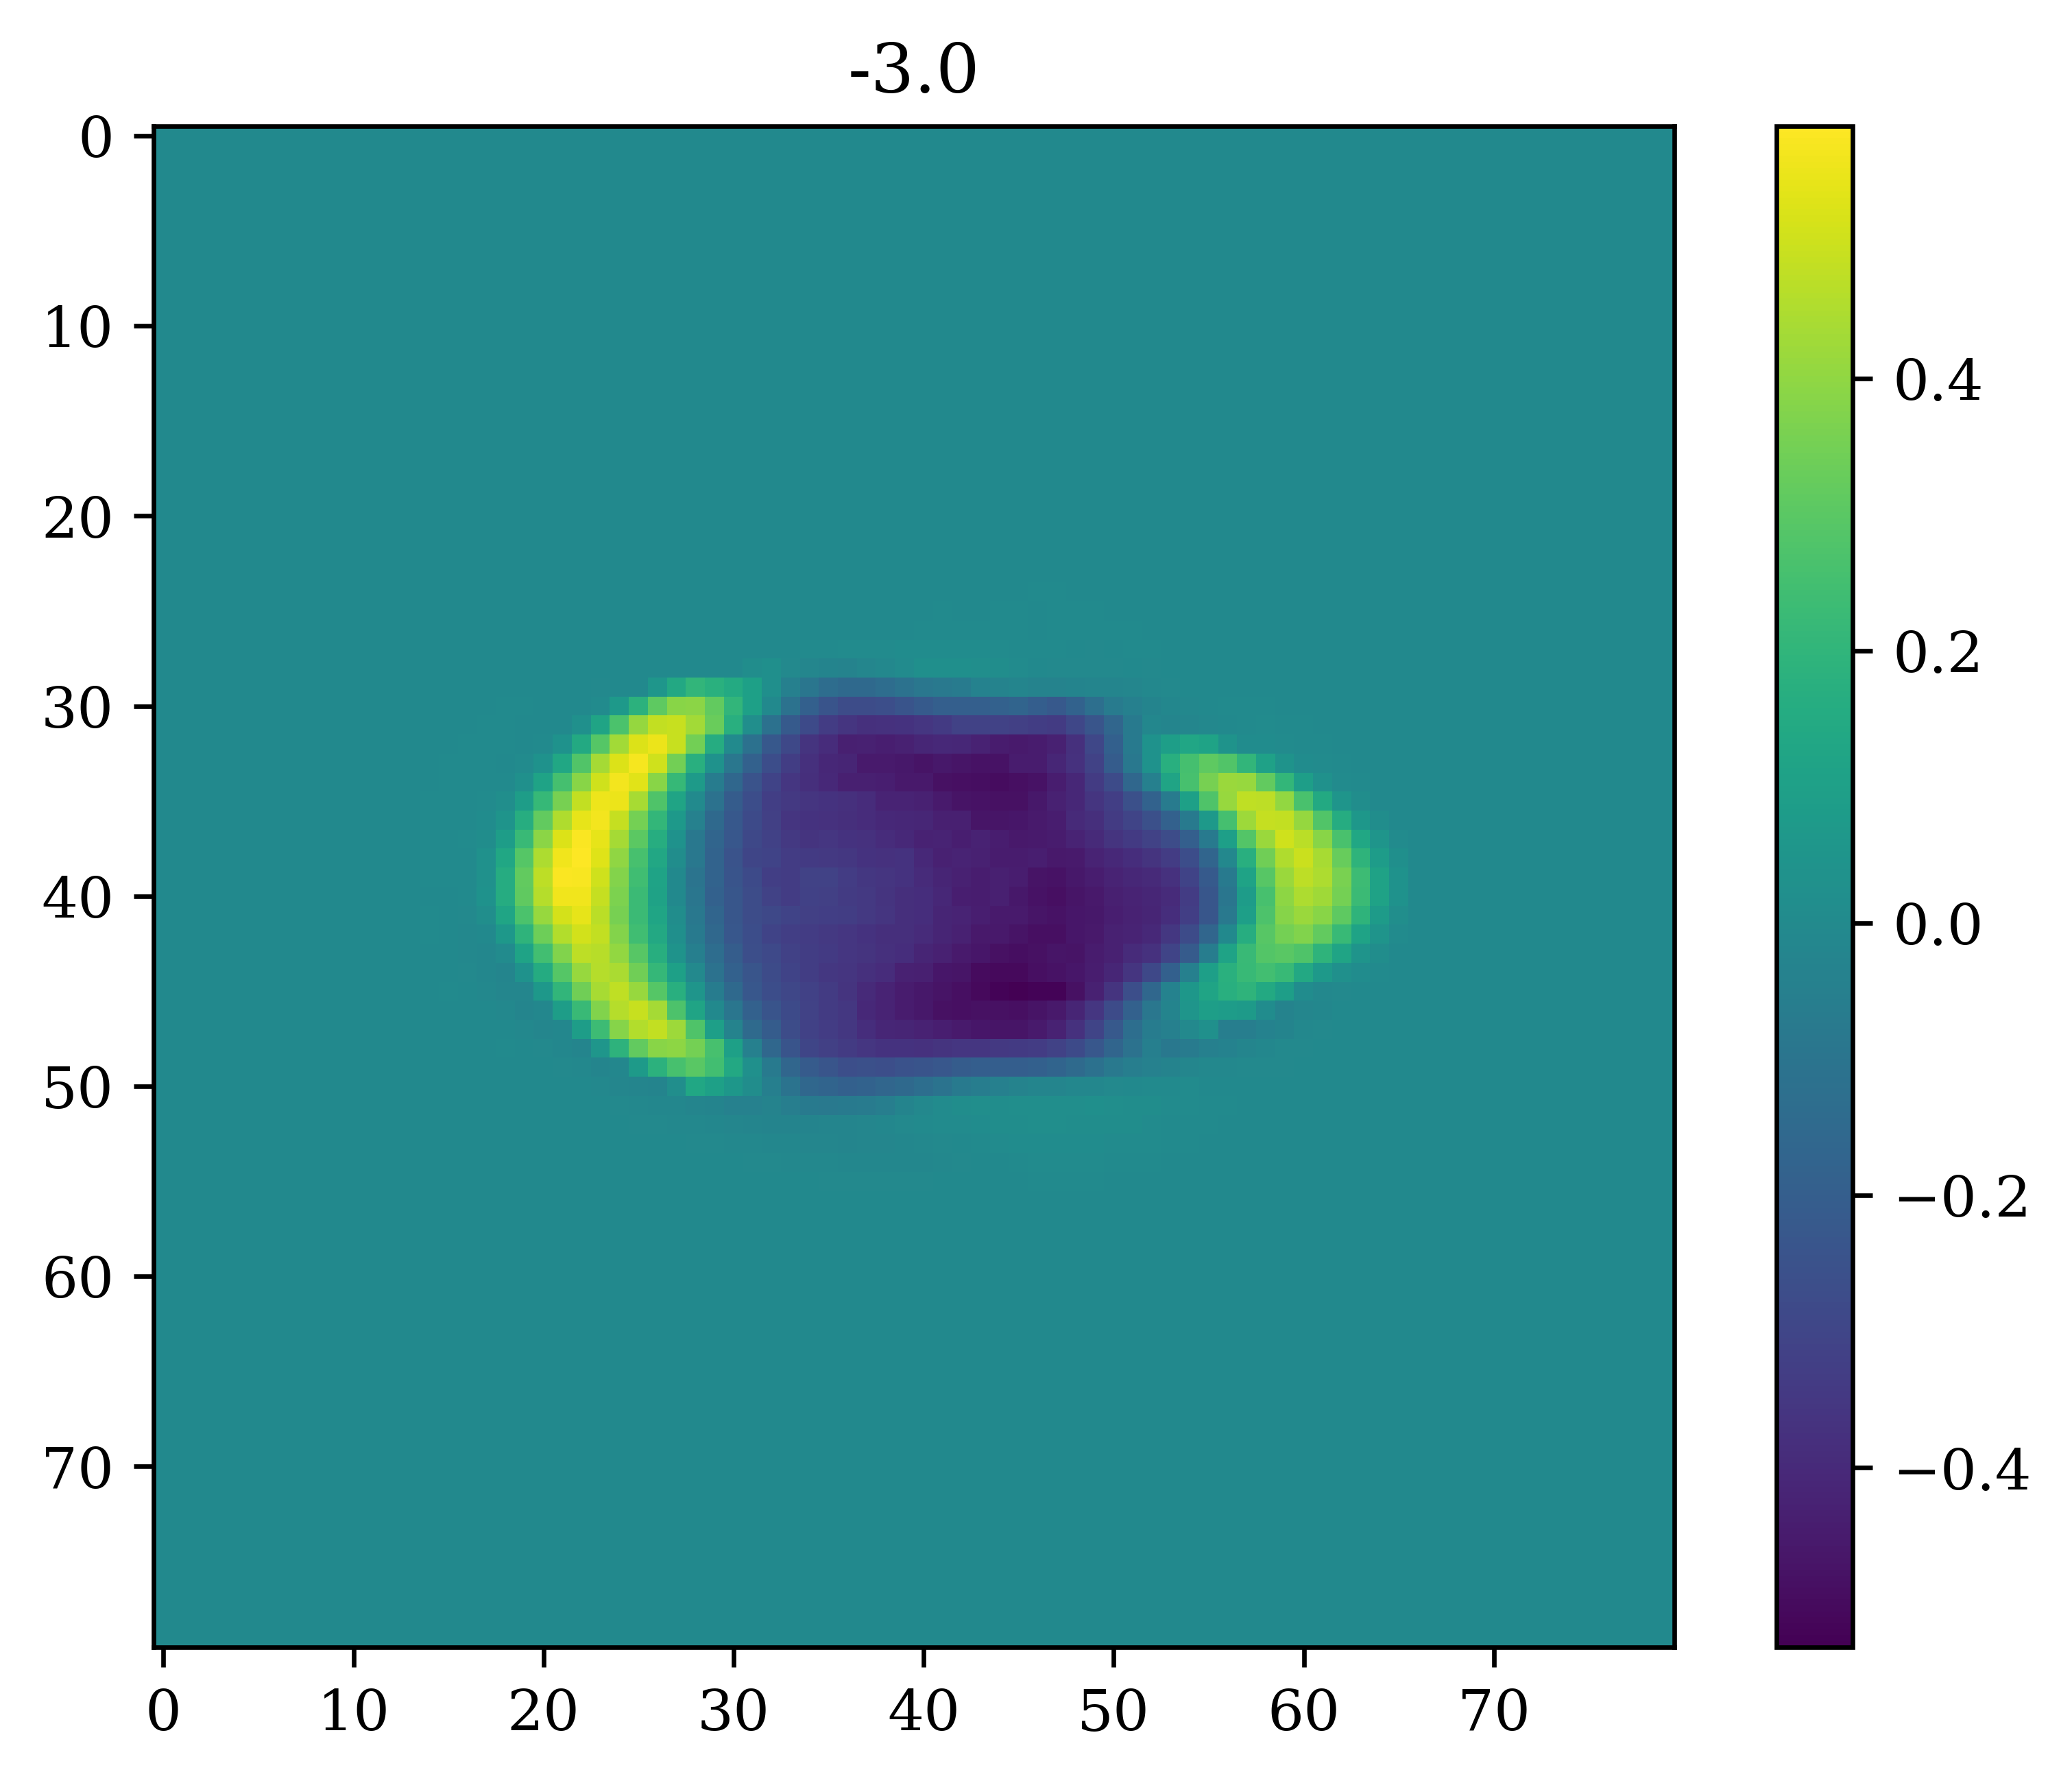

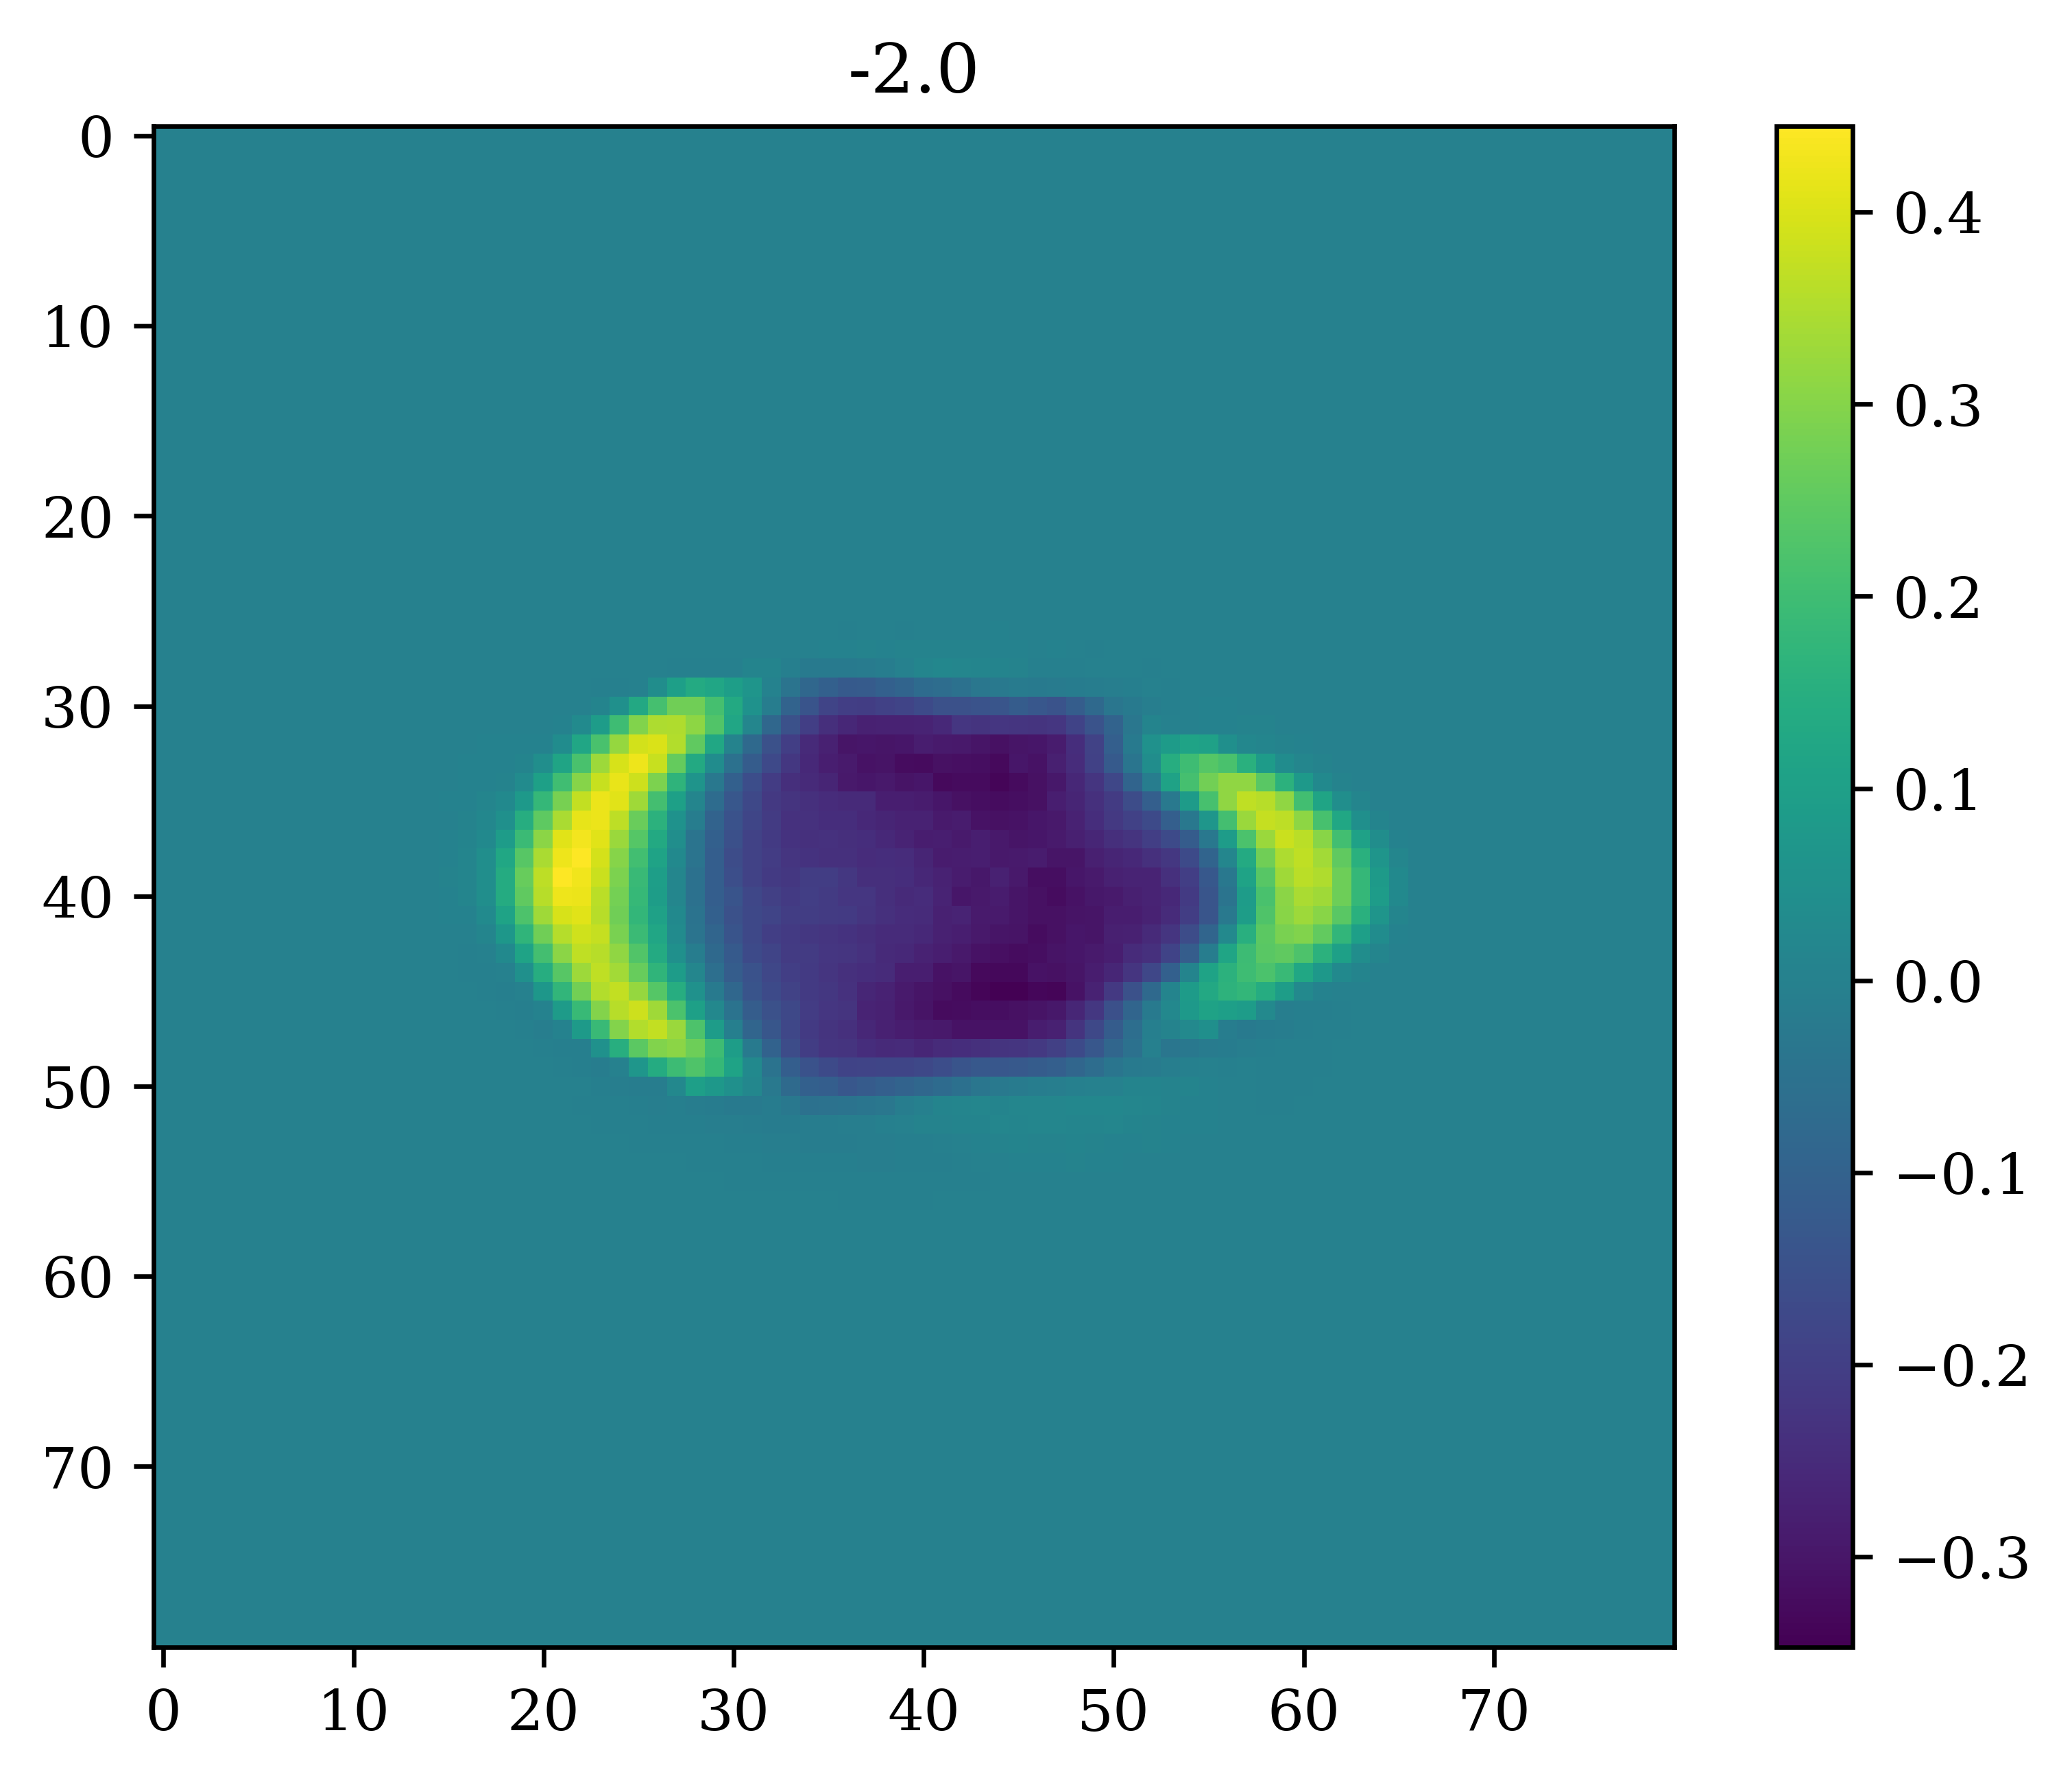

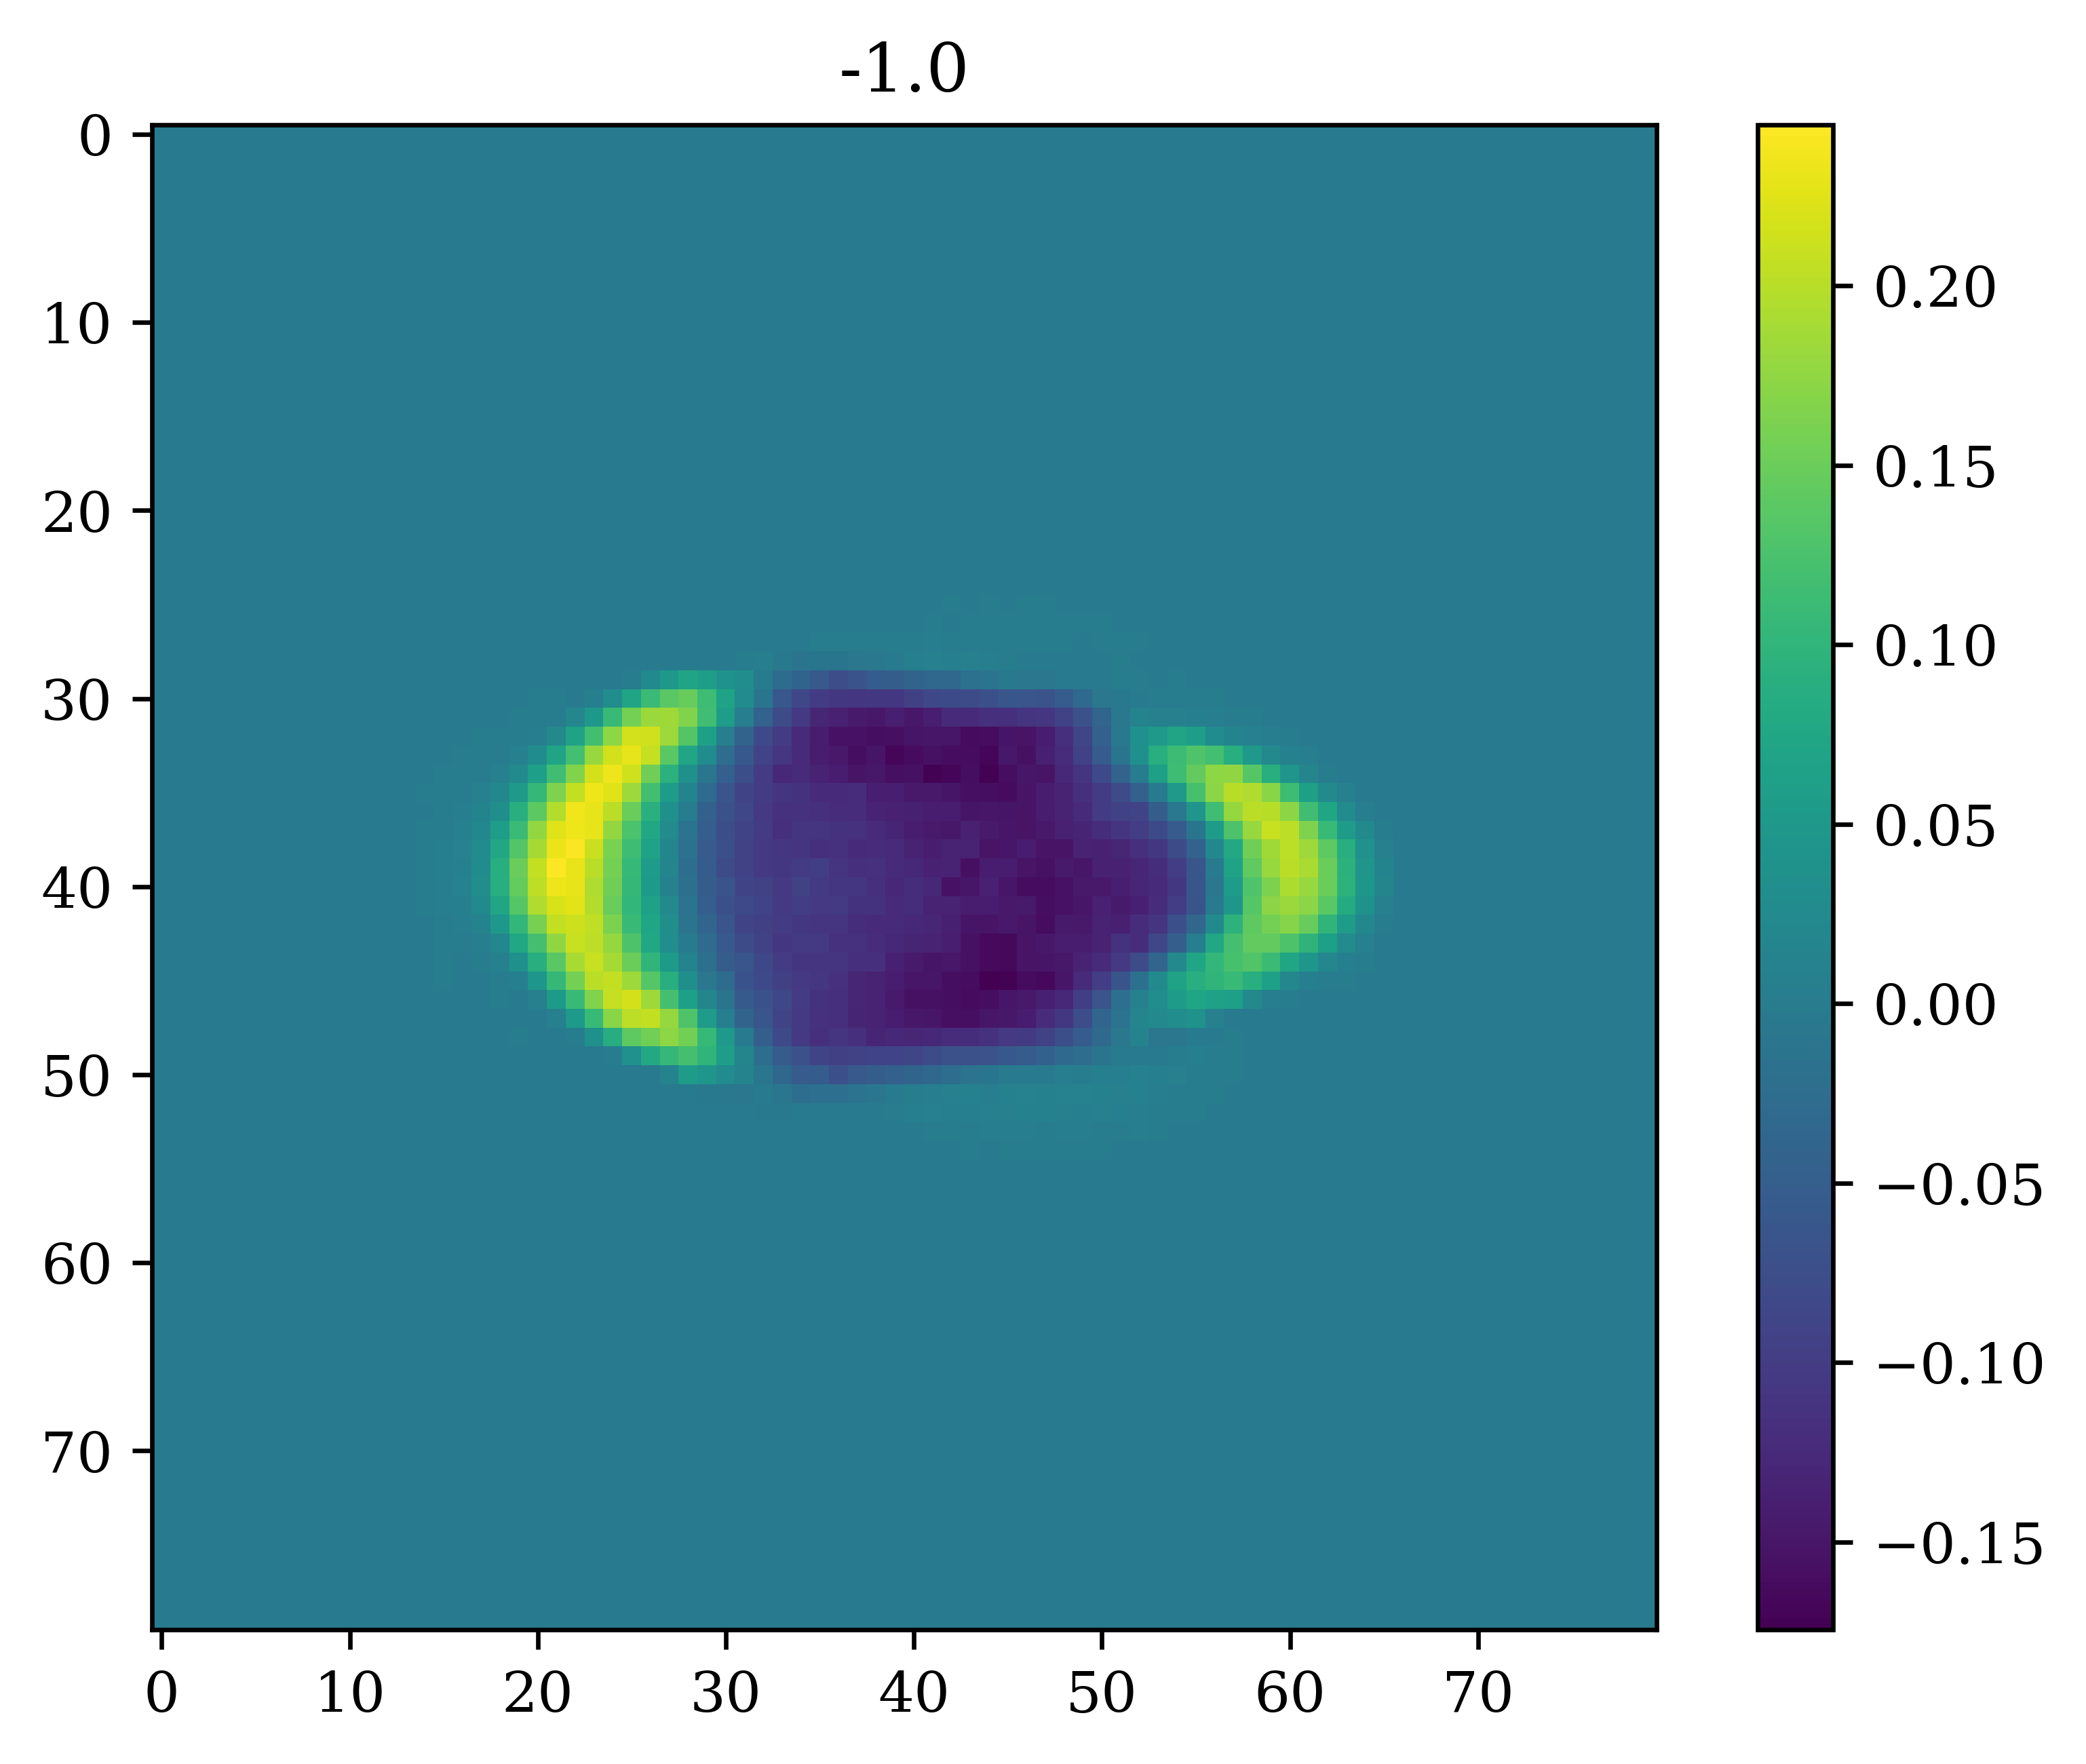

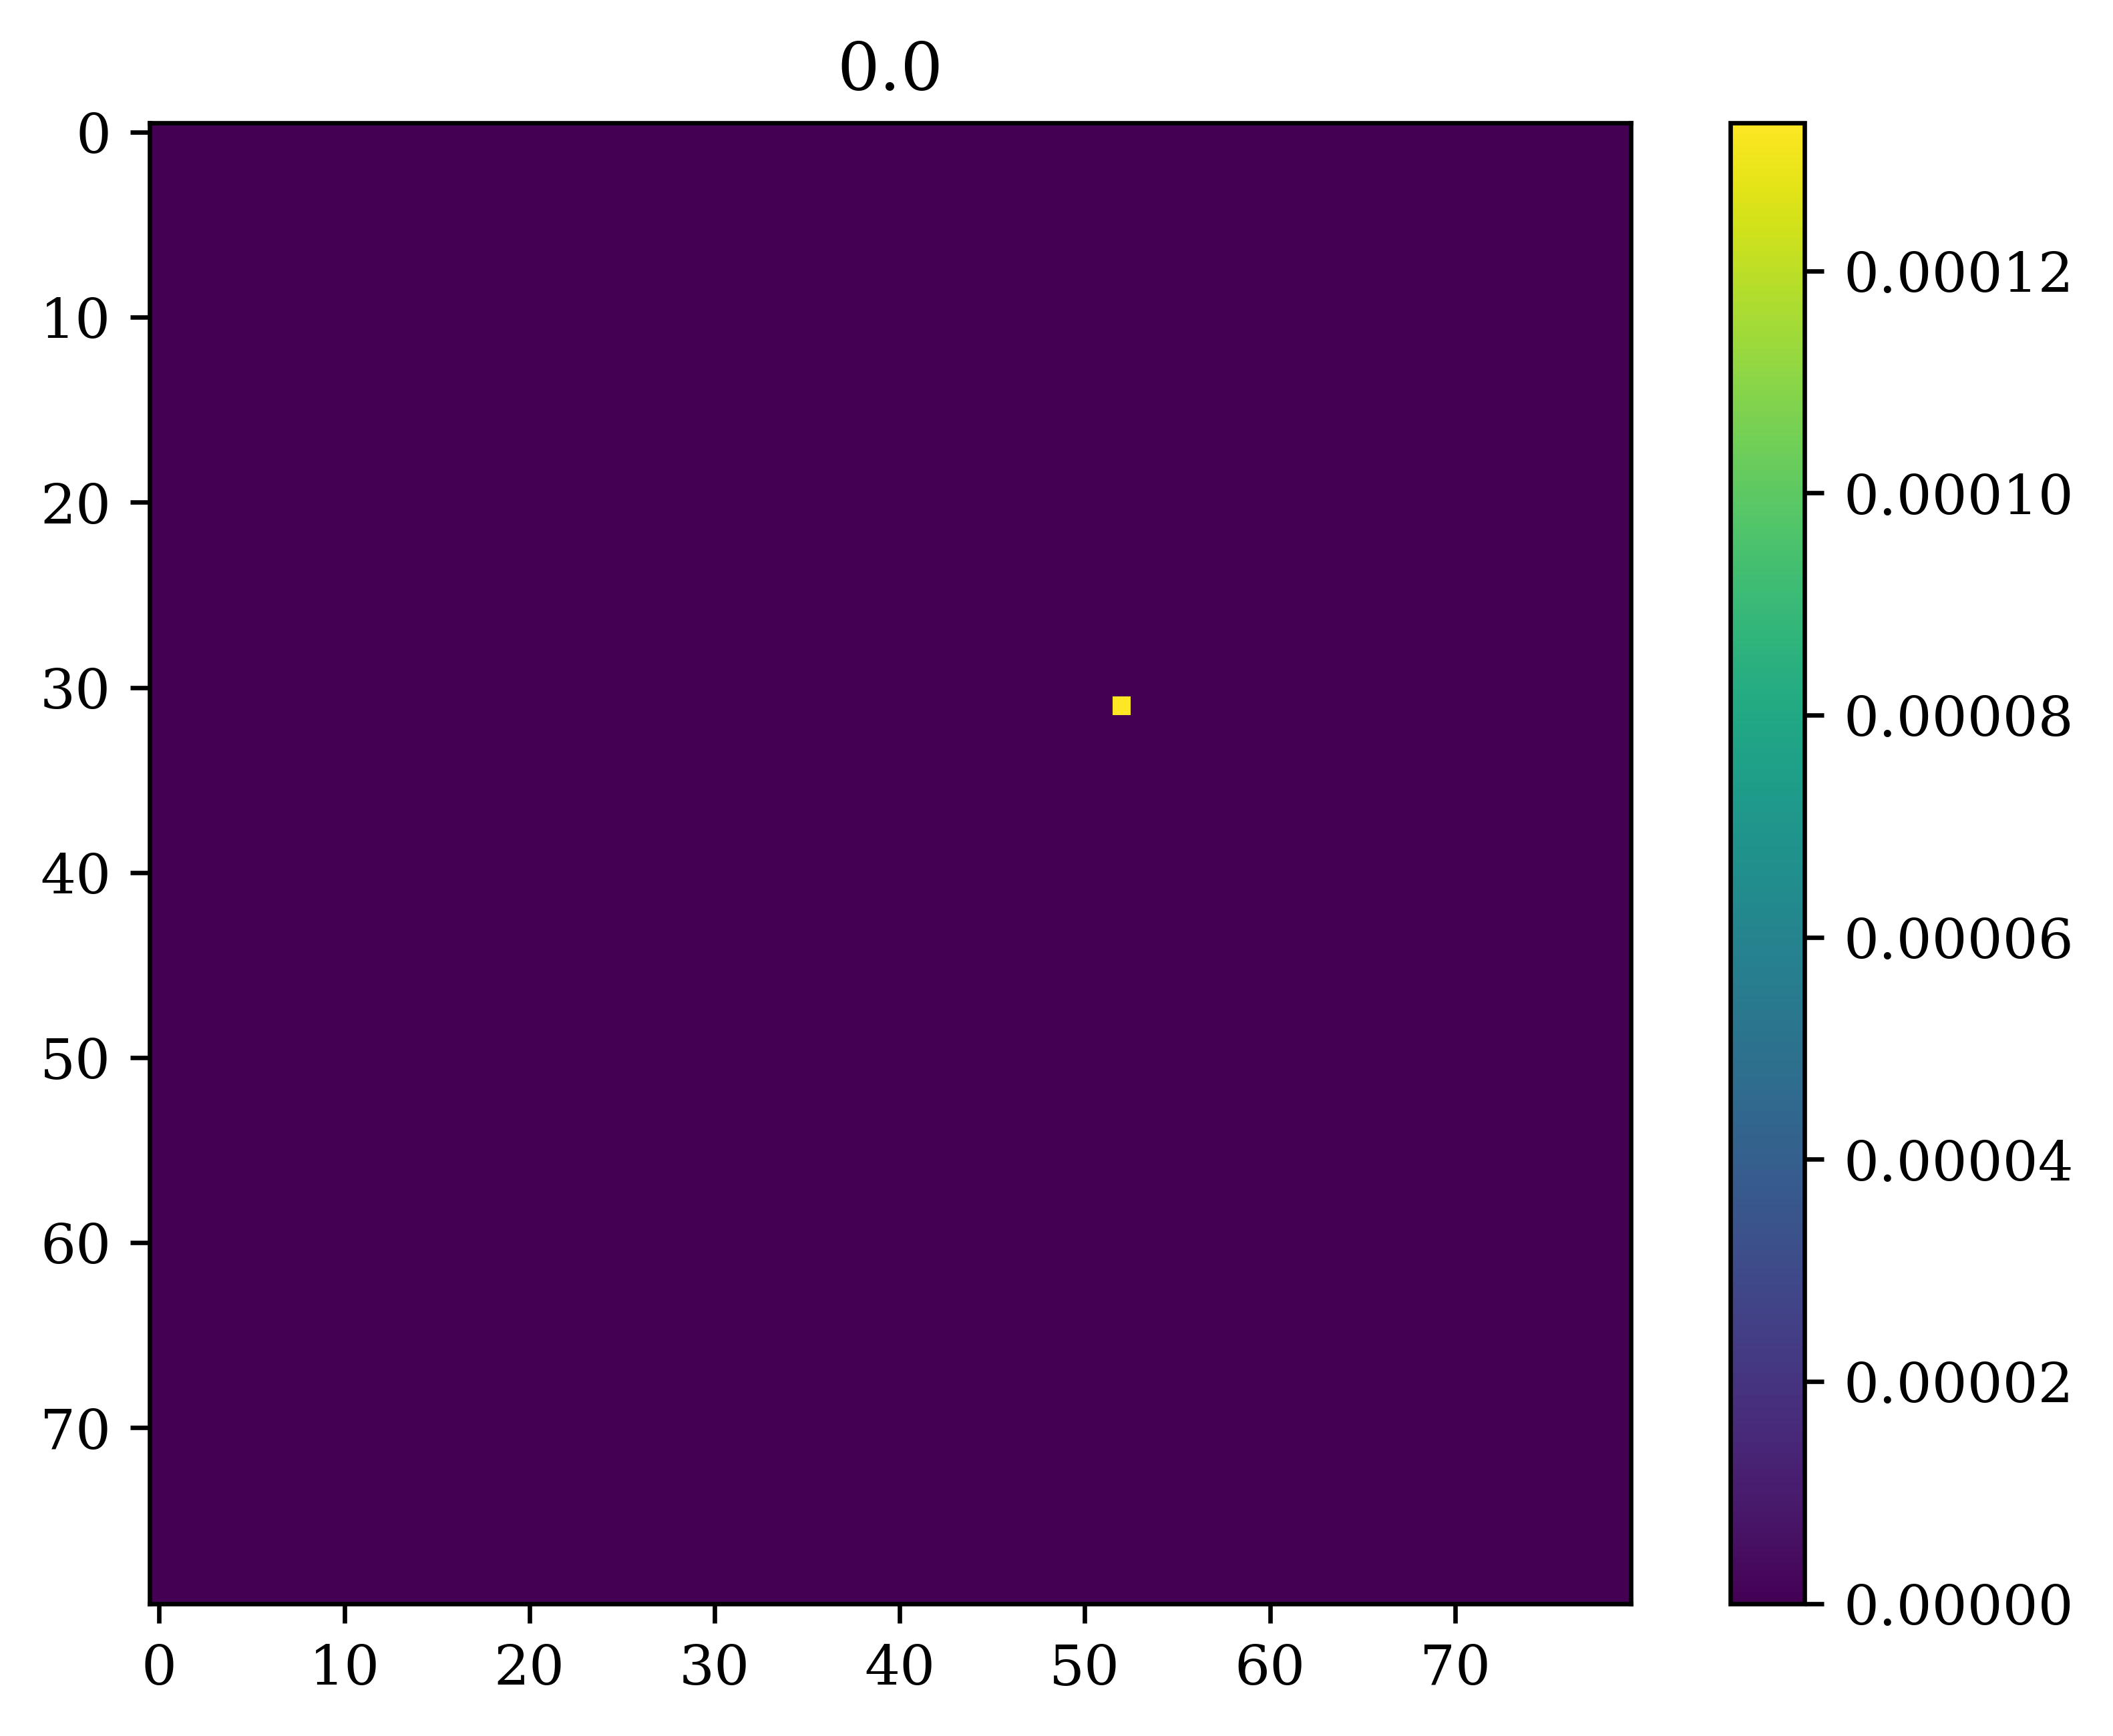

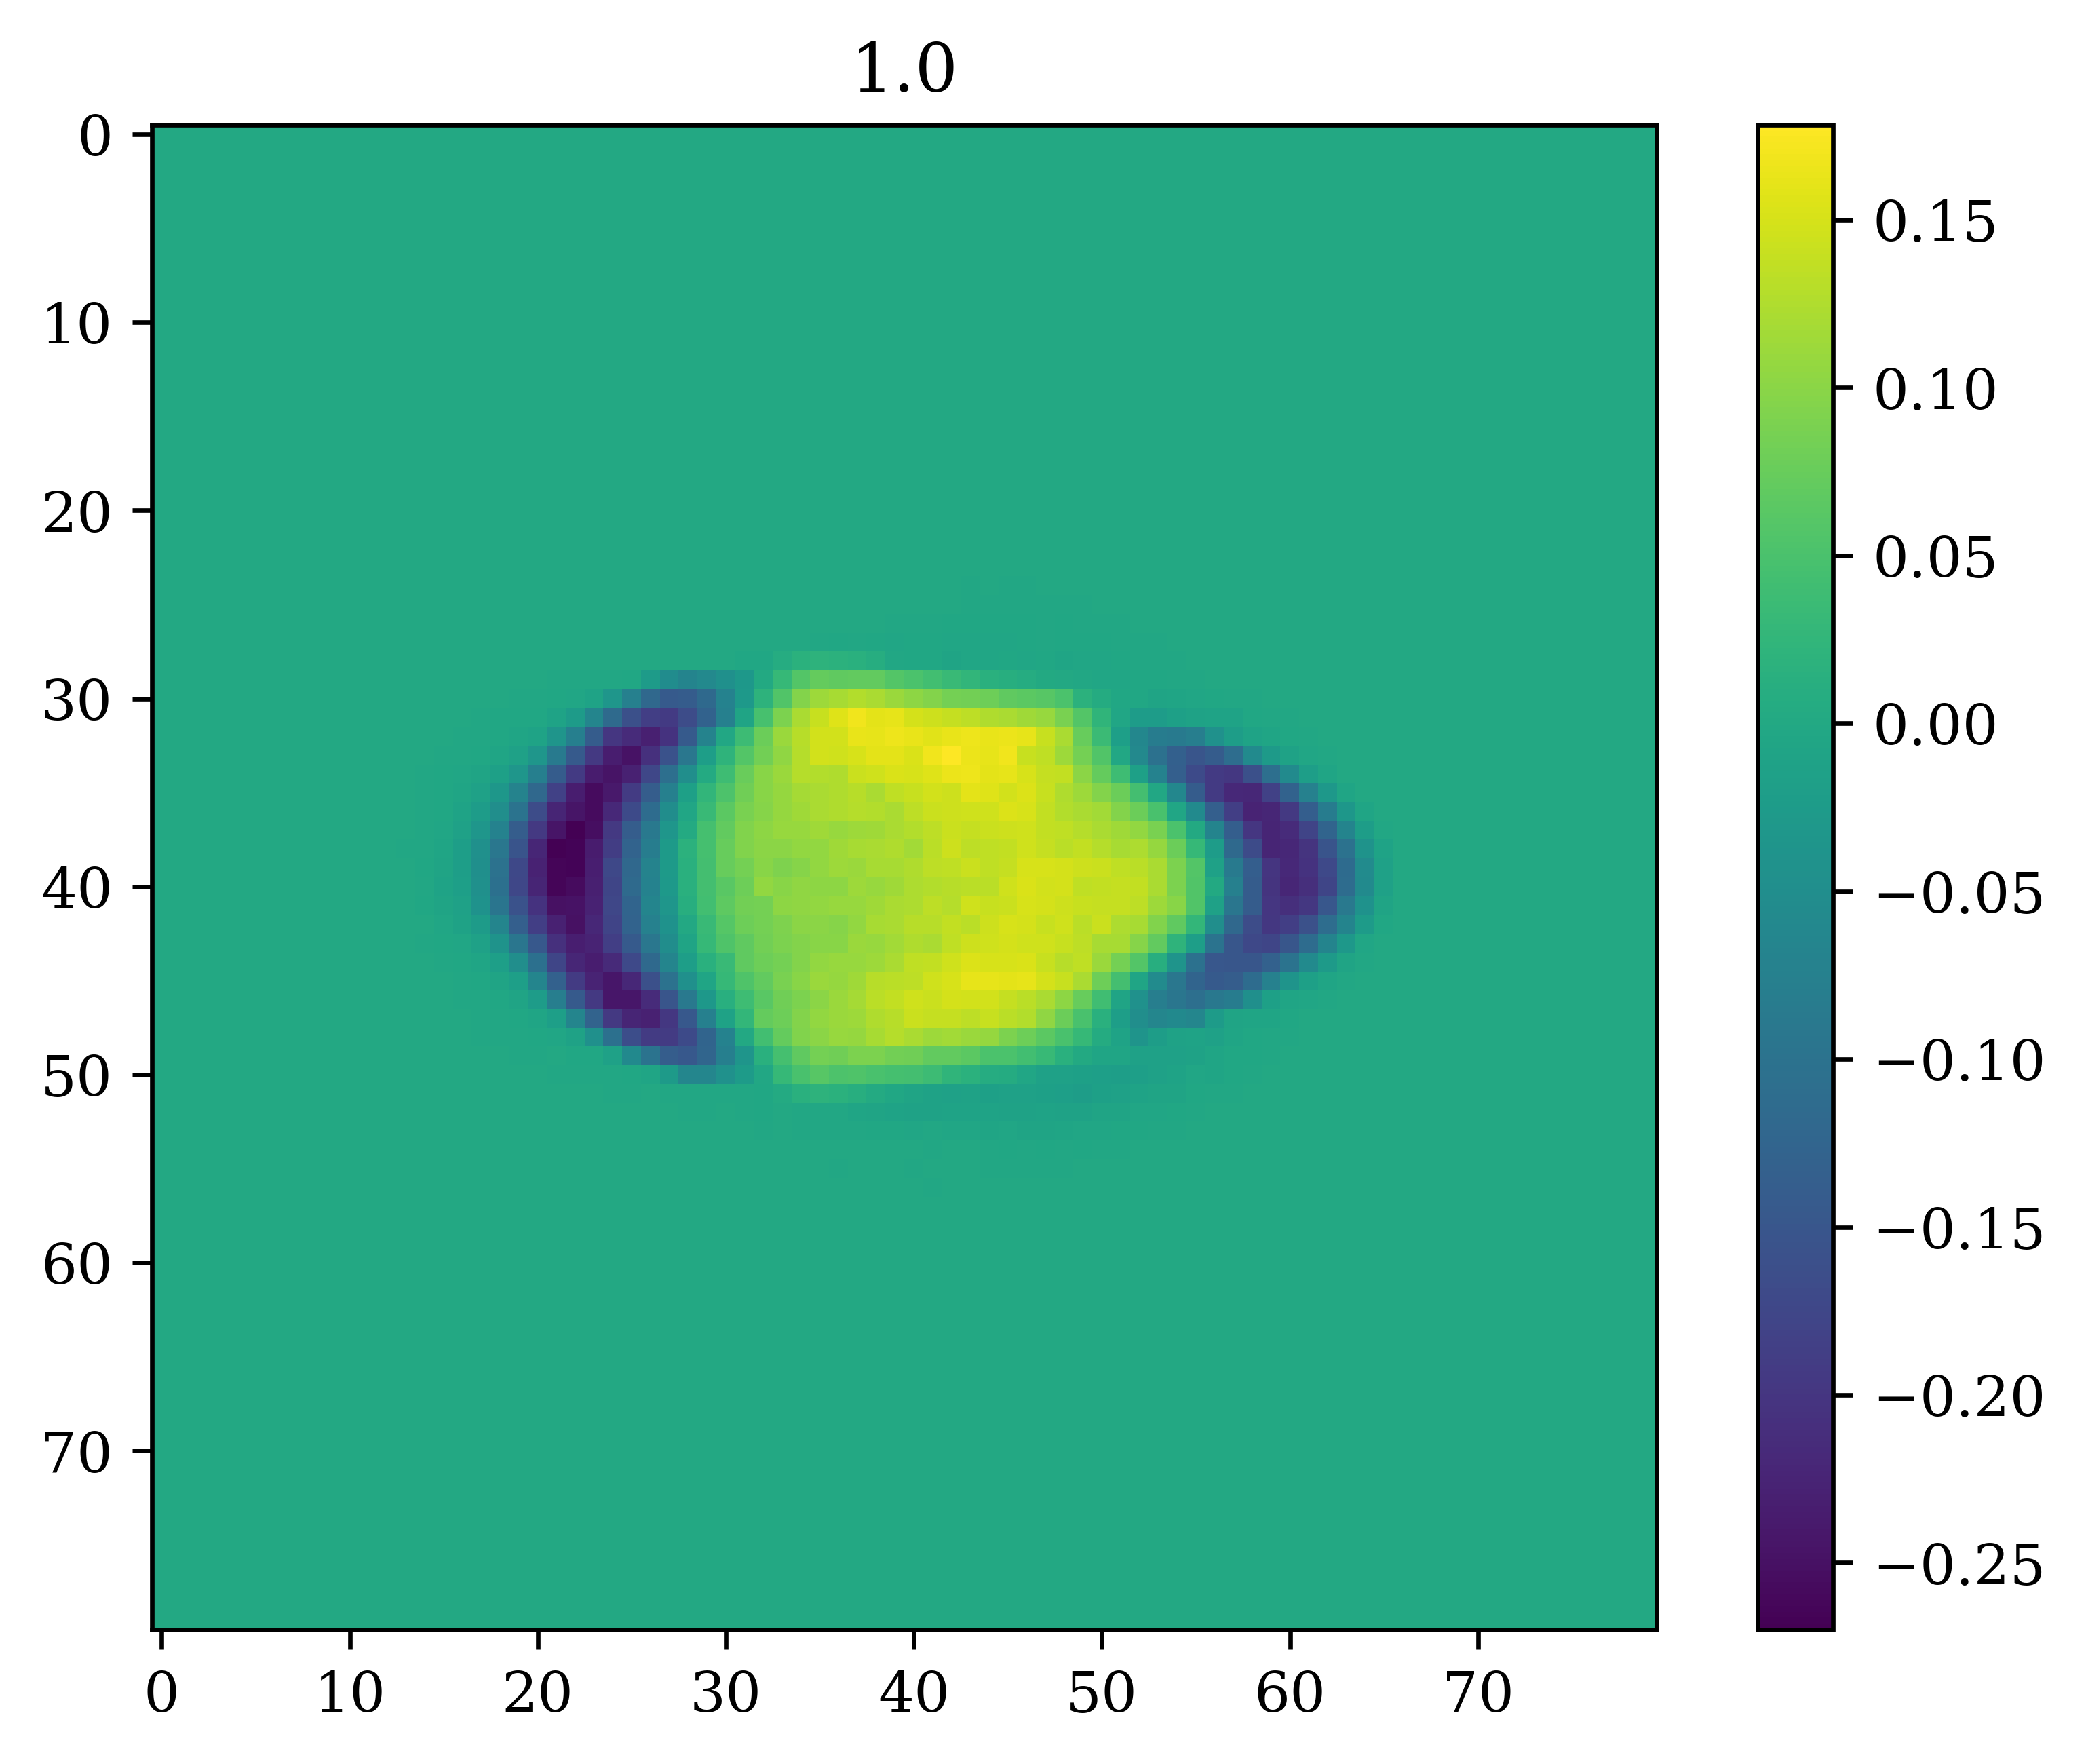

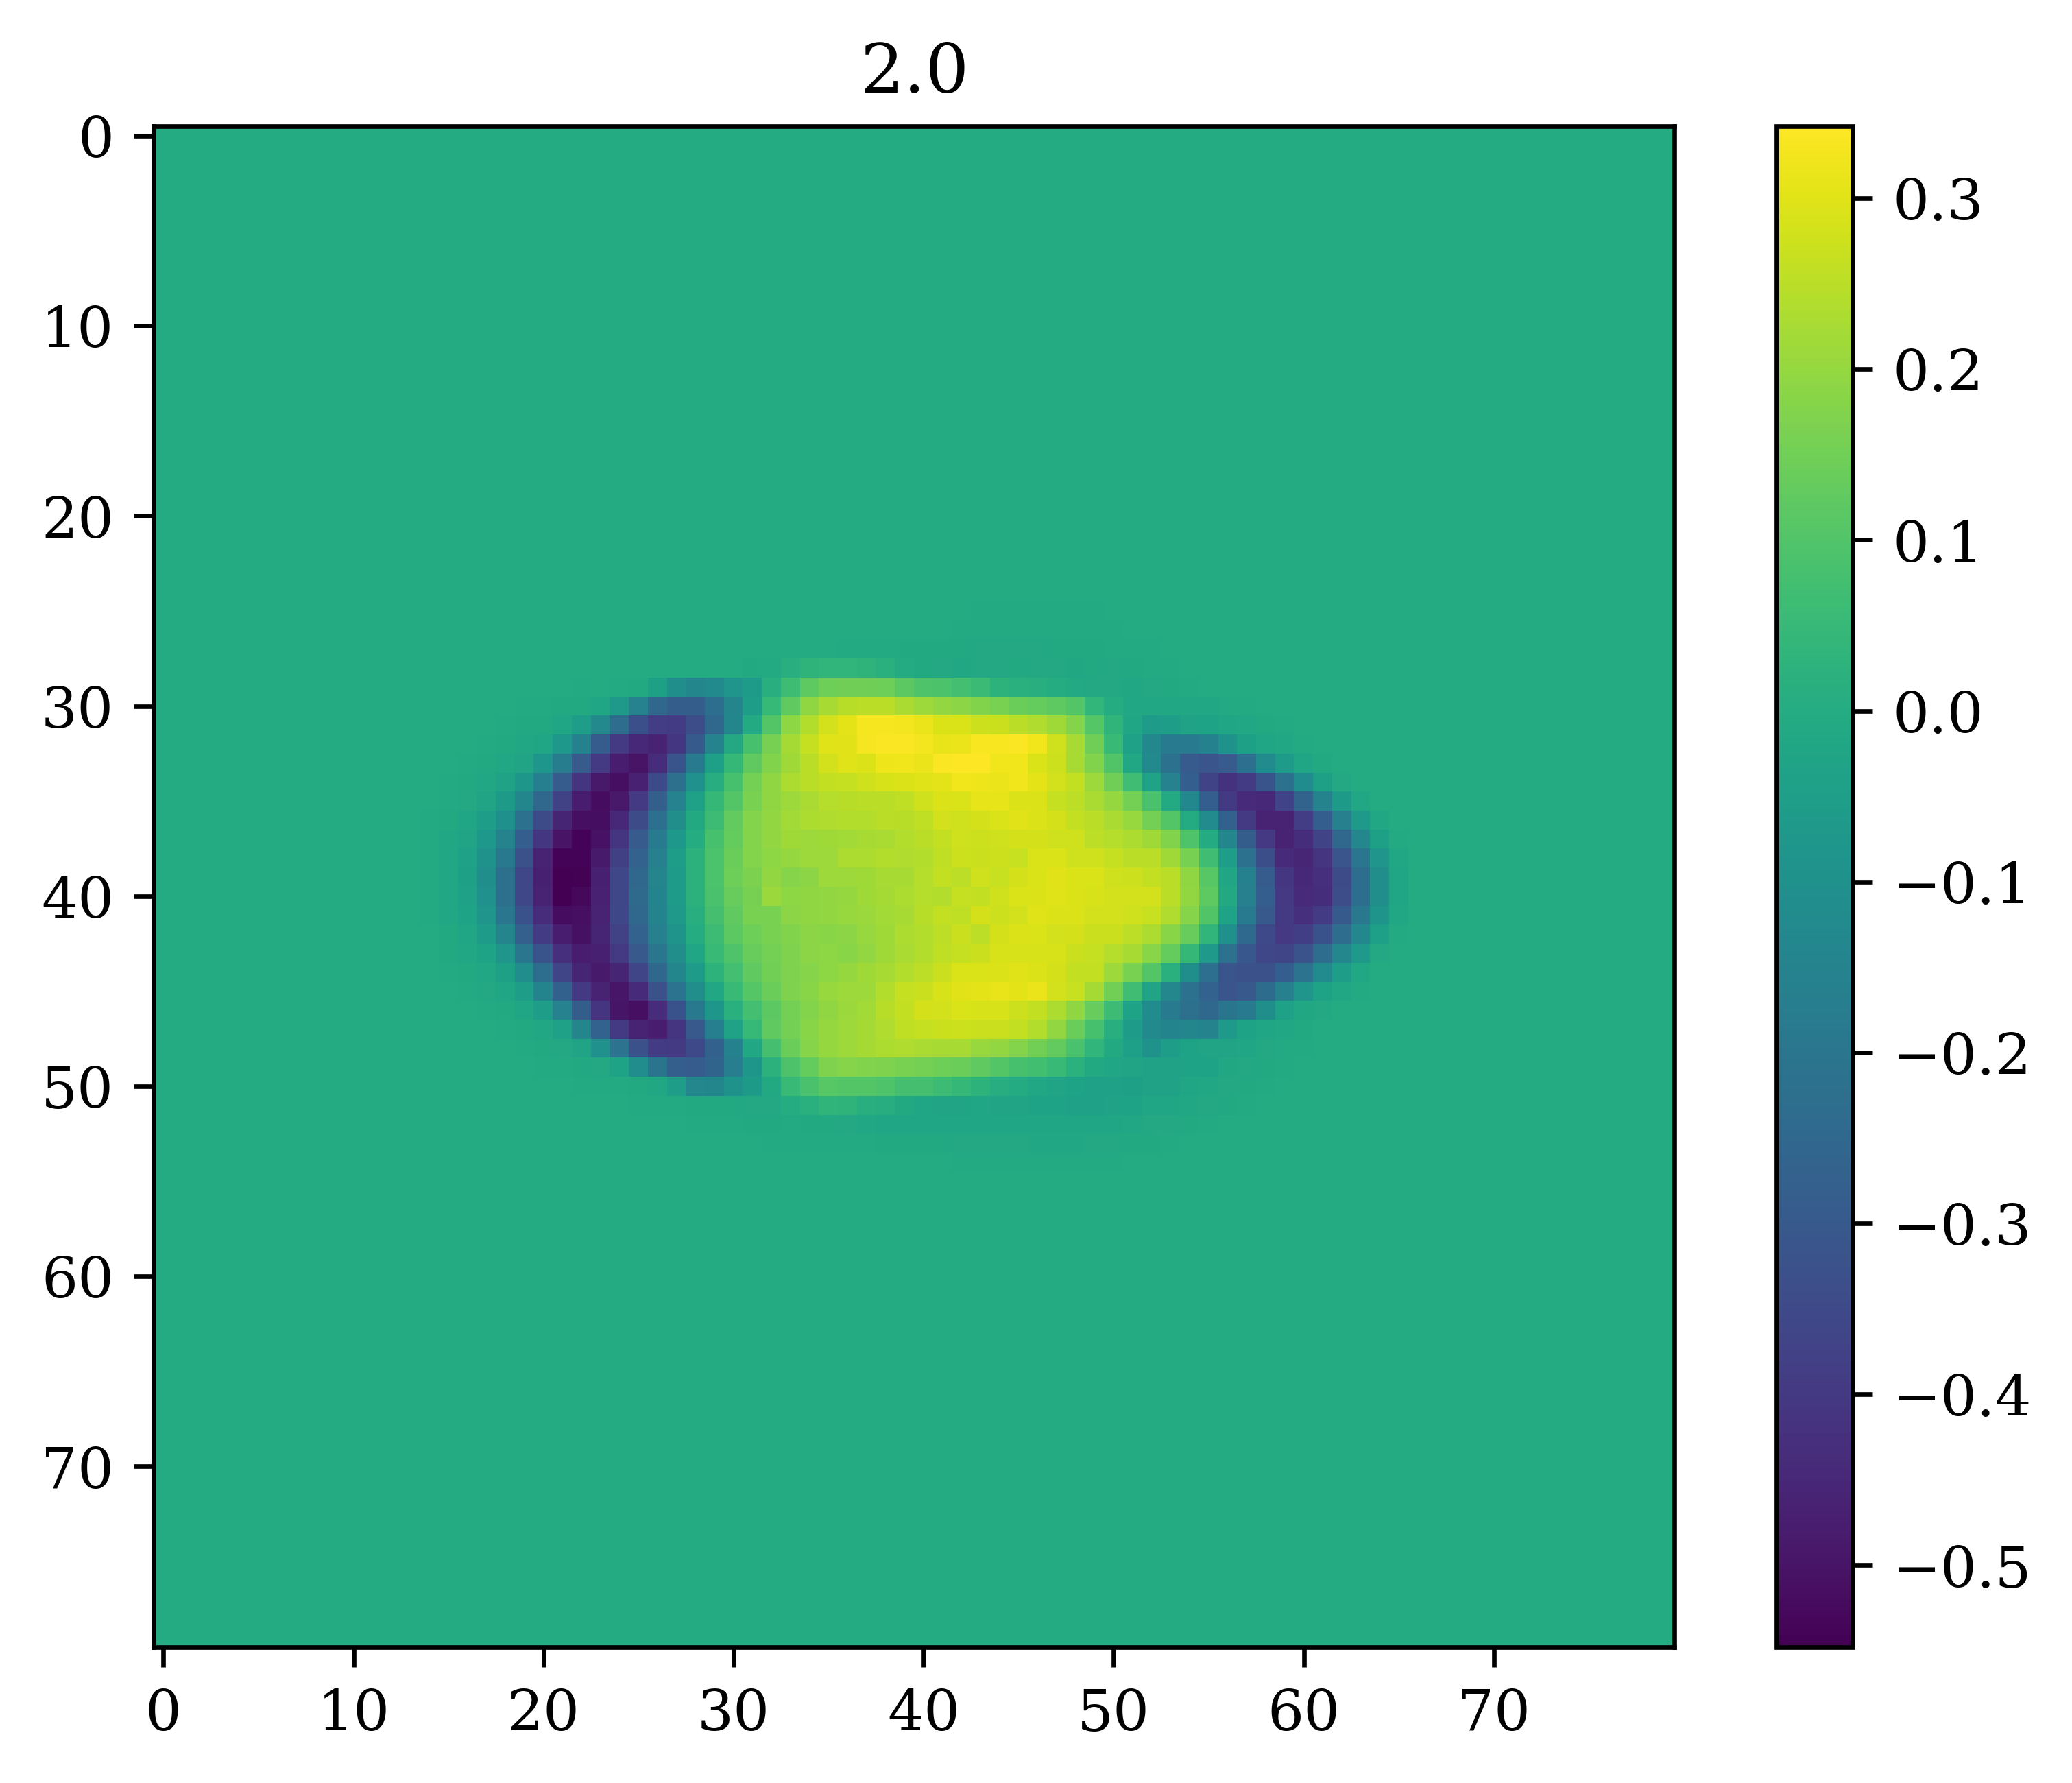

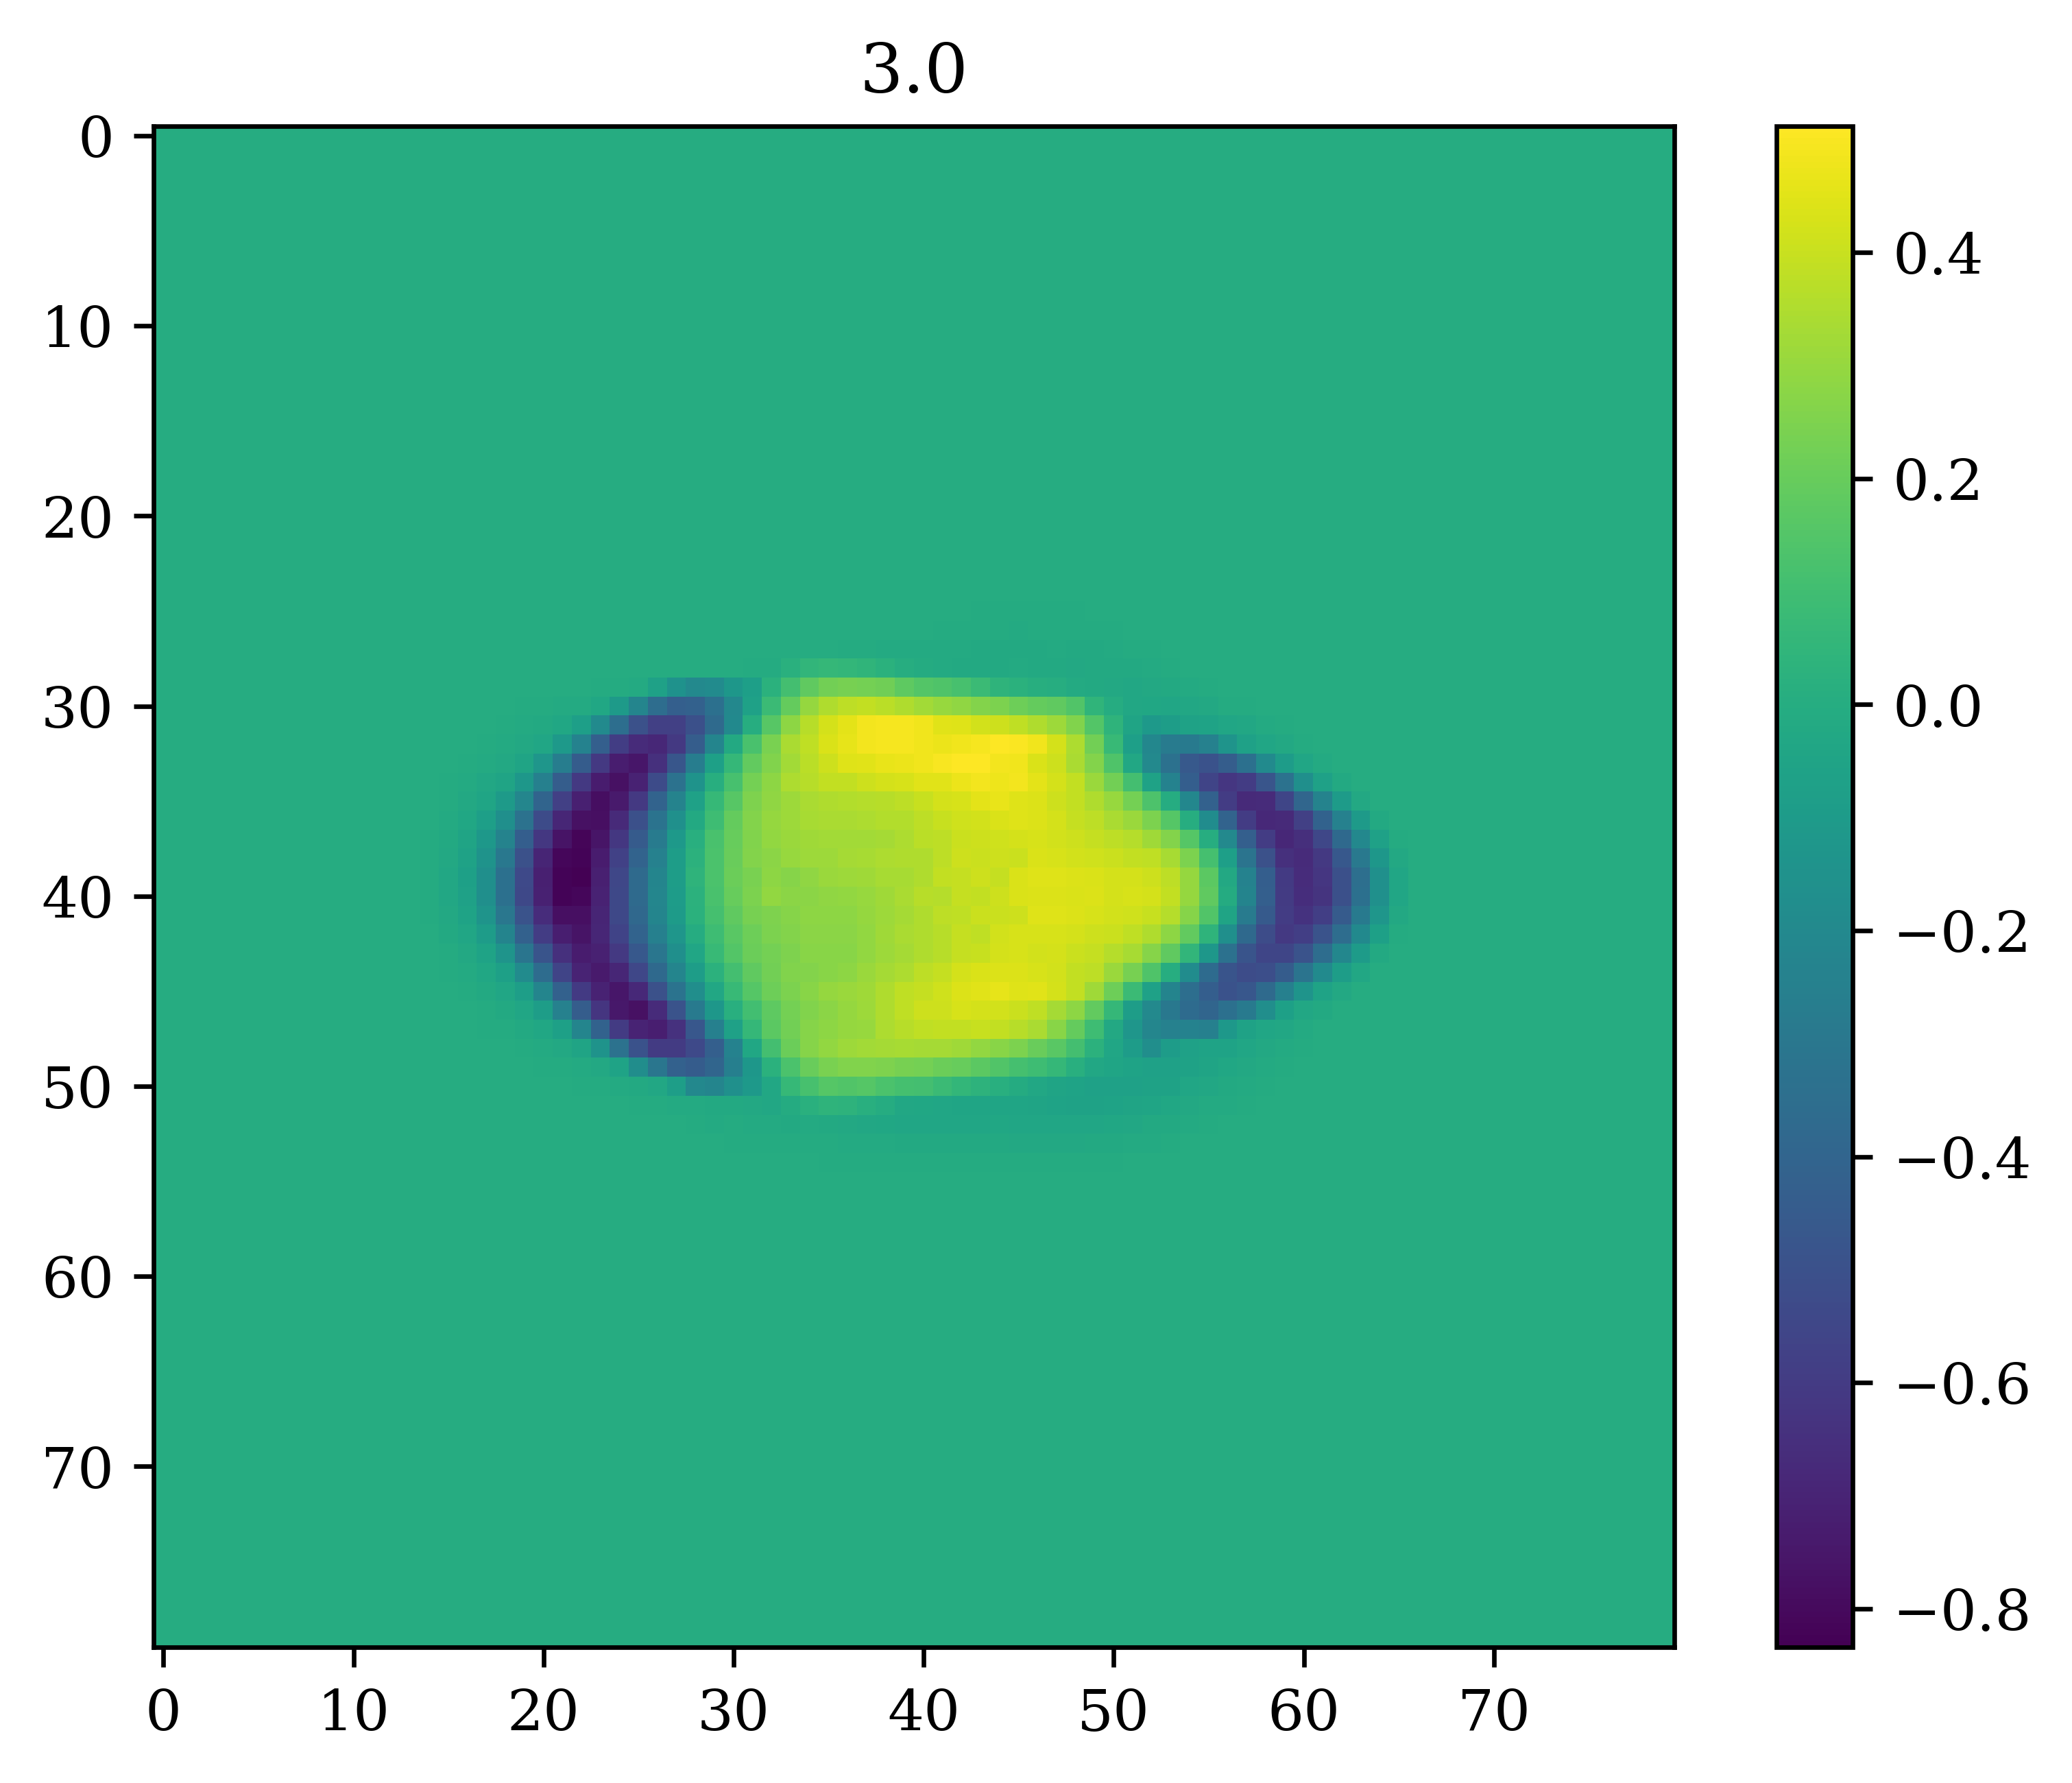

In [20]:
for k, v in offset_poses.items():
    plt.figure()
    plt.imshow(v)
    plt.colorbar()
    plt.title(k)

In [21]:
animal = males[12][0]

with h5py.File(animal, 'r') as h5f:
    frames = h5f['frames'][:7_500]

In [22]:
out = predict_and_return(model, frames, clean_noise=True)

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
offset_poses = {}
for i in np.linspace(-3, 3, 7):
    out_offset = predict_and_return(model, frames, height_offset=i, clean_noise=True)
    h = out_offset.astype('float32') - out.astype('float32')
    medians = np.mean(h, 0)
    offset_poses[i] = medians

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

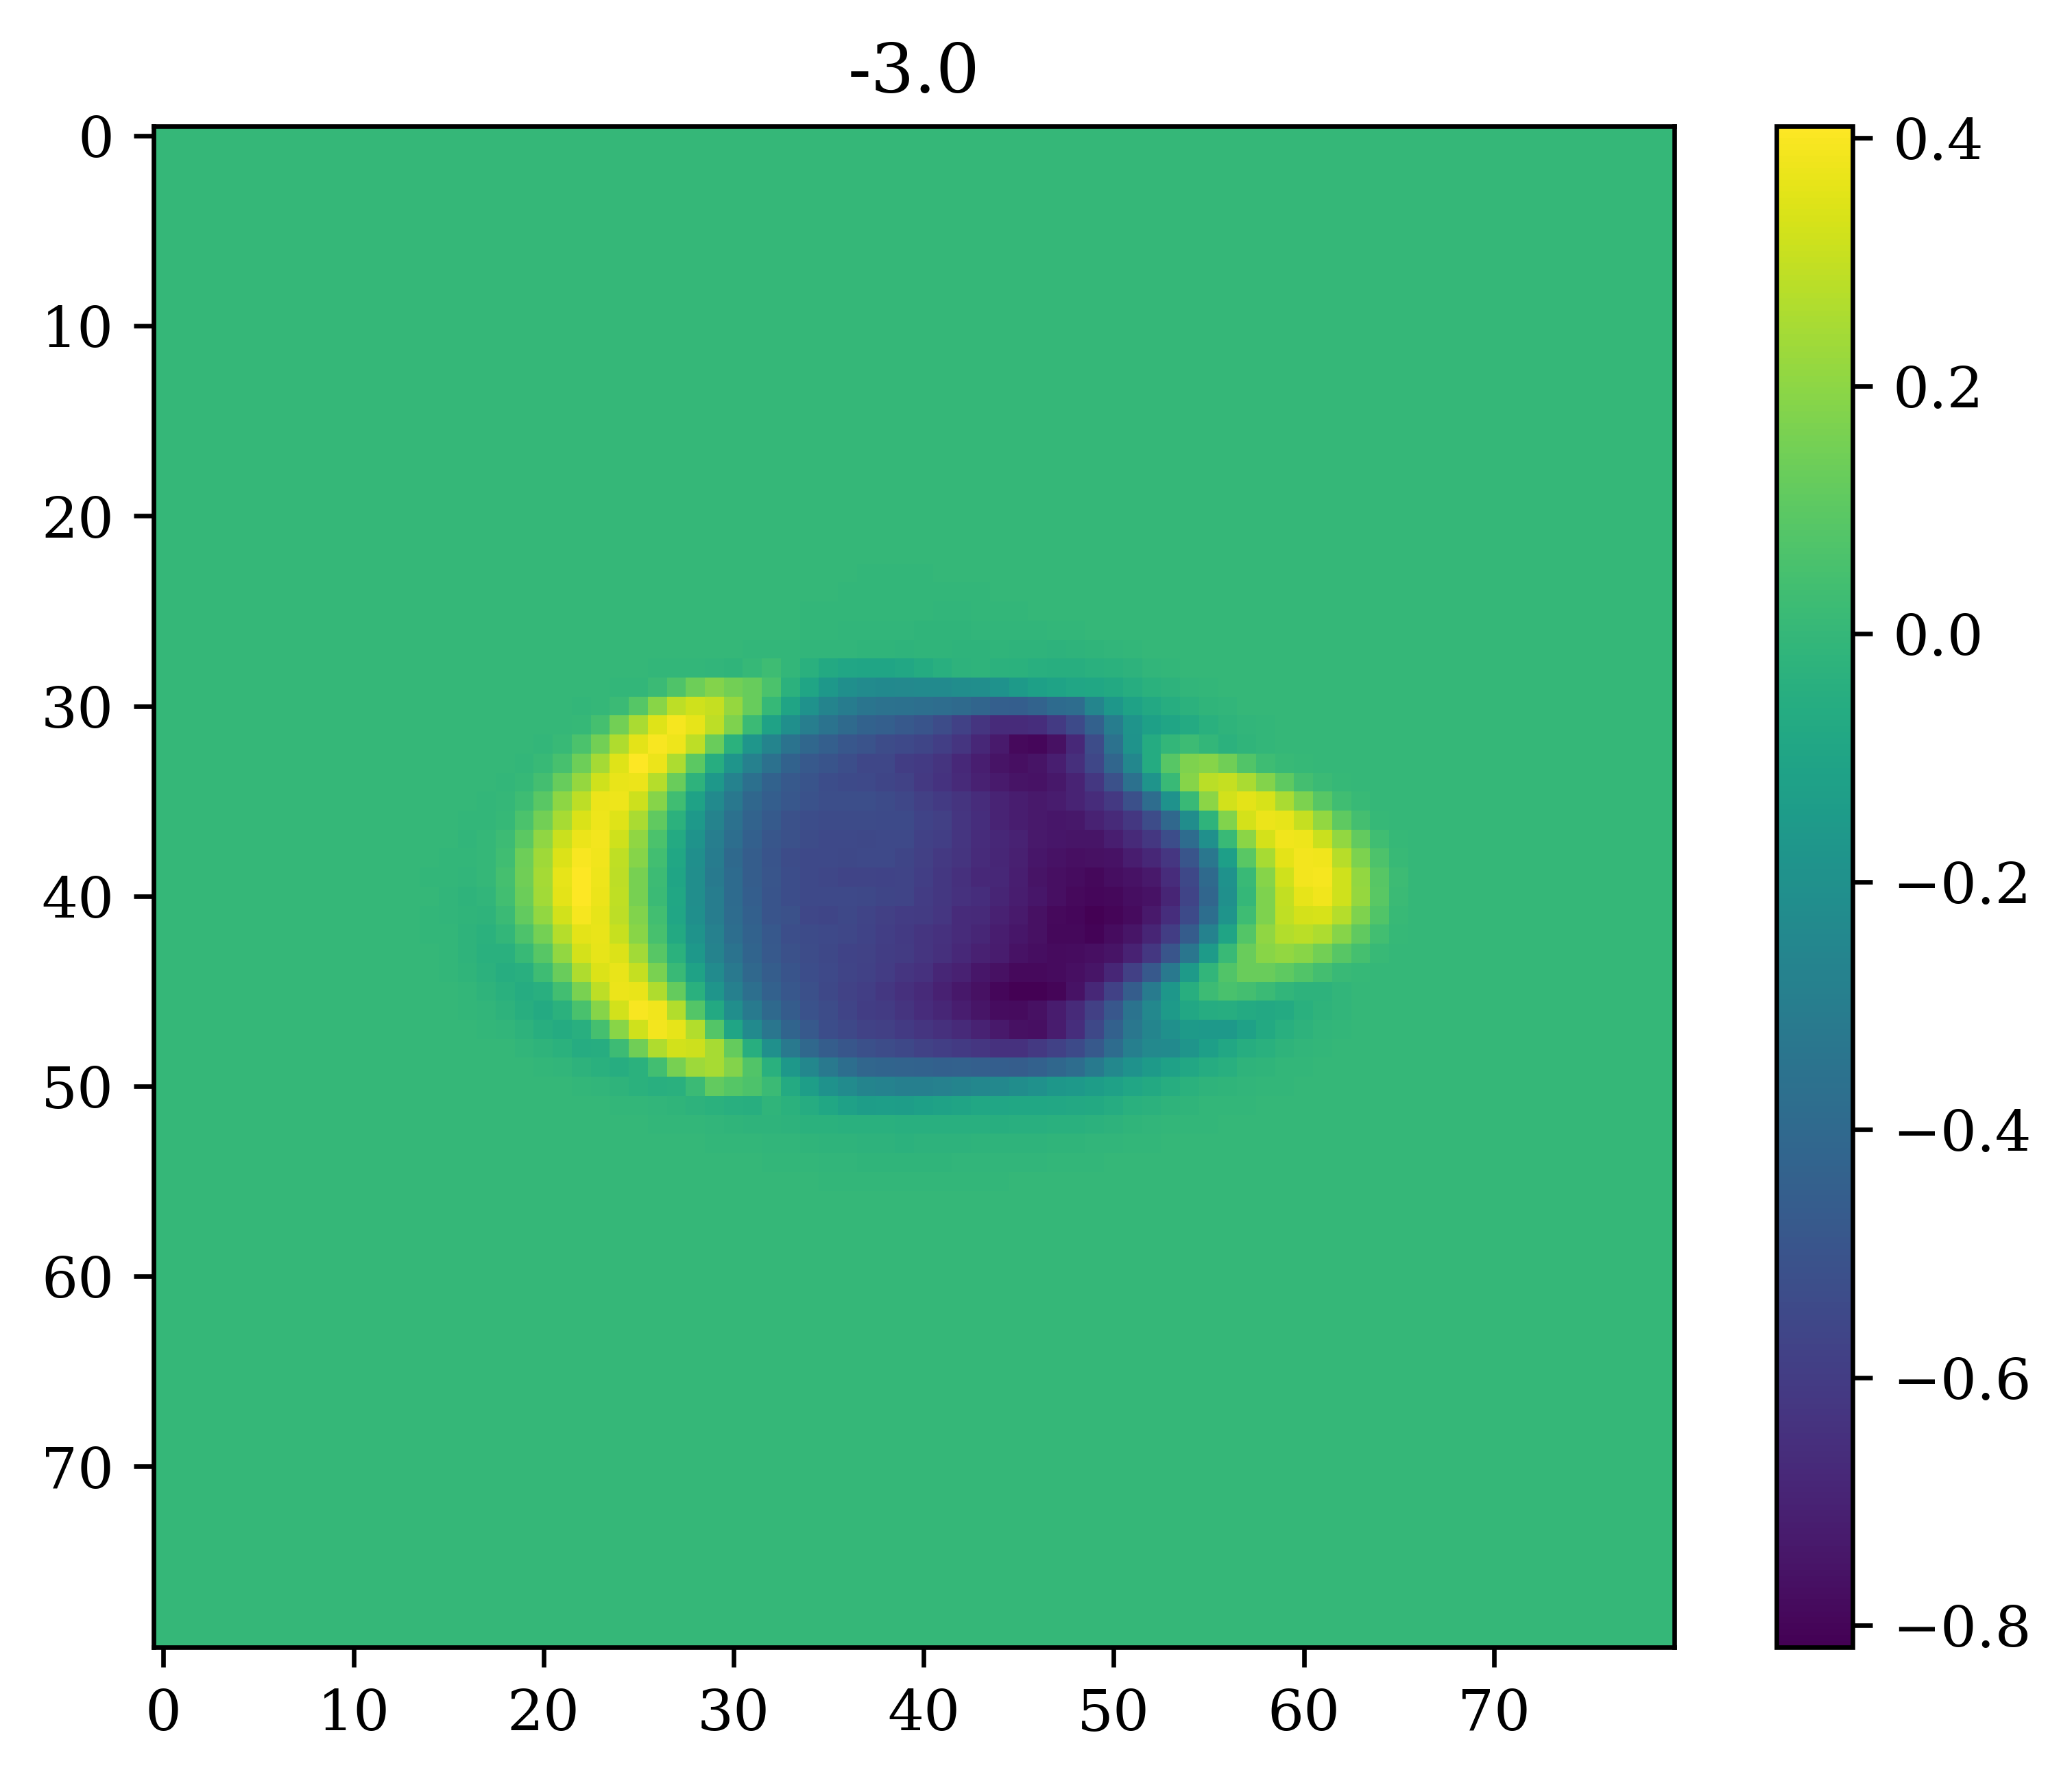

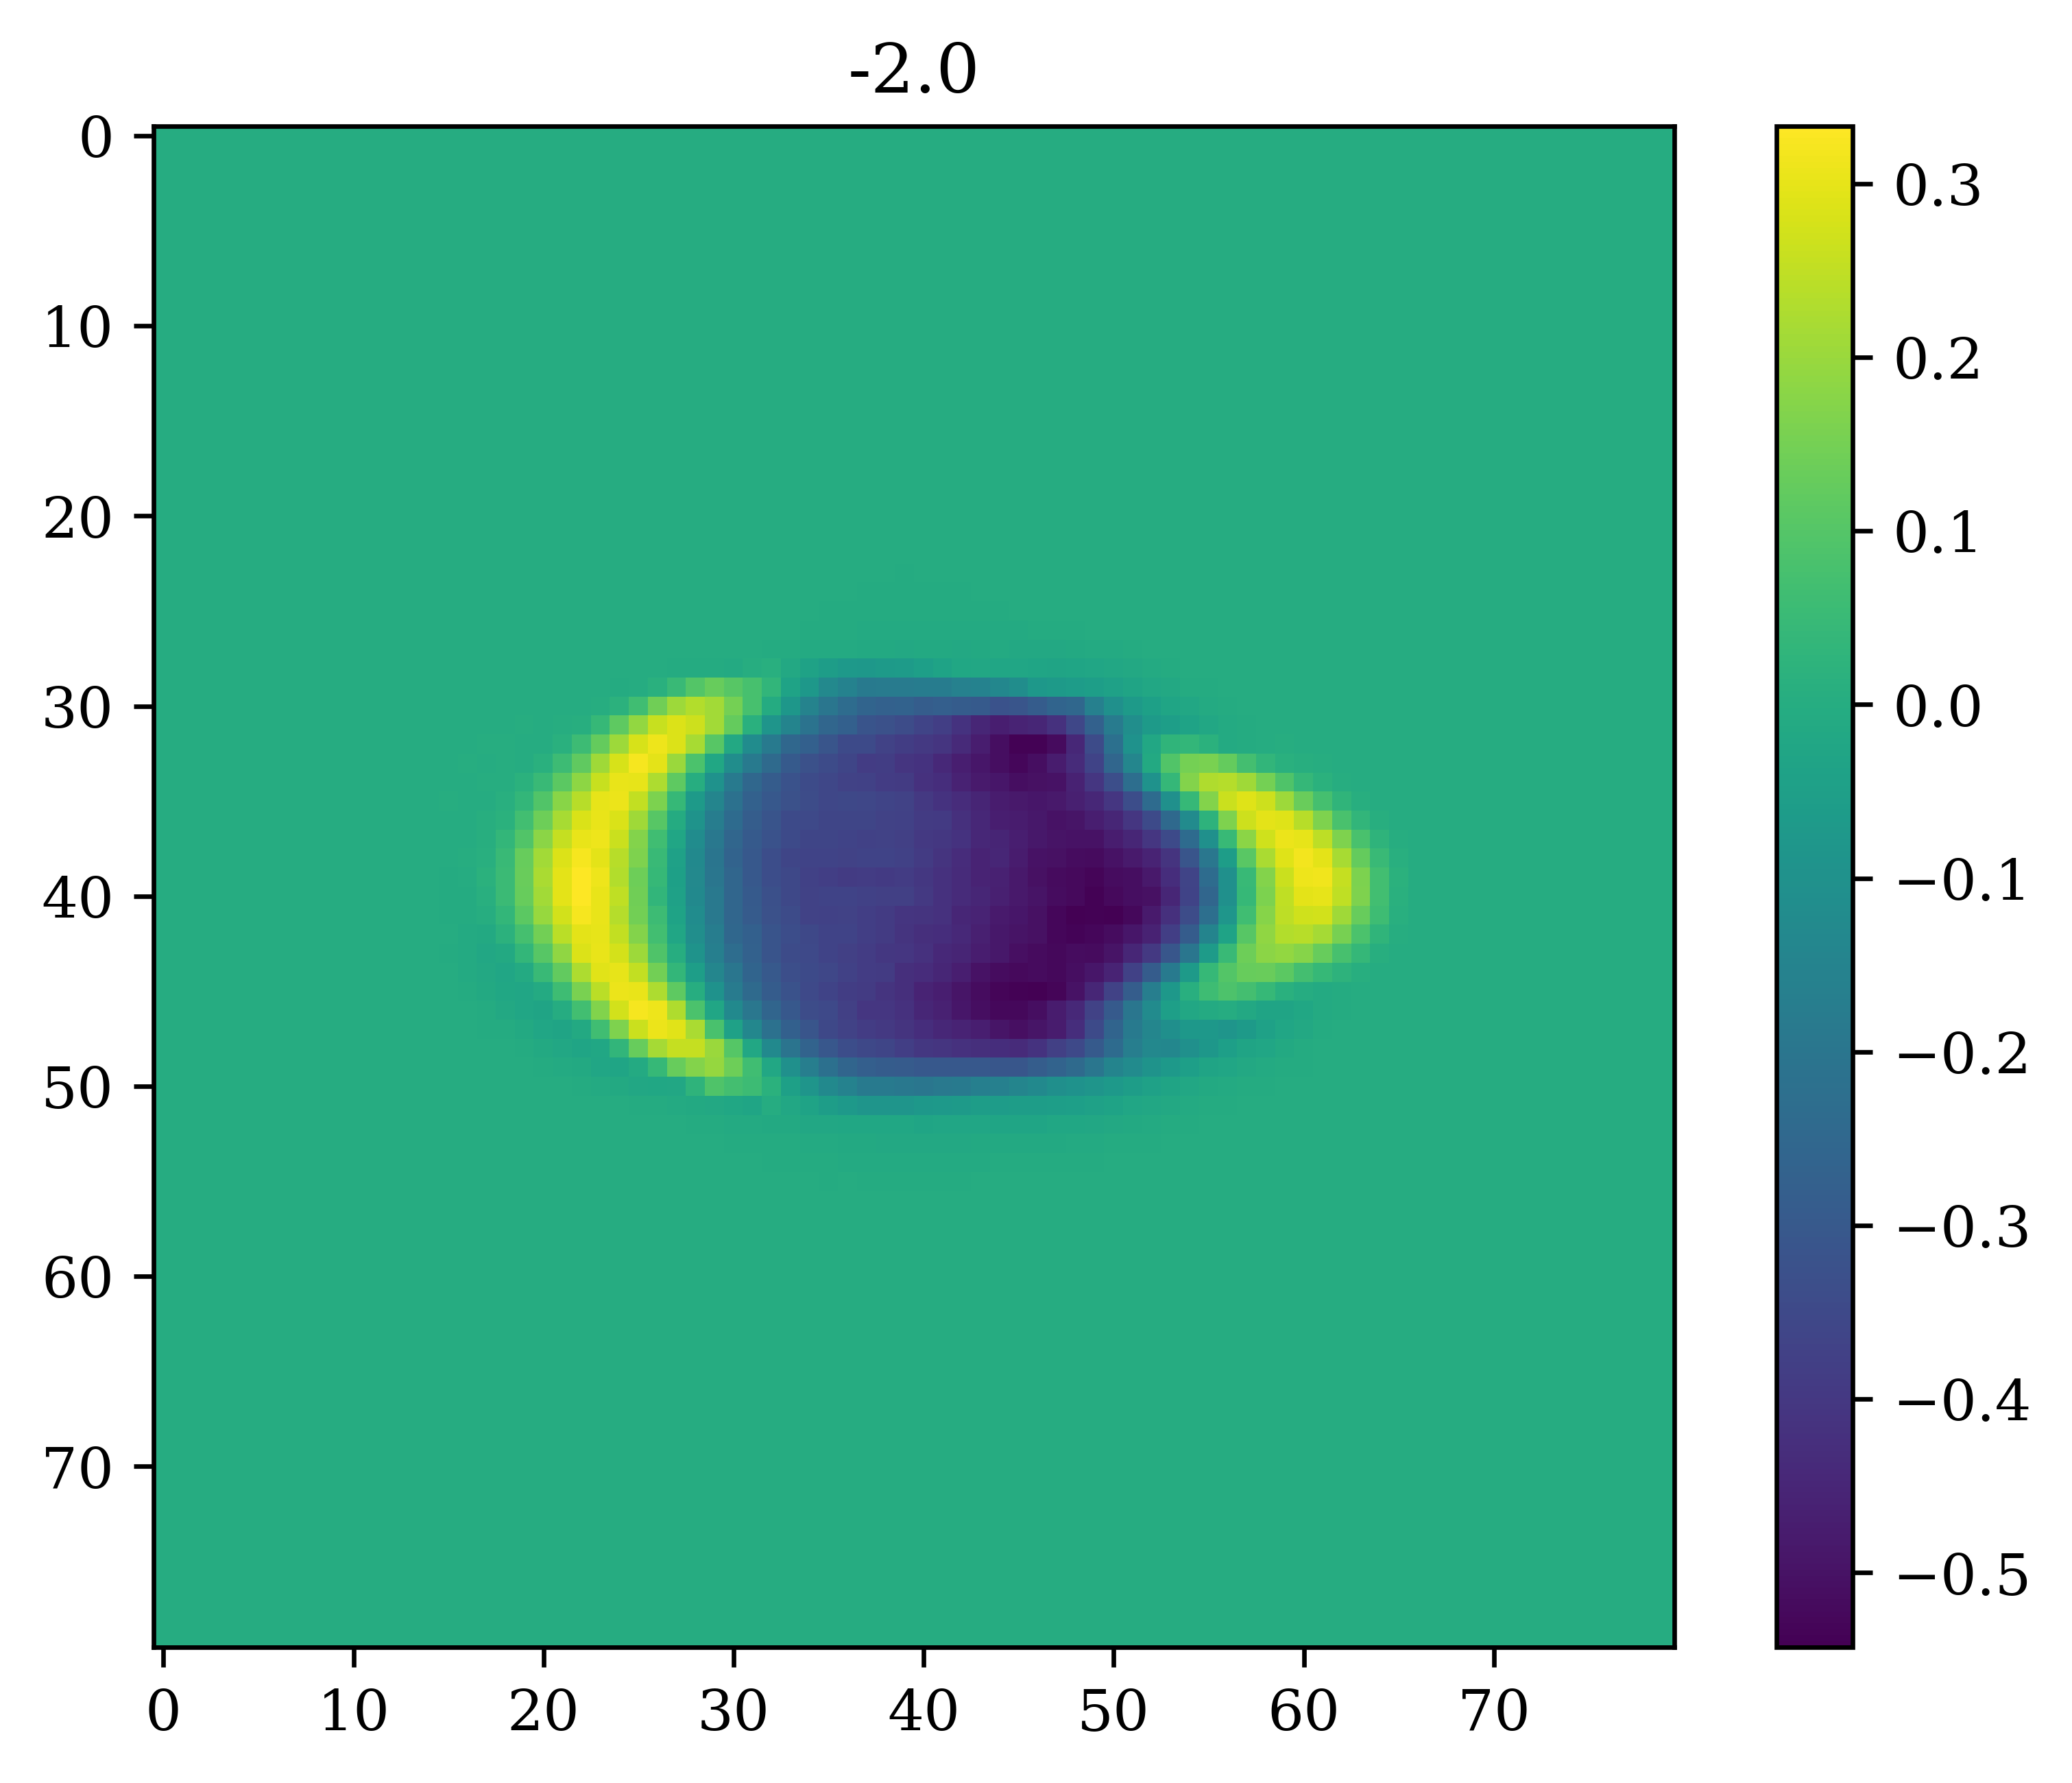

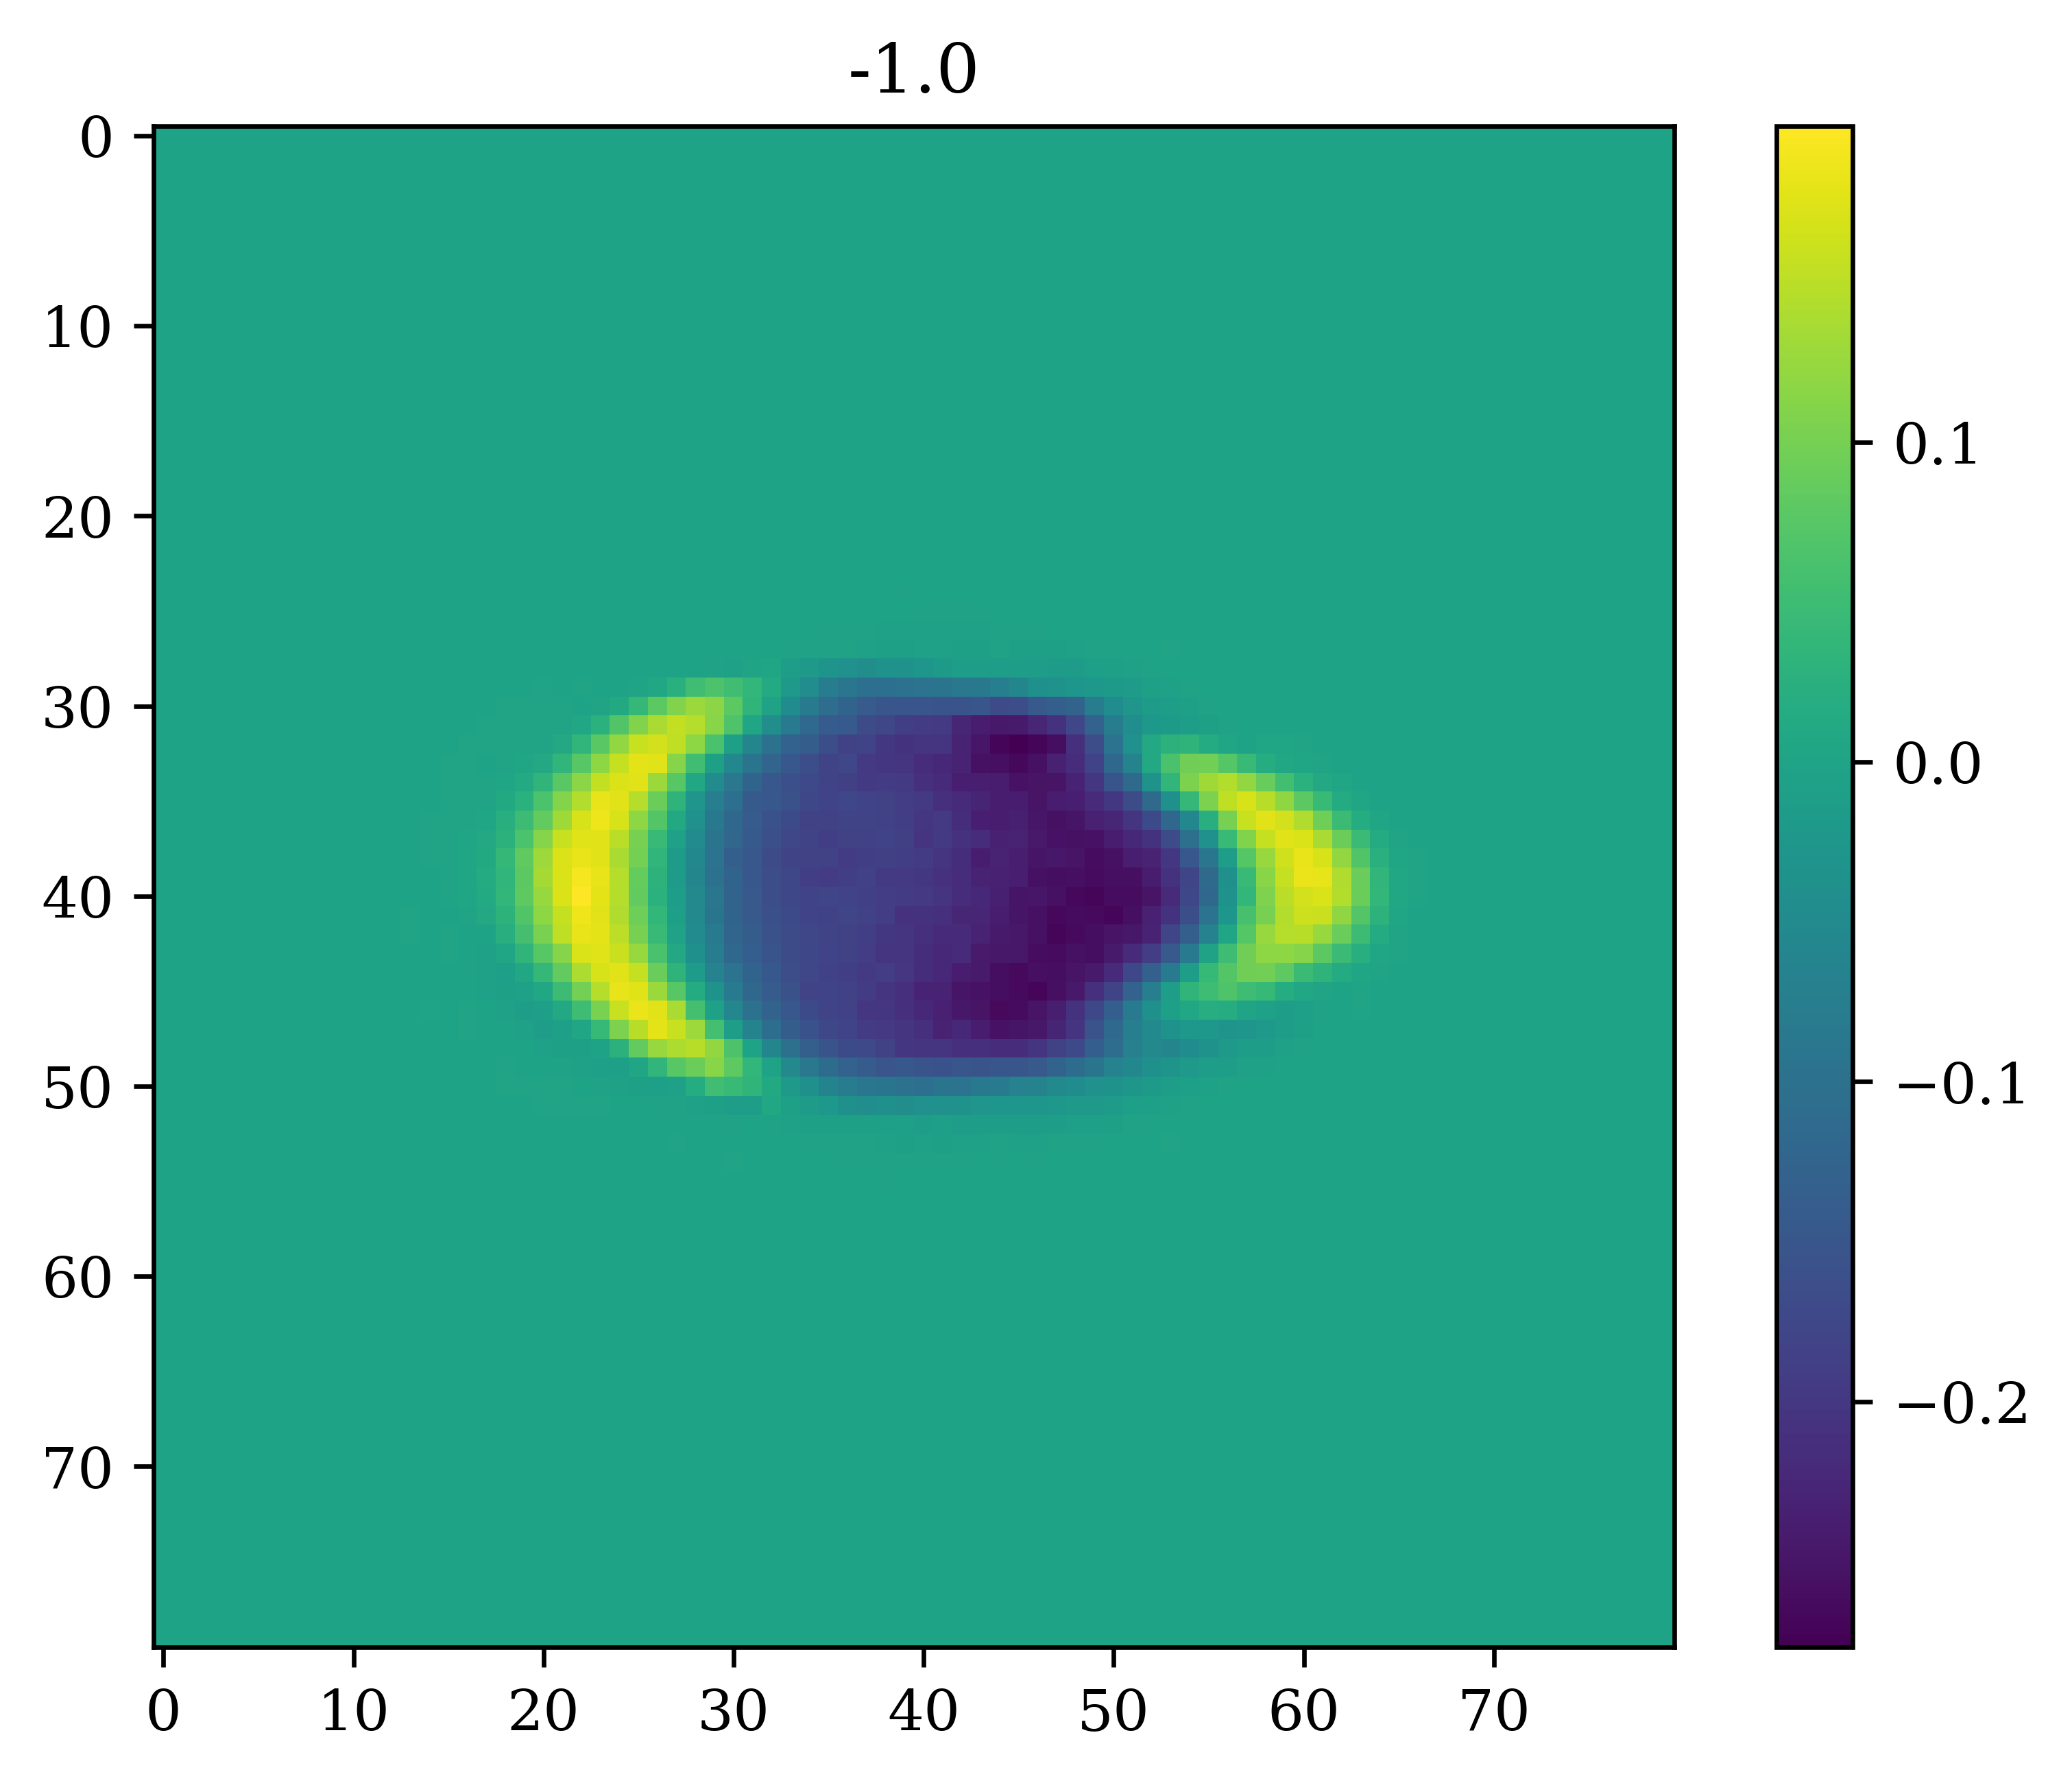

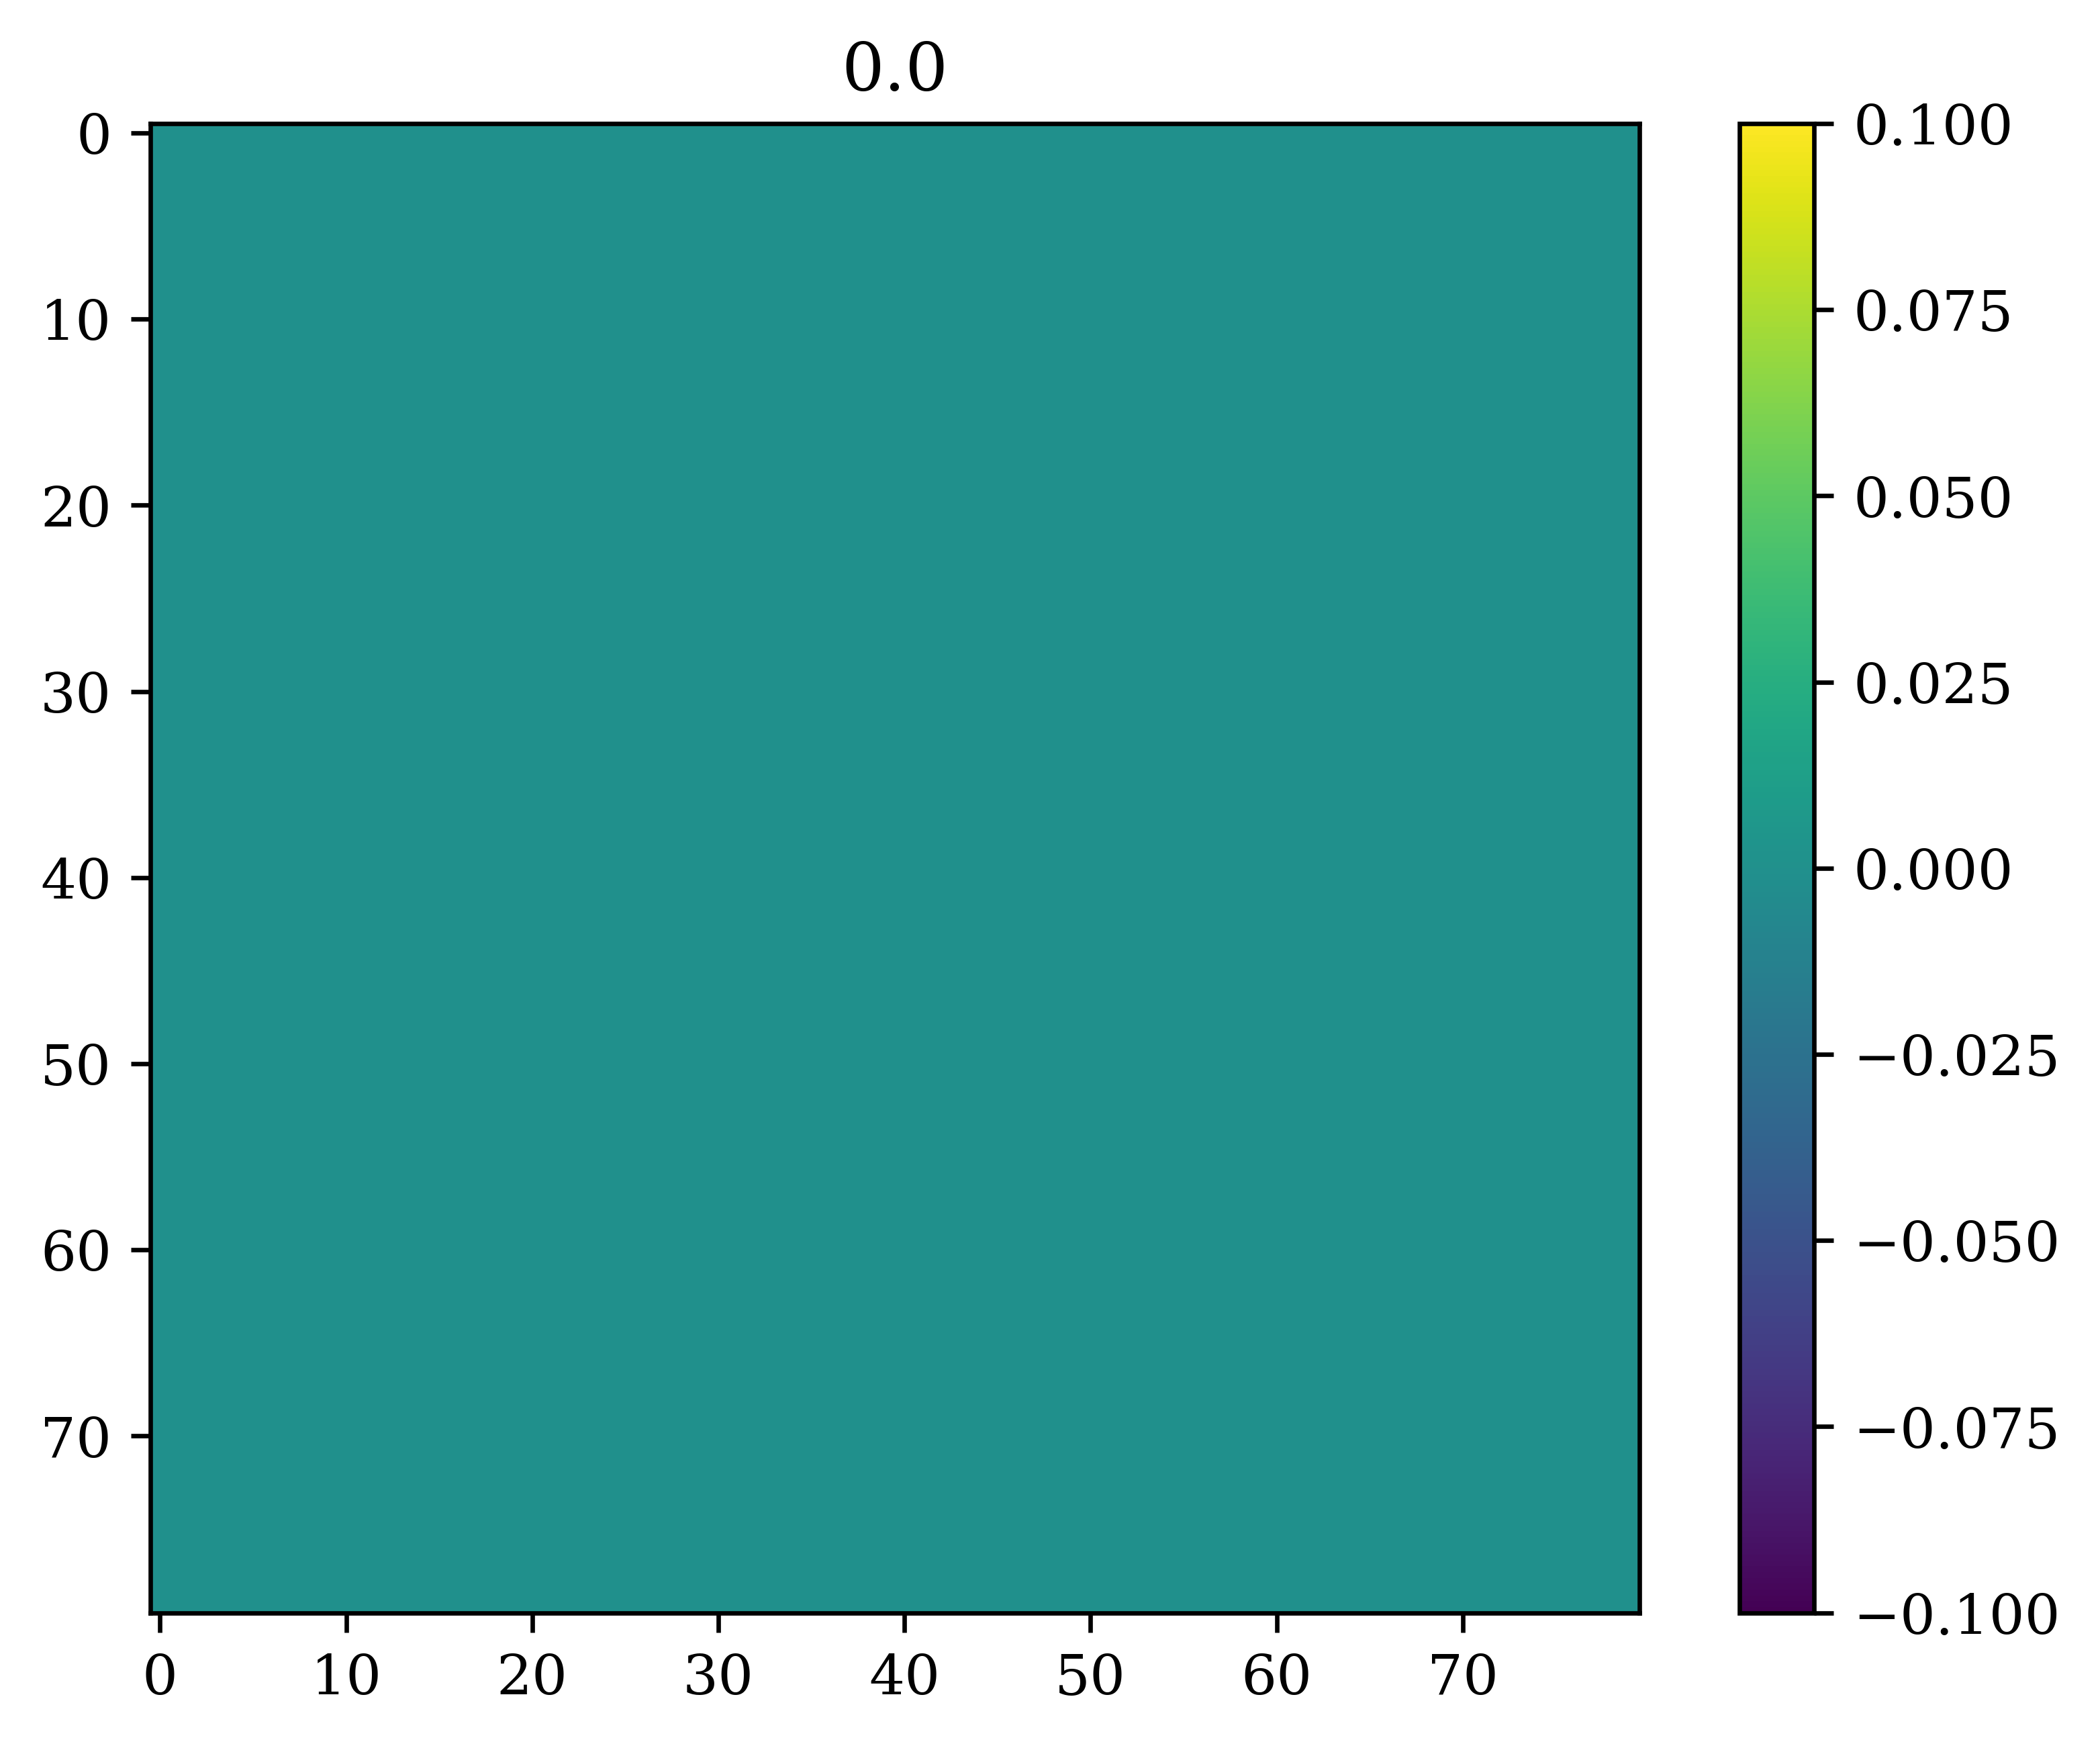

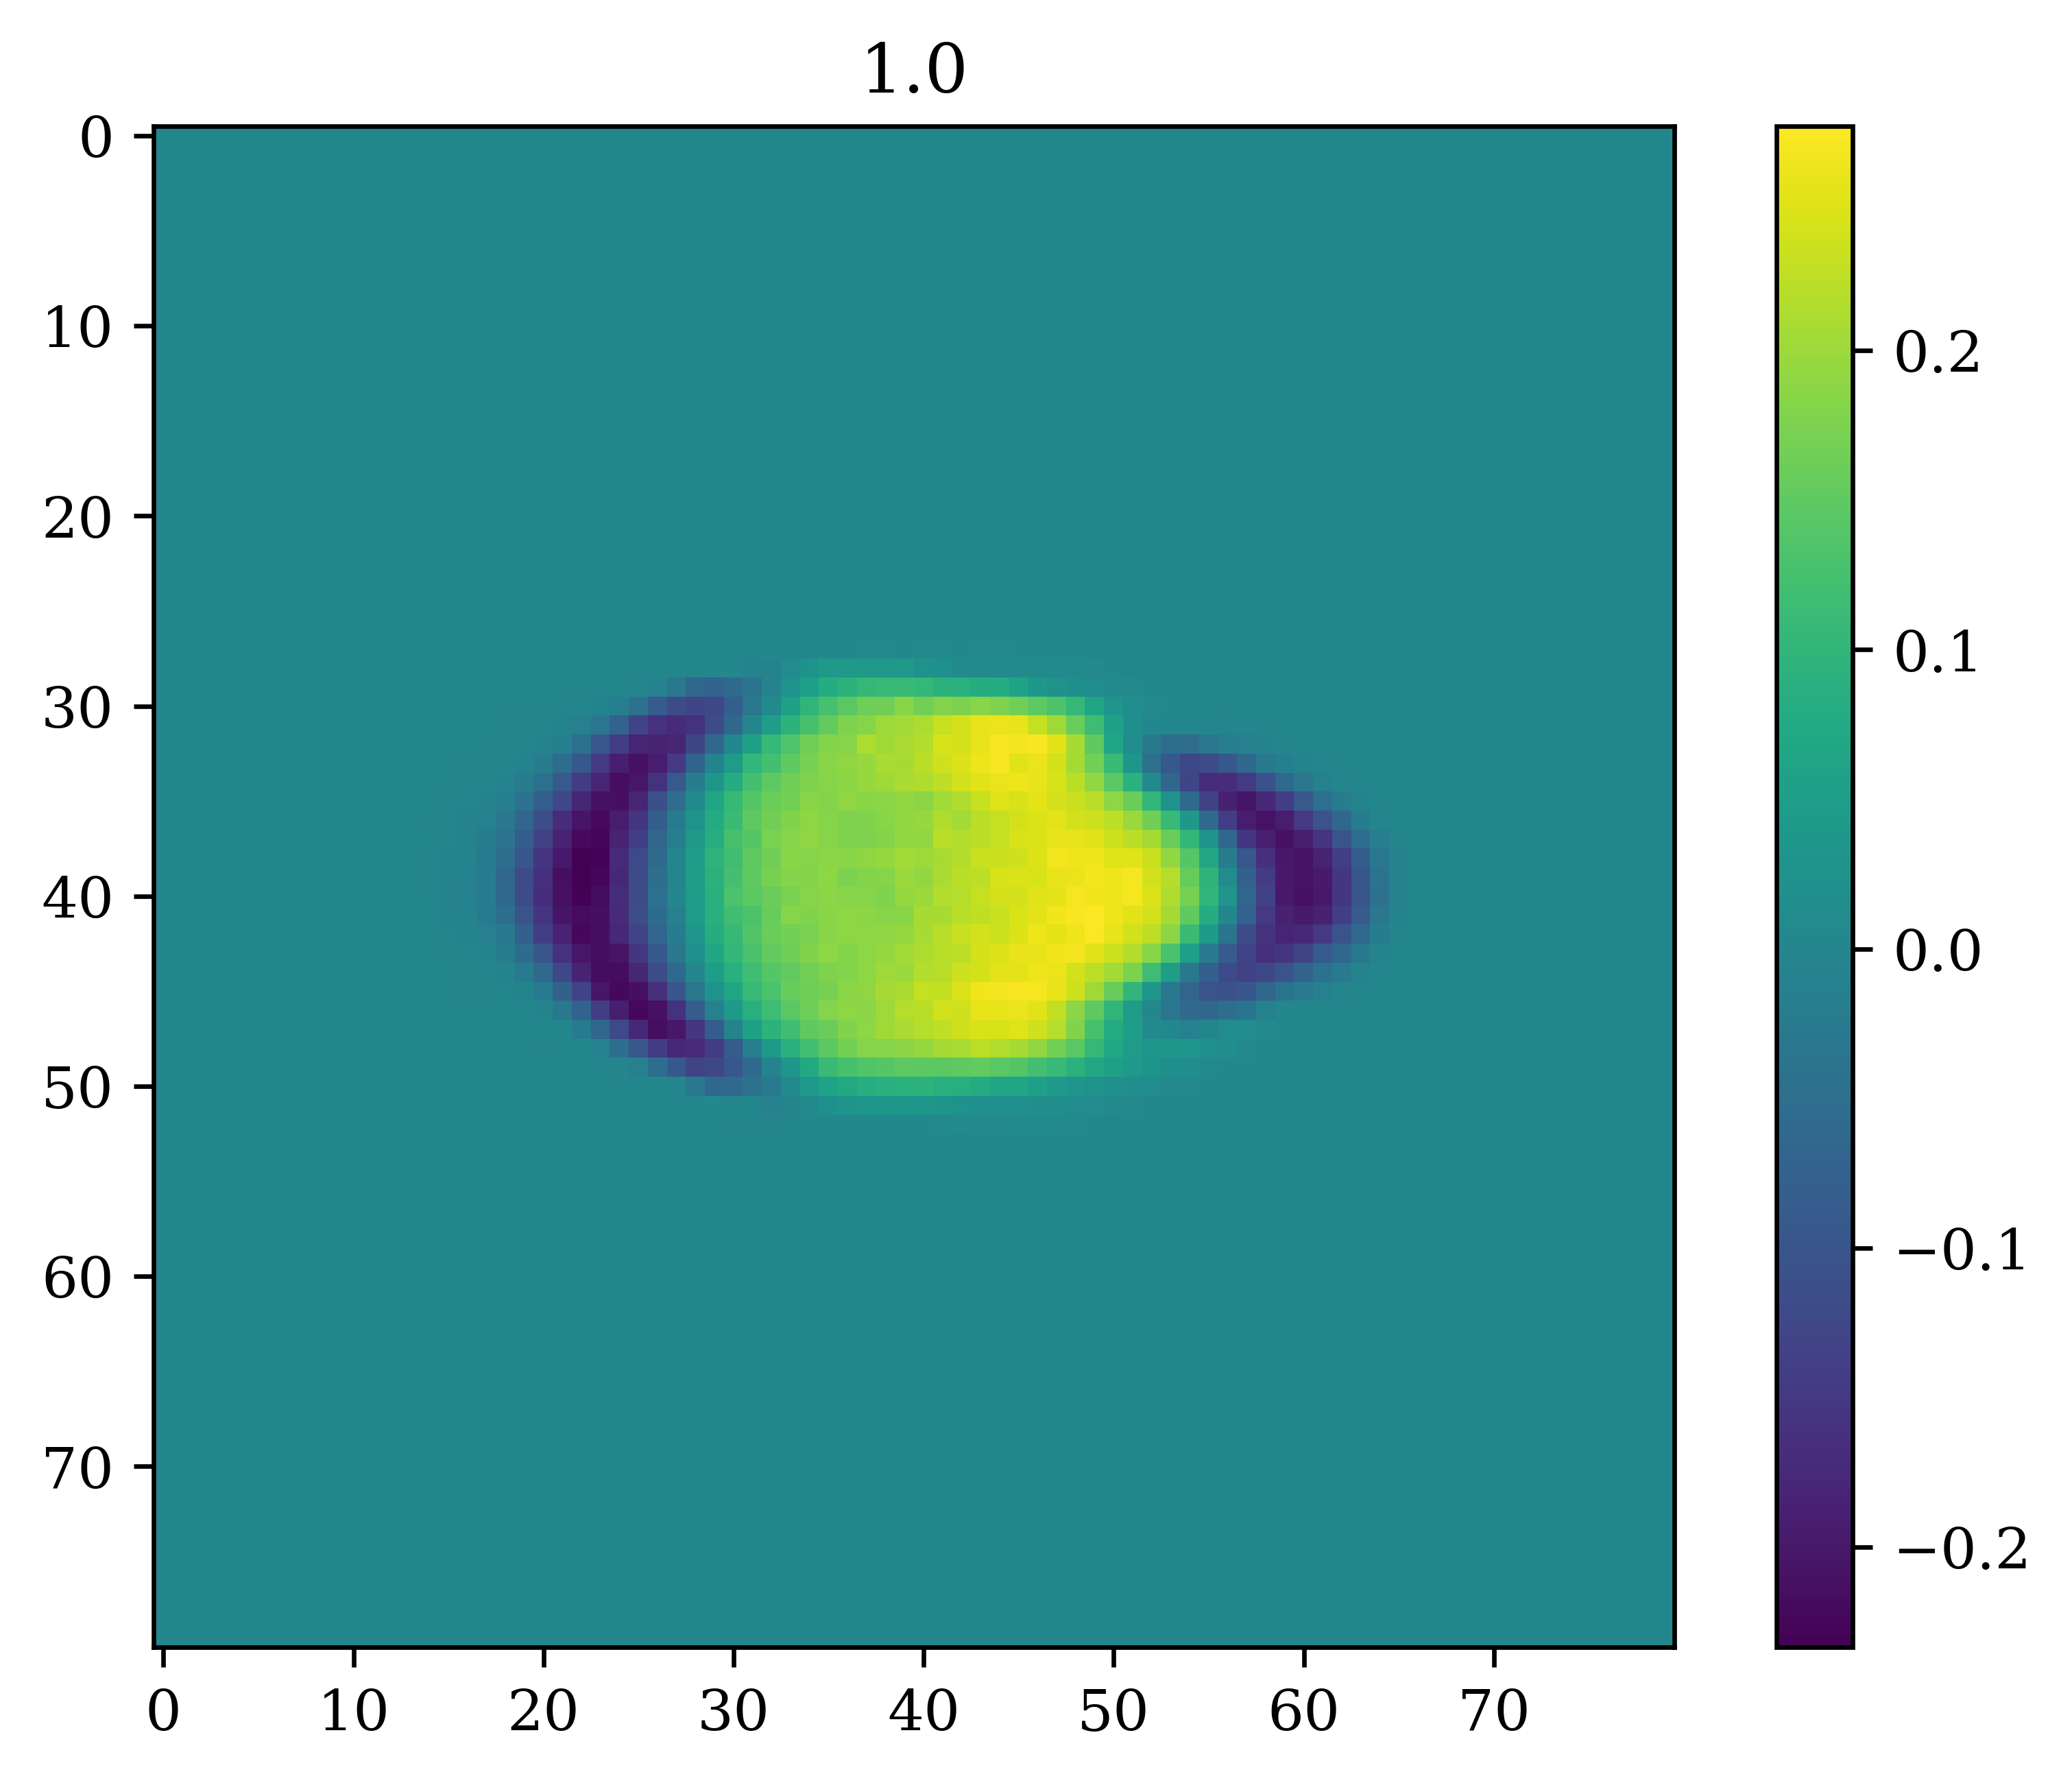

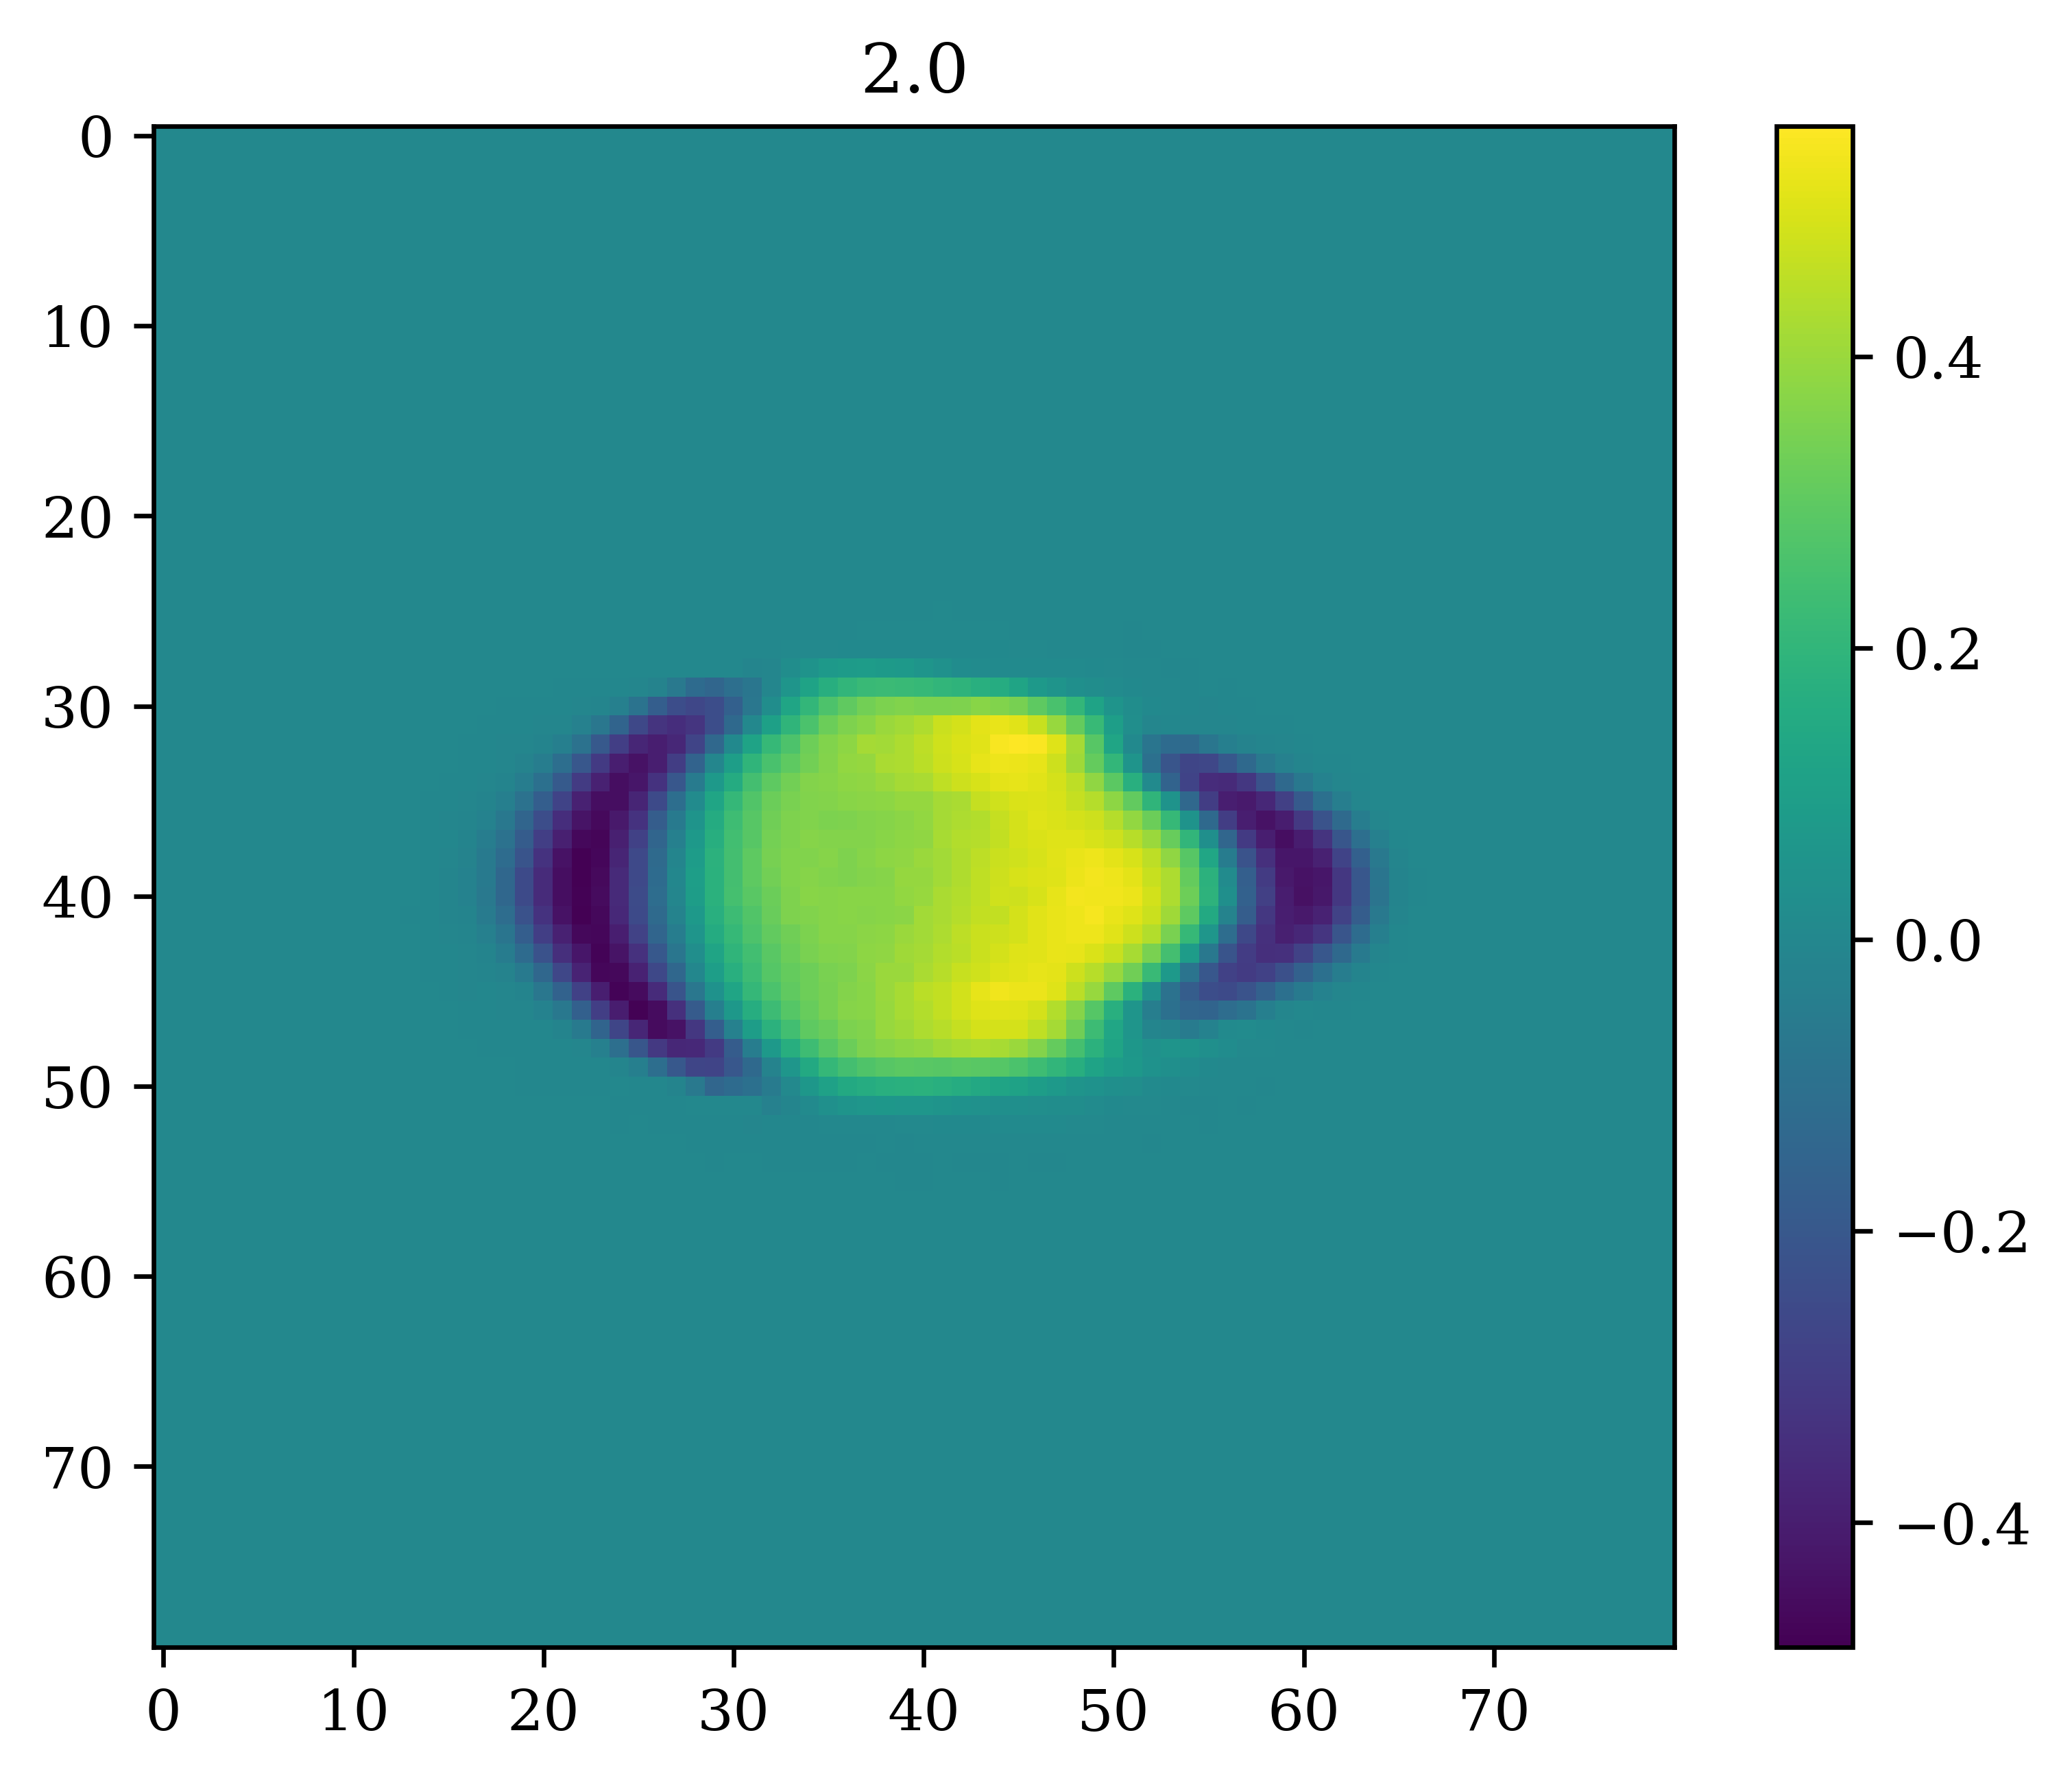

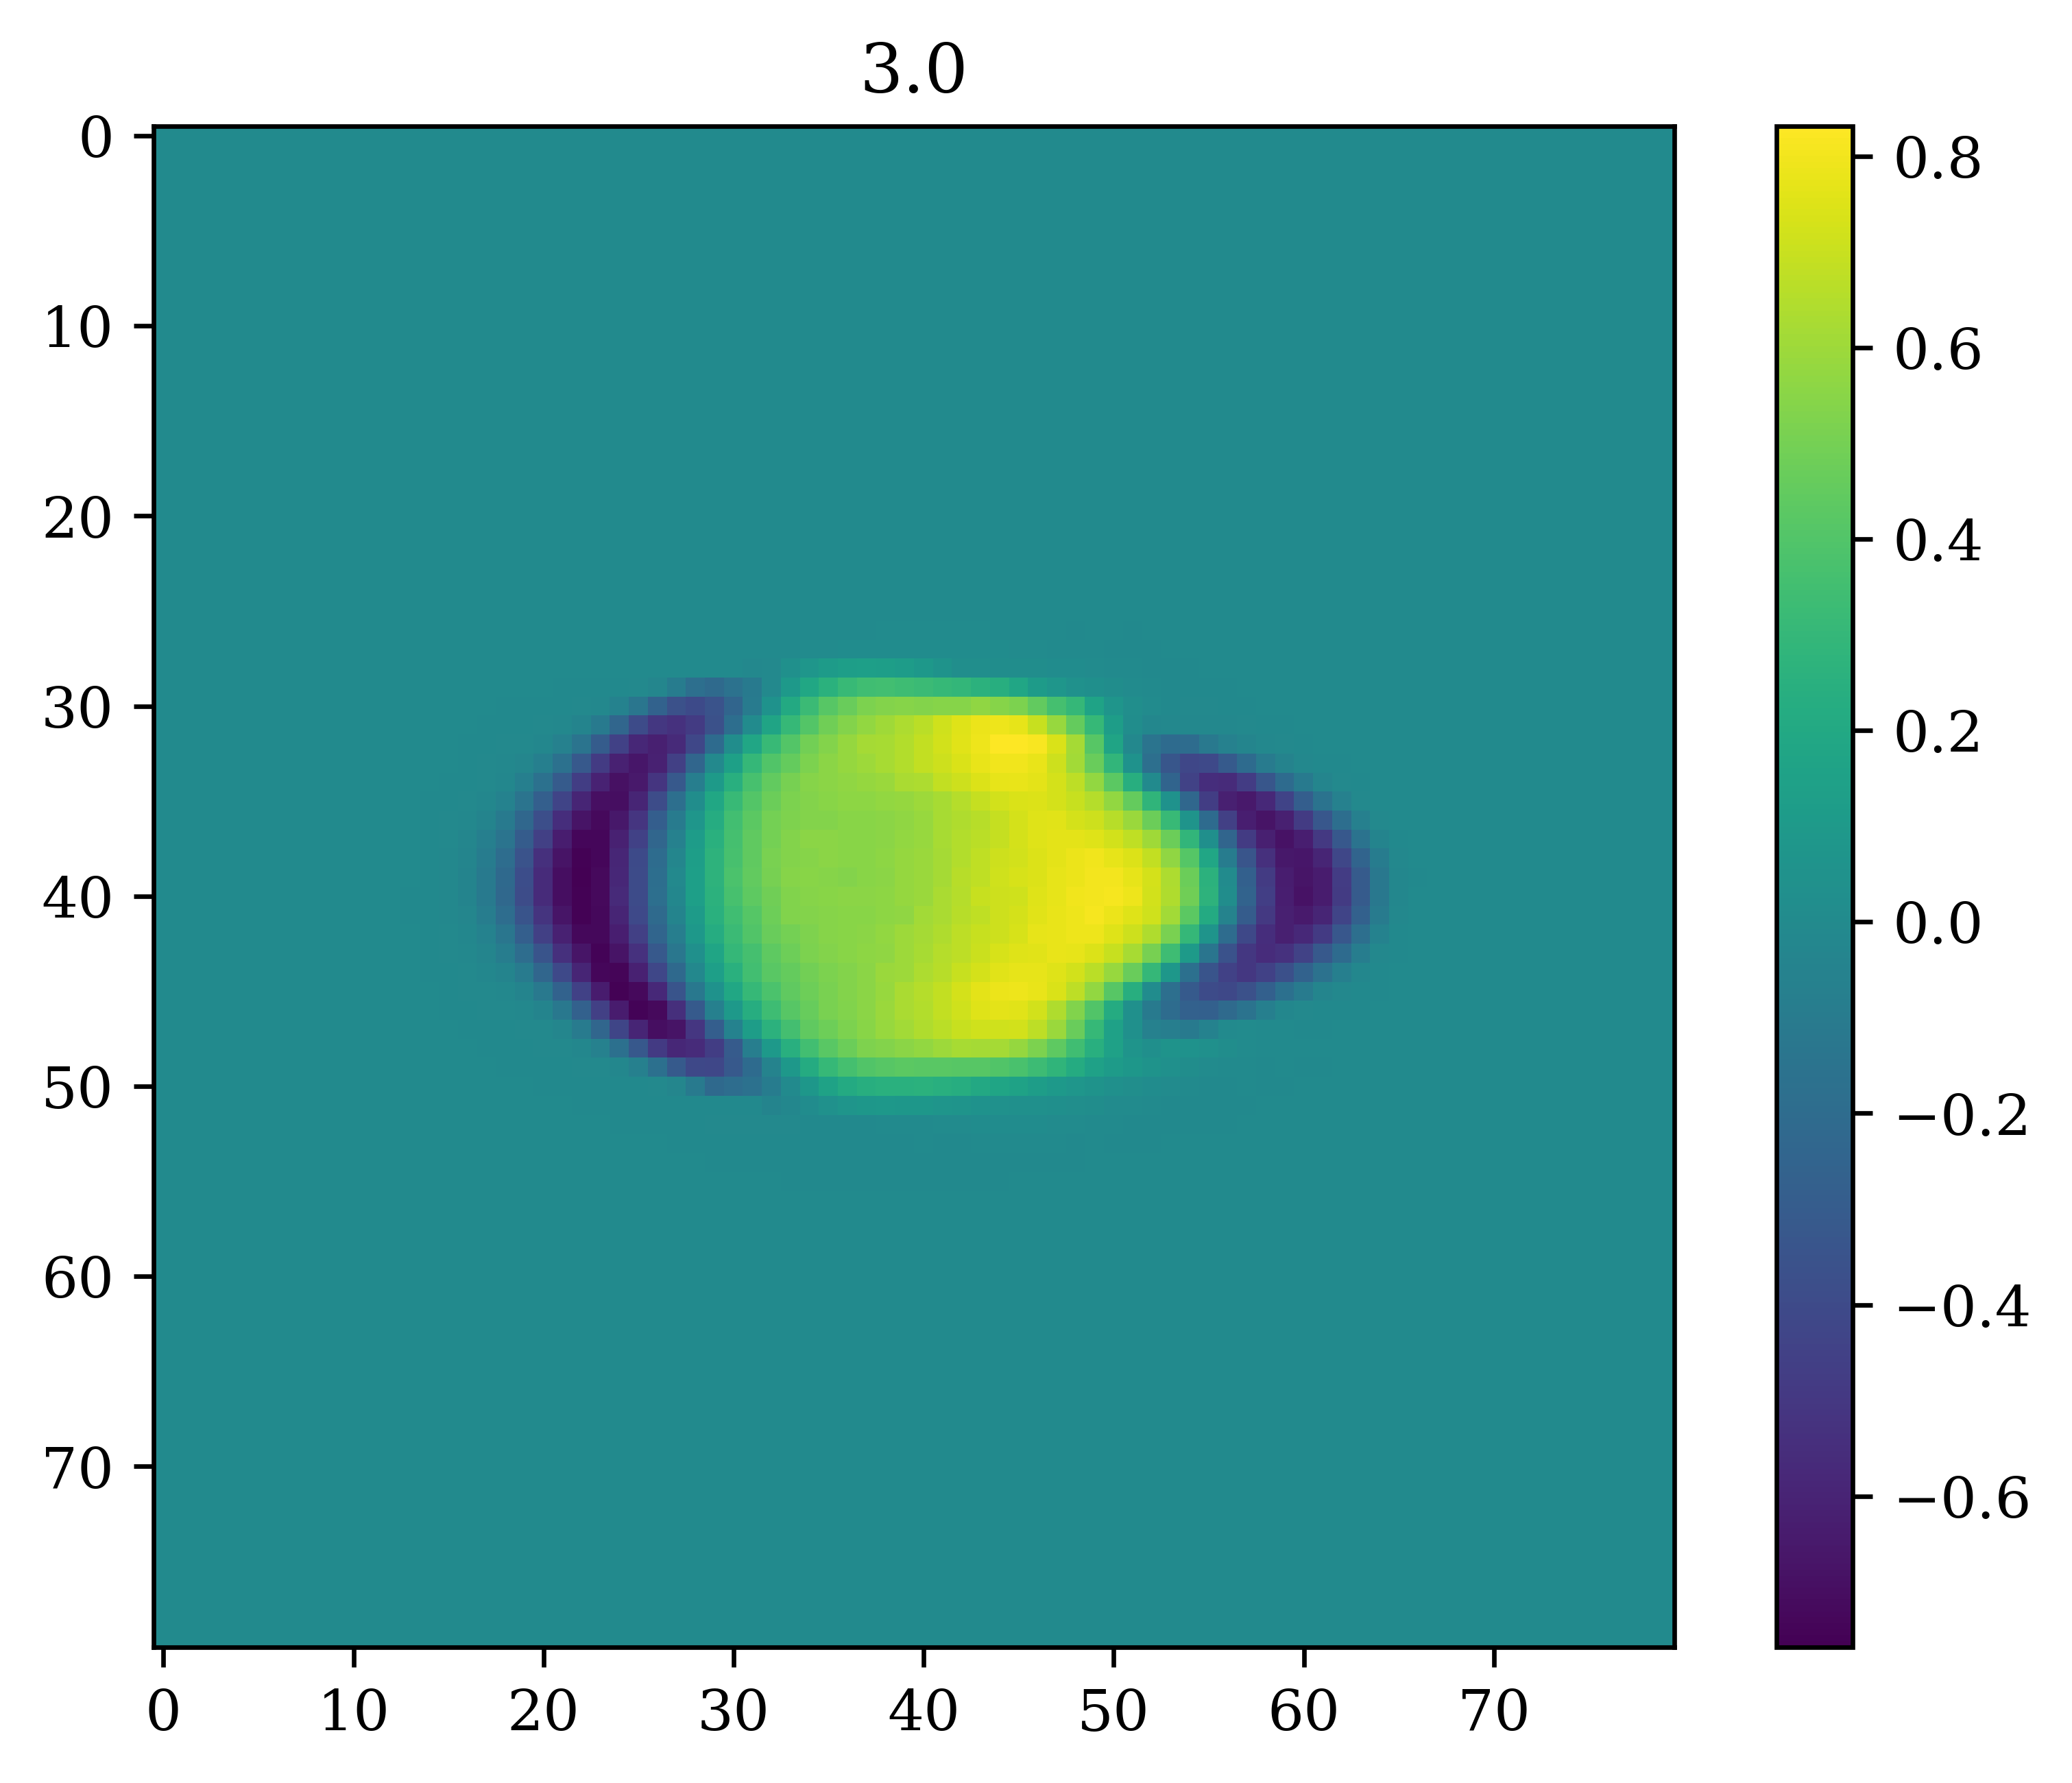

In [24]:
for k, v in offset_poses.items():
    plt.figure()
    plt.imshow(v)
    plt.colorbar()
    plt.title(k)

## Understand male/female height comparisons better

In [43]:
animal = females[12][0]

with h5py.File(animal, 'r') as h5f:
    frames = h5f['frames'][:7_500]

In [44]:
med_pose_f = np.median(np.where(frames > 5, frames, 0), axis=0)

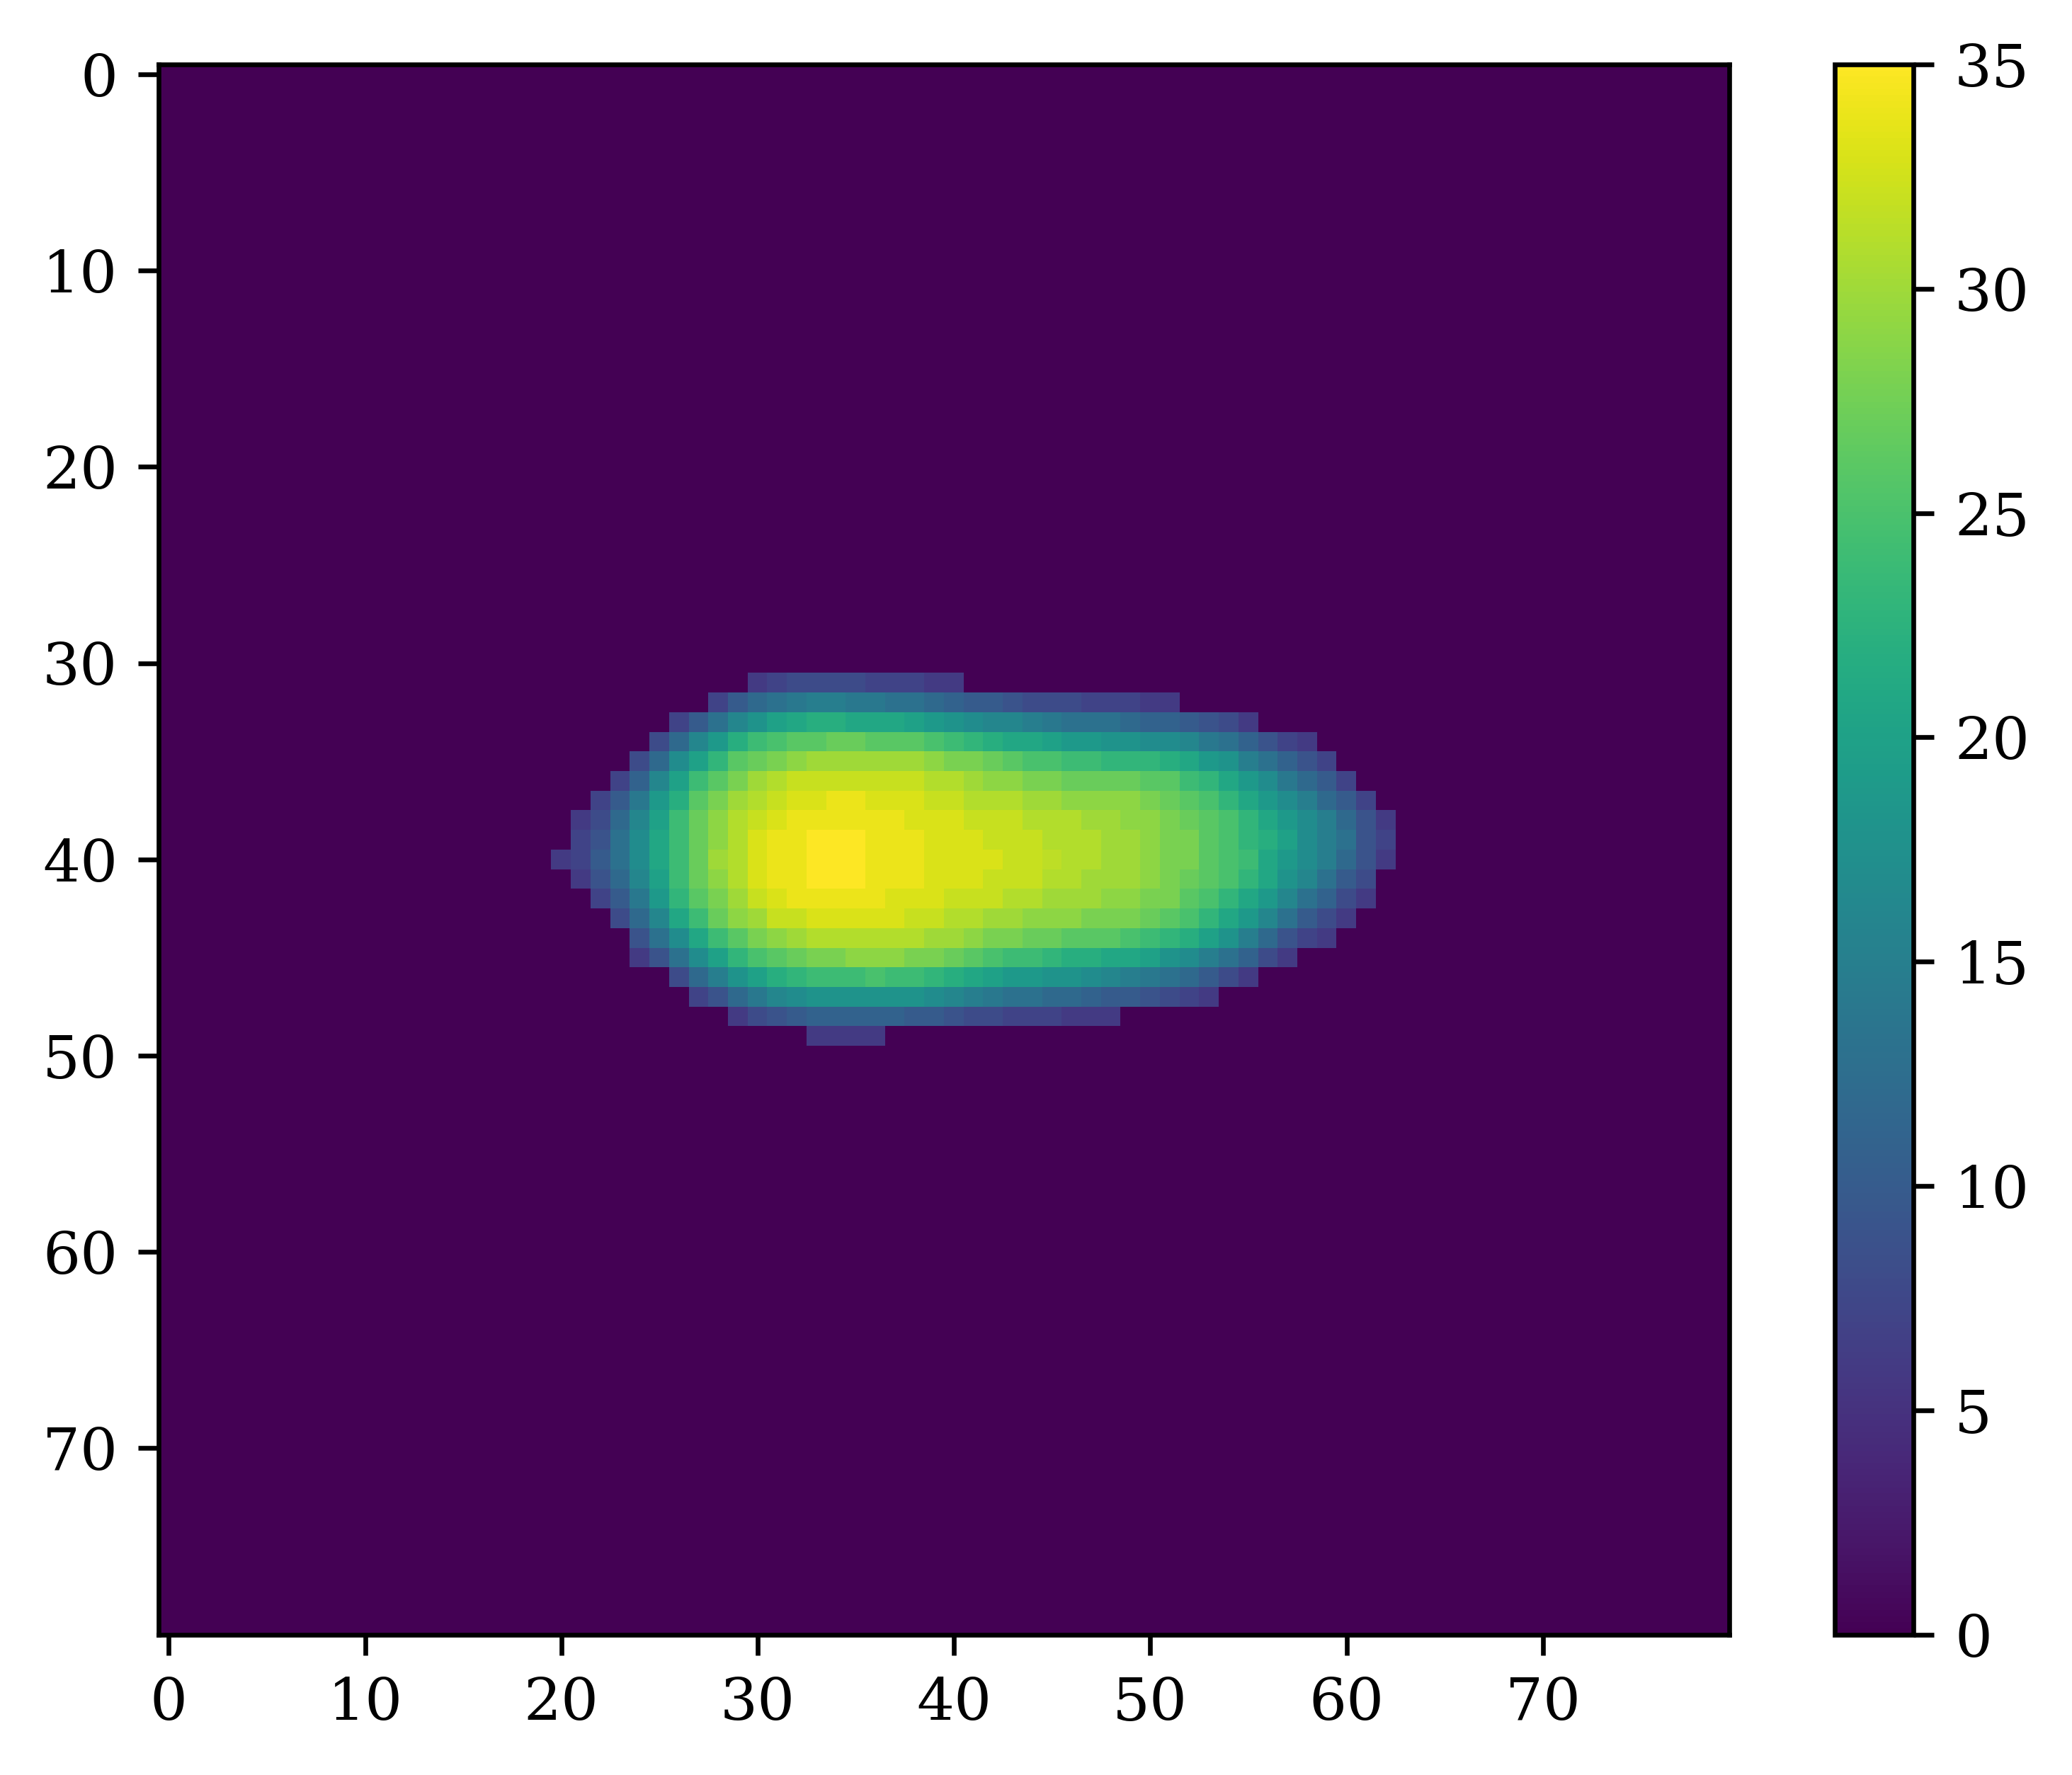

In [45]:
plt.imshow(med_pose_f)
plt.colorbar()

In [46]:
animal = males[12][0]

with h5py.File(animal, 'r') as h5f:
    frames = h5f['frames'][:7_500]

In [47]:
med_pose_m = np.median(np.where(frames > 5, frames, 0), axis=0)

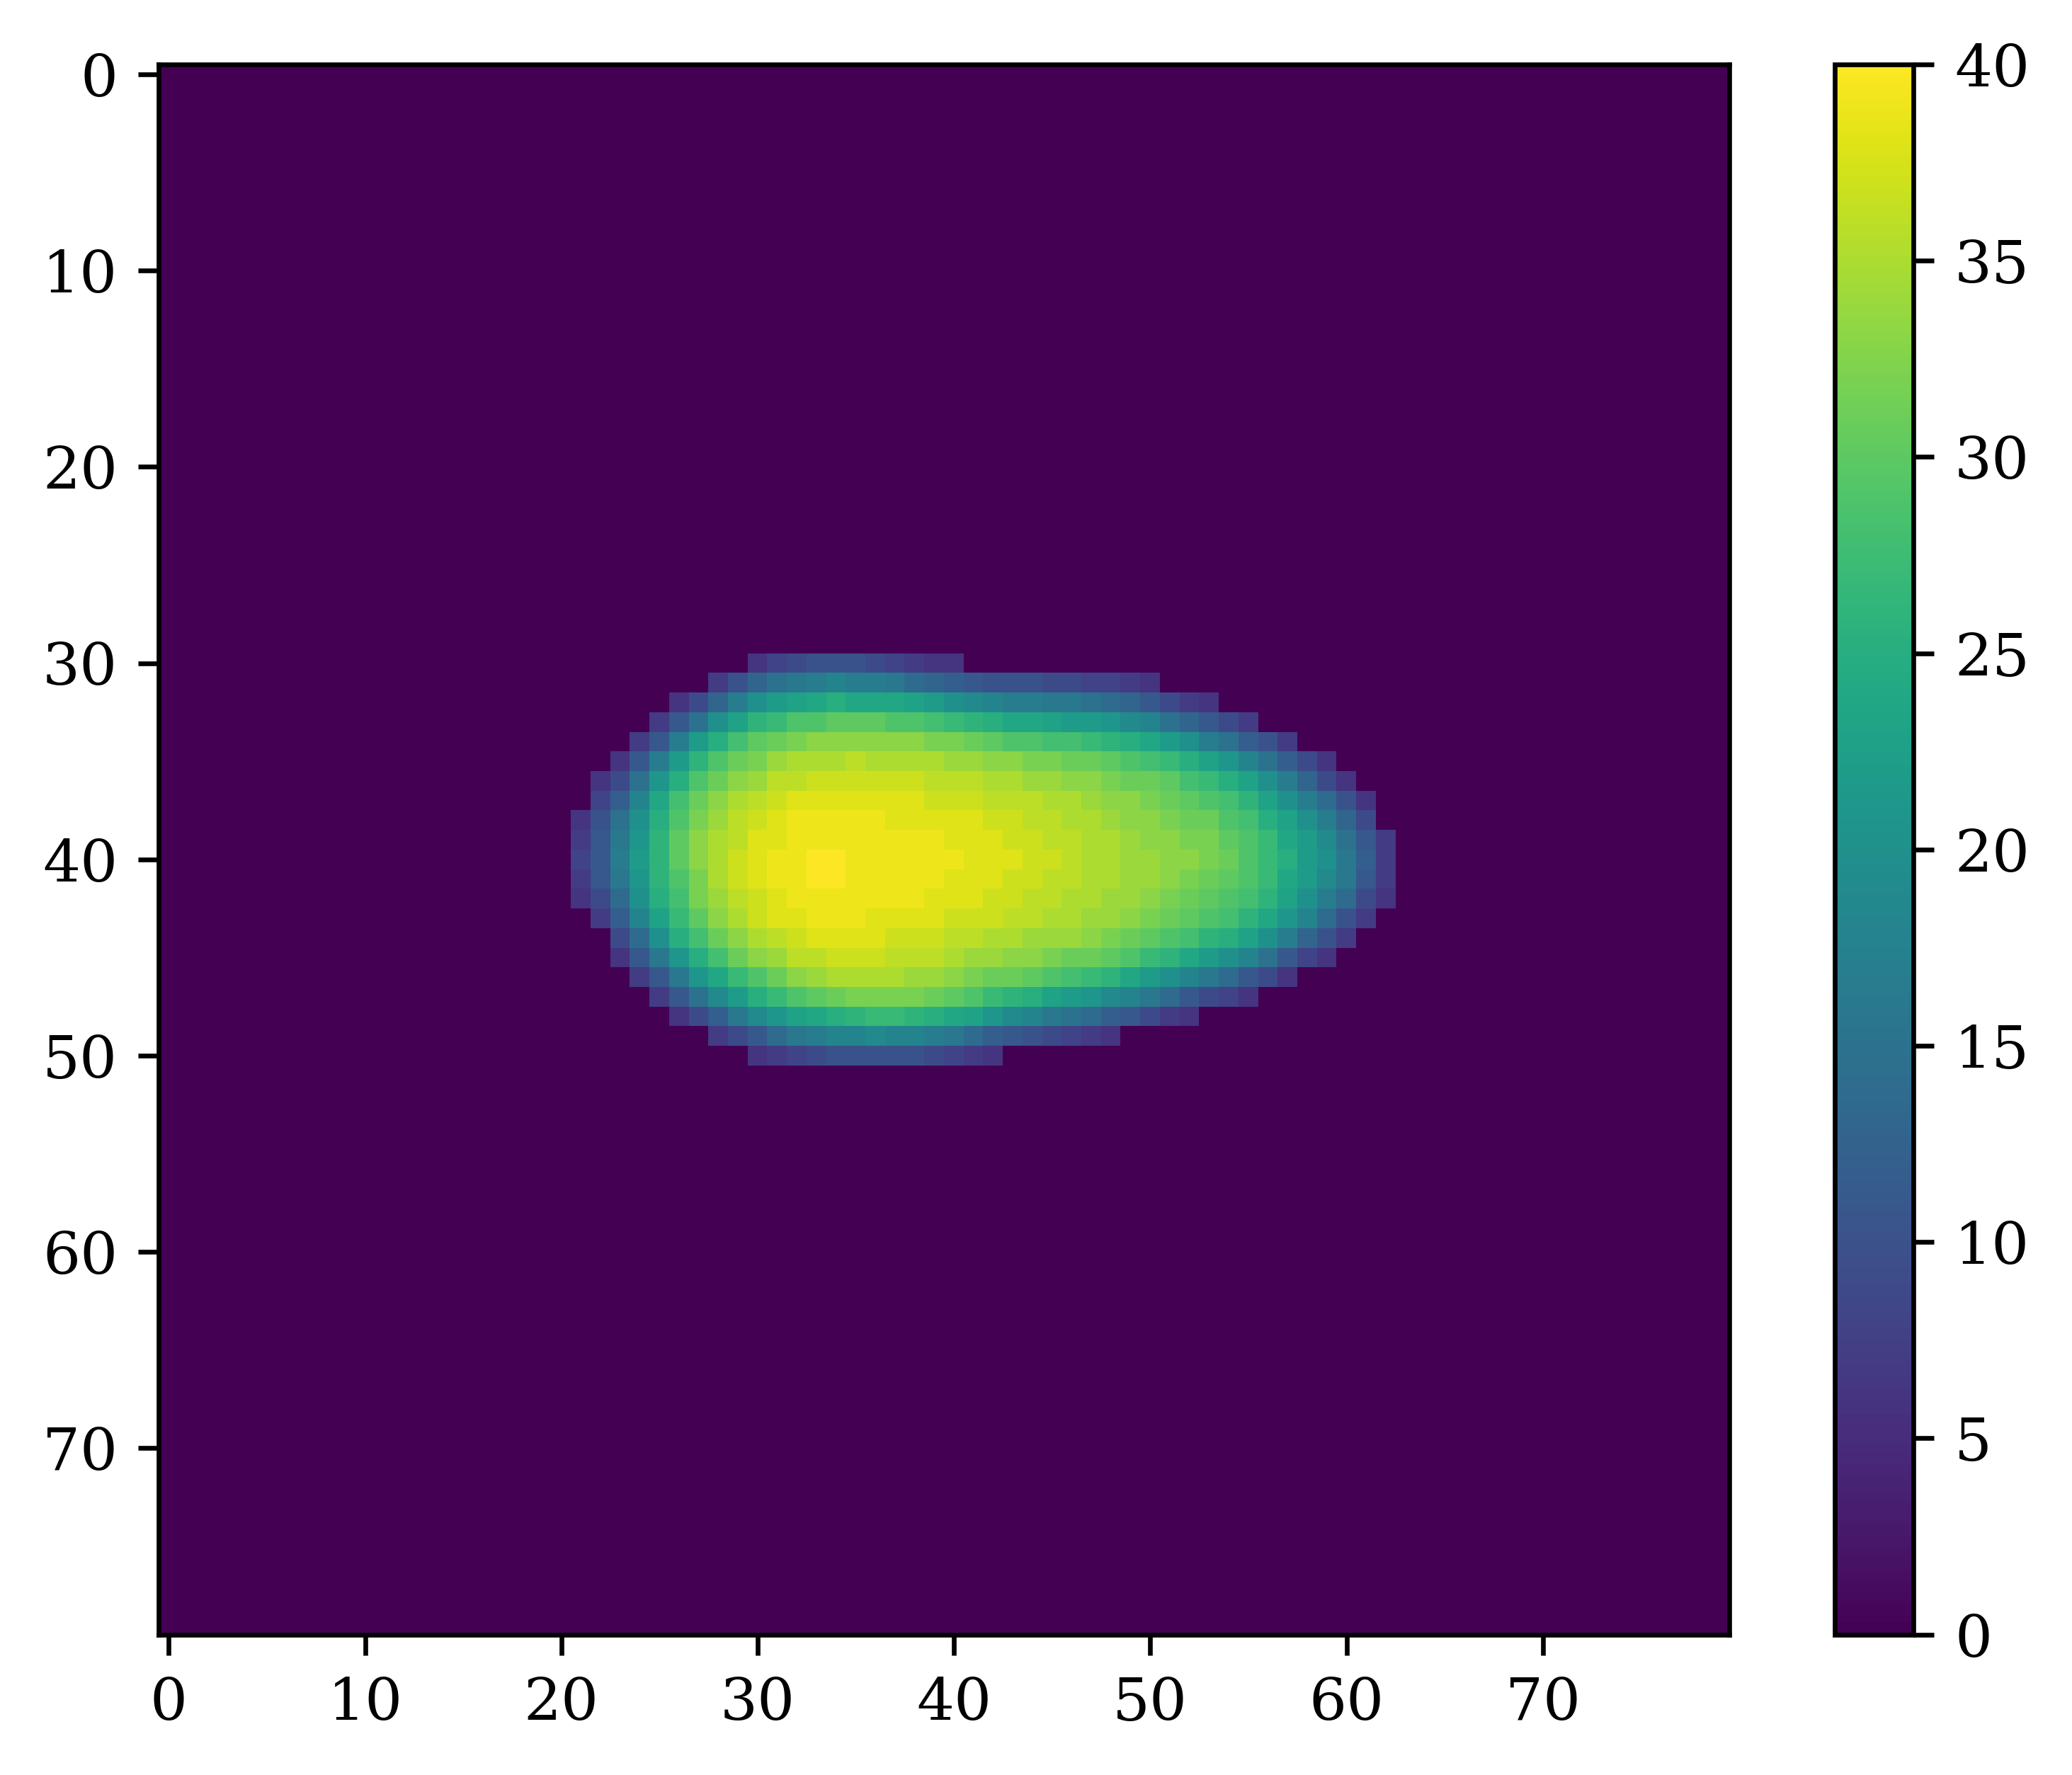

In [48]:
plt.imshow(med_pose_m)
plt.colorbar()

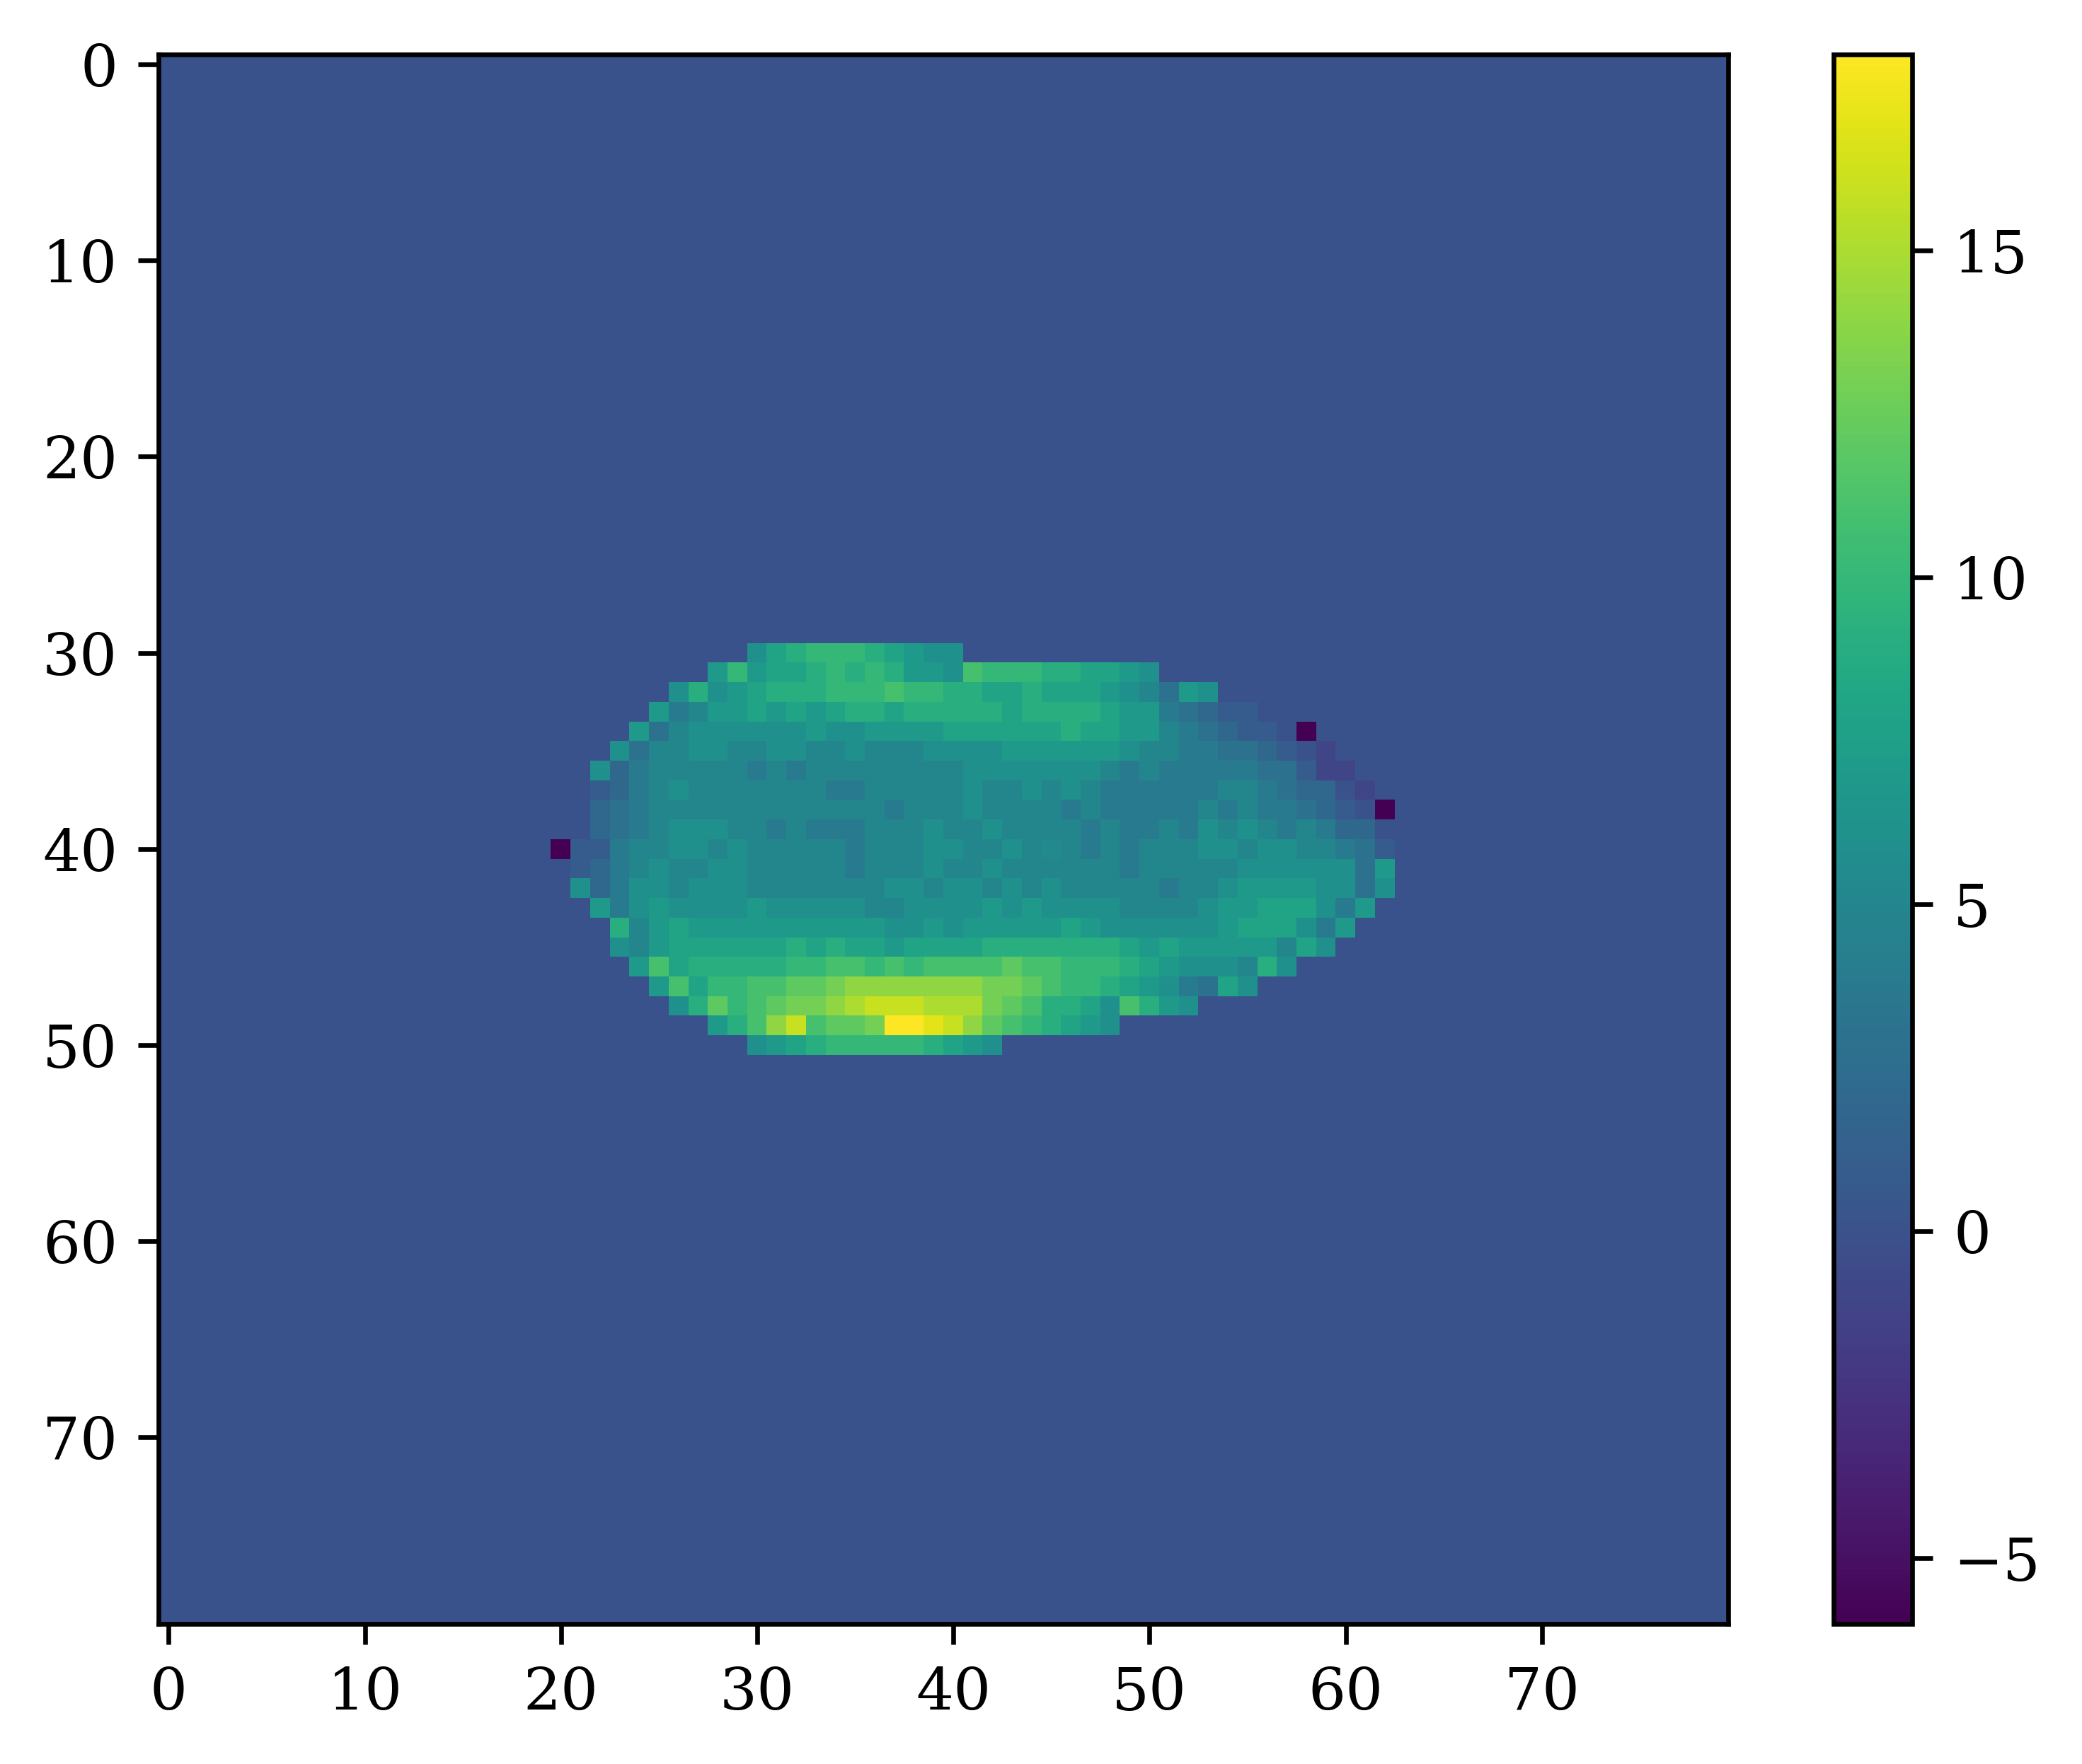

In [49]:
plt.imshow(med_pose_m - med_pose_f)
plt.colorbar()

In [50]:
diff = med_pose_m - med_pose_f

In [53]:
np.median(diff[diff != 0])

6.0

## For every age, figure out the height offset

In [59]:
from collections import defaultdict
from toolz import curry

In [56]:
# gather median poses from every animal in ontogeny

median_poses = {
    'males': defaultdict(list),
    'females': defaultdict(list),
}

In [58]:
for exp in ('ontogeny_males', 'ontogeny_females'):
    for age, path_list in groupby(get_age, new_files[exp]).items():
        for path in path_list:
            with h5py.File(path, 'r') as h5f:
                frames = h5f['frames'][()]
                med_pose = np.median(frames, axis=0)
            key = 'females' if 'females' in exp else 'males'
            median_poses[key][age].append(med_pose)

In [60]:
median_poses = valmap(curry(valmap)(np.array), median_poses)

In [61]:
import joblib

In [62]:
joblib.dump(median_poses, "/n/scratch/users/w/wg41/median-poses.p")

['/n/scratch/users/w/wg41/median-poses.p']